### Notebook for the paper:
## The influence of economic developments on party manifestos and election results in Germany: An analysis of the Comparative Manifesto Project

## Use the manifesto dataset
### https://manifesto-project.wzb.eu/datasets

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
#import statsmodels.api as sm
from scipy import stats
from dictionary import manifesto_coding_dict
from dictionary import party_color_dict_germany
from dictionary import all_codes_dict
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import datetime, timedelta
import csv
import json

In [2]:
data_folder = './../DATA/'
plot_save_folder = os.path.join(data_folder, 'images')

df_manifesto = pd.read_excel(f"{data_folder}MPDataset_MPDS2024a.xlsx")
#print(df_manifesto.head())
#print(df_manifesto)

## Use the manifesto solely for germany

In [3]:
df_manifesto_germany = df_manifesto.loc[df_manifesto["countryname"]=='Germany']
print(df_manifesto_germany)
df_manifesto_germany.to_csv(f"{data_folder}MP_Germany.csv")
df_manifesto_germany.to_excel(f"{data_folder}MP_Germany.xlsx")

      country countryname  oecdmember  eumember      edate    date  party  \
1941       41     Germany           0         0 1949-08-14  194908  41220   
1942       41     Germany           0         0 1949-08-14  194908  41320   
1943       41     Germany           0         0 1949-08-14  194908  41420   
1944       41     Germany           0         0 1949-08-14  194908  41521   
1945       41     Germany           0         0 1949-08-14  194908  41522   
...       ...         ...         ...       ...        ...     ...    ...   
2032       41     Germany          10        10 2021-09-26  202109  41320   
2033       41     Germany          10        10 2021-09-26  202109  41420   
2034       41     Germany          10        10 2021-09-26  202109  41521   
2035       41     Germany          10        10 2021-09-26  202109  41912   
2036       41     Germany          10        10 2021-09-26  202109  41953   

                                              partyname partyabbrev  parfam

## Plot the percentage of votes for each party over time

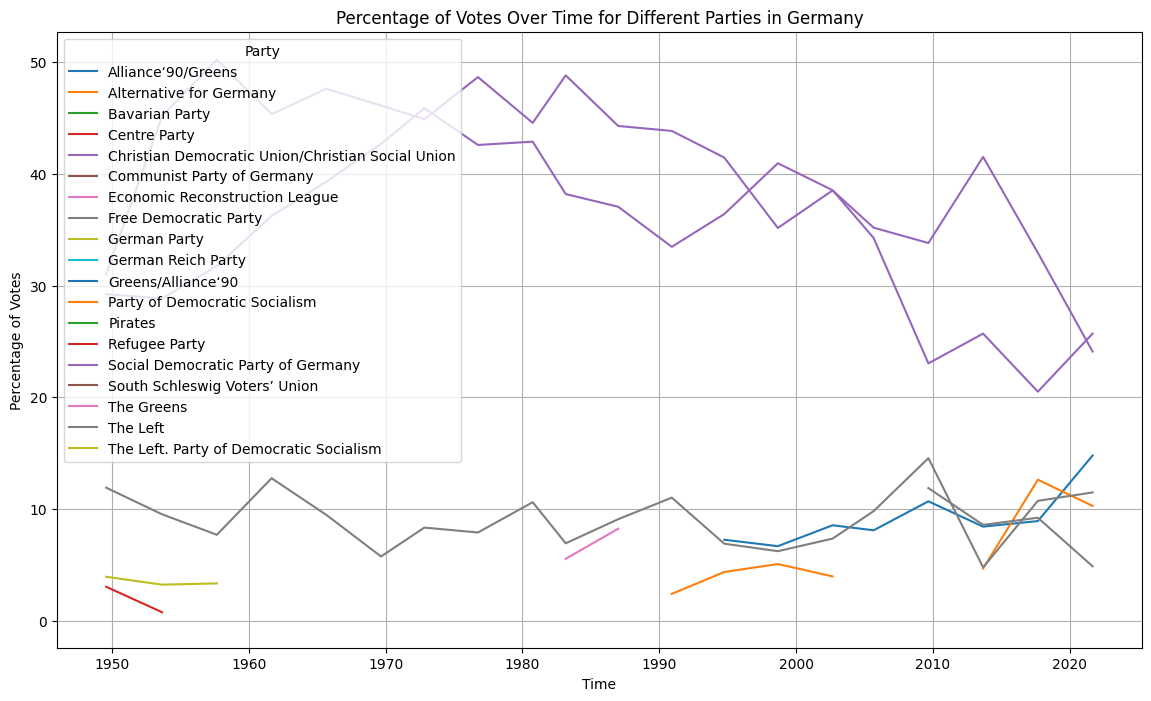

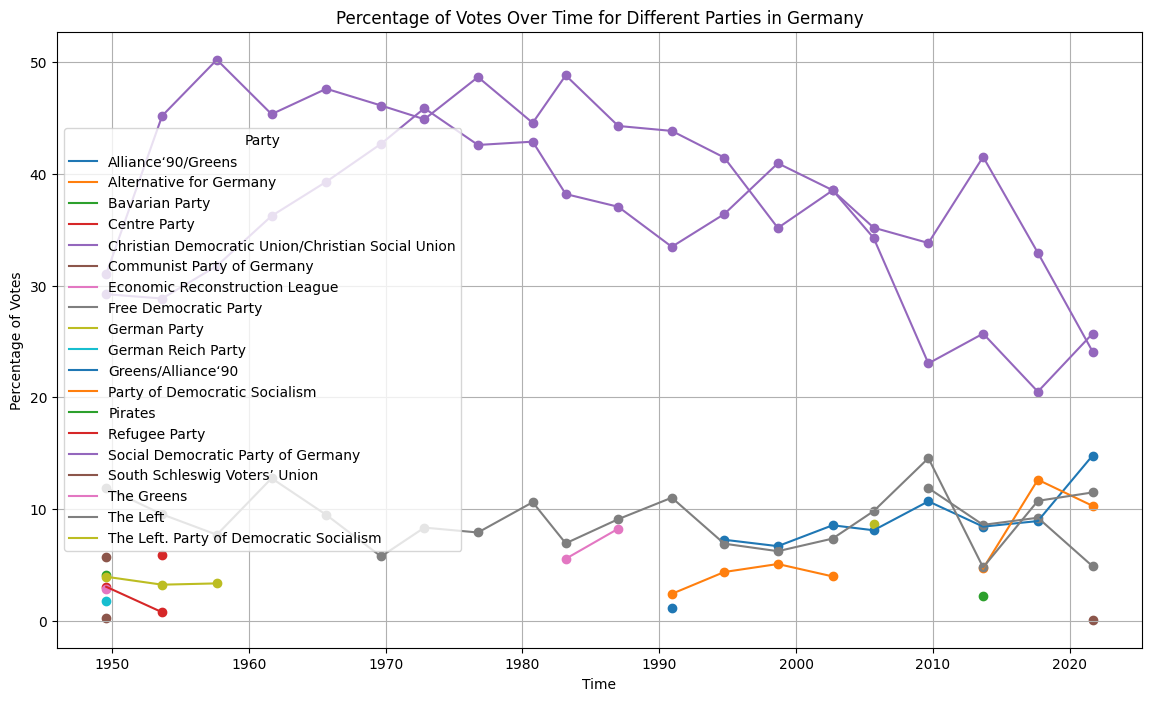

In [4]:
# create df for plotting
df_plotting = df_manifesto_germany.copy()


# Convert 'date' to datetime format for better plotting
df_plotting.loc[:, 'date'] = pd.to_datetime(df_plotting['date'], format='%Y%m')

# Pivot the dataframe to have 'date' as the index and 'partyabbrev' as columns
pivot_df = df_plotting.pivot(index='date', columns='partyname', values='pervote')

# Plot the time series data
plt.figure(figsize=(14, 8))
for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column)
plt.title('Percentage of Votes Over Time for Different Parties in Germany')
plt.xlabel('Time')
plt.ylabel('Percentage of Votes')
plt.legend(title='Party')
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 8))
for column in pivot_df.columns:
    #plt.scatter(pivot_df.index, pivot_df.values, label=column, zorder=5)
    plt.scatter(pivot_df.index, pivot_df[column])
    plt.plot(pivot_df.index, pivot_df[column], label=column)
plt.title('Percentage of Votes Over Time for Different Parties in Germany')
plt.xlabel('Time')
plt.ylabel('Percentage of Votes')
plt.legend(title='Party')
plt.grid(True)
plt.savefig(f"{data_folder}/images/inital_data.png")
plt.show()




## Now better the visuality with the corresponding colors for each party

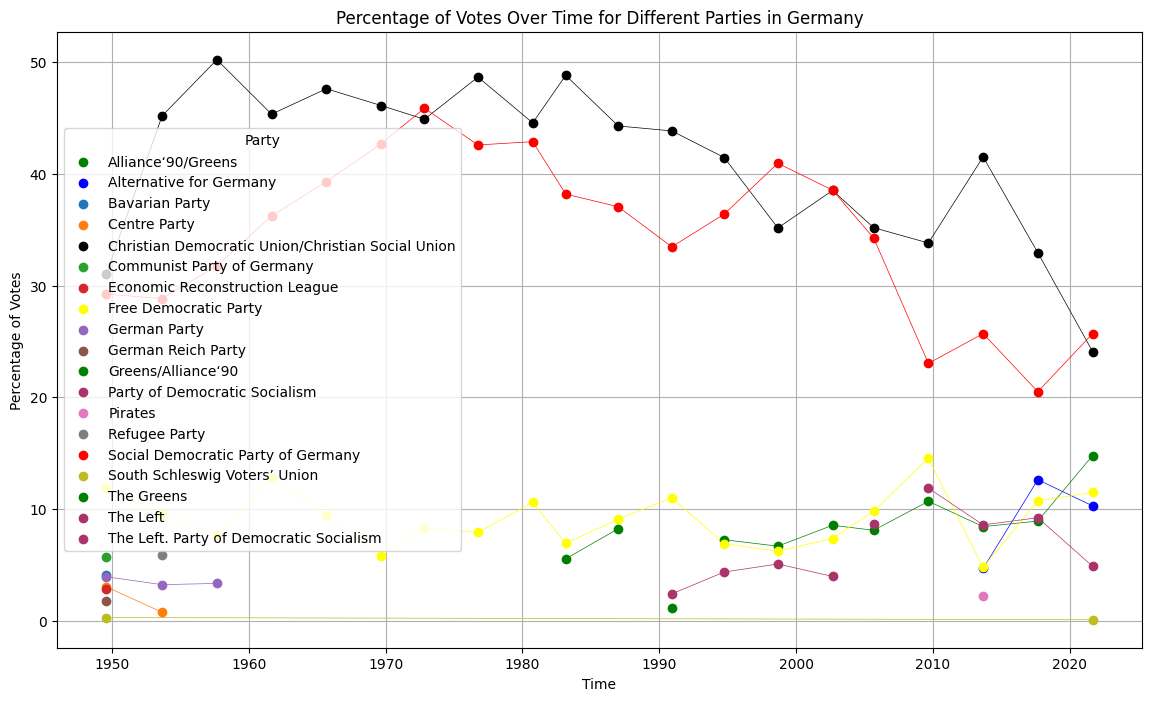

In [5]:
# create df for plotting
df_plotting = df_manifesto_germany.copy()


# Convert 'date' to datetime format for better plotting
df_plotting.loc[:, 'date'] = pd.to_datetime(df_plotting['date'], format='%Y%m')


#df_plotting = df_plotting[df_plotting['pervote']  >= 5.0]
#df_plotting = df_plotting[df_plotting['absseat'] > 0] # filters partys which did not get into the parliament
#df_plotting = df_plotting[df_plotting['absseat'] / df_plotting['totseats']  >= 0.01] # filters partys like SSW
# but keeps parties like Linke which have less than 5.0 pervote but are in the parliament due to 3 direct mandates

pivot_df = df_plotting.pivot(index='date', columns='partyname', values='pervote')


plt.figure(figsize=(14, 8))
for column in pivot_df.columns:
    party_data = pivot_df[column].dropna()
    if not party_data.empty:
        party_name = df_plotting[df_plotting['partyname'] == column]['partyname'].values[0]
        color = party_color_dict_germany.get(party_name, None)
        plt.scatter(party_data.index, party_data.values, label=party_name, color=color, zorder=5)
        plt.plot(party_data.index, party_data.values, color=color, linewidth=0.5)


plt.title('Percentage of Votes Over Time for Different Parties in Germany')
plt.xlabel('Time')
plt.ylabel('Percentage of Votes')
plt.legend(title='Party')
plt.grid(True)
plt.show()

## Now combine nowadays parties with their predecessors

partyname
Social Democratic Party of Germany                   20
Free Democratic Party                                20
Christian Democratic Union/Christian Social Union    20
nAlliance‘90/Greens                                  11
nPDS/The Left                                         9
German Party                                          3
Alternative for Germany                               3
Centre Party                                          2
South Schleswig Voters’ Union                         2
Economic Reconstruction League                        1
Communist Party of Germany                            1
Refugee Party                                         1
Bavarian Party                                        1
German Reich Party                                    1
Pirates                                               1
Name: count, dtype: int64


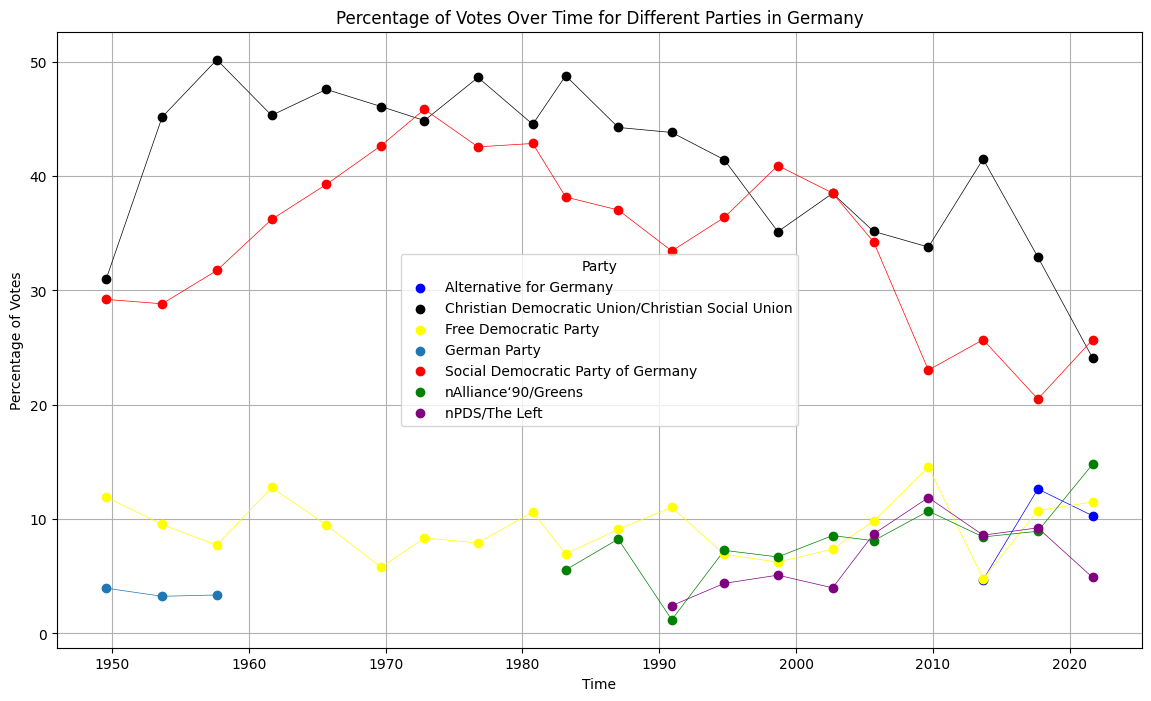

In [6]:
df_new_manifesto_germany = df_manifesto_germany.copy()

# combine the different versions/ predecessors of nowadays party "The Left"
df_new_manifesto_germany.loc[df_new_manifesto_germany['partyname'].isin(
    ["Party of Democratic Socialism", "The Left. Party of Democratic Socialism", "The Left"]), 'partyname'] = 'nPDS/The Left'
df_new_manifesto_germany.loc[df_new_manifesto_germany['partyname'] == 'nPDS/The Left', 'partyabbrev'] = 'nPDS/Left'

# Combine the different versions/predecessors of nowadays party "Alliance‘90/Greens"
df_new_manifesto_germany.loc[df_new_manifesto_germany['partyname'].isin(
    ["The Greens", "Greens/Alliance‘90", "Alliance‘90/Greens"]), 'partyname'] = 'nAlliance‘90/Greens'
df_new_manifesto_germany.loc[df_new_manifesto_germany['partyname'] == 'nAlliance‘90/Greens', 'partyabbrev'] = 'n90/Greens'

# Only include rows of parties with a partyname where there are more than 2 rows for that partyname
party_counts = df_new_manifesto_germany['partyname'].value_counts()
print(party_counts)
df_new_manifesto_germany = df_new_manifesto_germany[df_new_manifesto_germany['partyname'].isin(party_counts[party_counts > 2].index)]

# Add new columns with specified calculations
df_new_manifesto_germany.loc[:, 'n_markeco'] = (df_new_manifesto_germany['per401']
                                                + df_new_manifesto_germany['per402']
                                                + df_new_manifesto_germany['per407'] 
                                                #+ df_new_manifesto_germany['per408']
                                                + df_new_manifesto_germany['per410'] 
                                                + df_new_manifesto_germany['per414'] 
                                                #+ df_new_manifesto_germany['per702']
                                               )

df_new_manifesto_germany.loc[:, 'n_planeco'] = (df_new_manifesto_germany['per403'] 
                                                + df_new_manifesto_germany['per404']
                                                + df_new_manifesto_germany['per405']
                                                #+ df_new_manifesto_germany['per409']
                                                + df_new_manifesto_germany['per412'] 
                                                + df_new_manifesto_germany['per413'] 
                                                + df_new_manifesto_germany['per415'] 
                                                #+ df_new_manifesto_germany['per701']
                                               )

df_new_manifesto_germany.loc[:, 'n_crisiseco'] = (df_new_manifesto_germany['per402'] 
                                                + df_new_manifesto_germany['per409'] 
                                                + df_new_manifesto_germany['per410'] 
                                               )

# 410 economic_growth

df_new_manifesto_germany.loc[:, 'n_contra_immigration'] = df_new_manifesto_germany['per601'] + df_new_manifesto_germany['per608']
df_new_manifesto_germany.loc[:, 'n_pro_immigration'] = df_new_manifesto_germany['per602'] + df_new_manifesto_germany['per607']

df_new_manifesto_germany.to_csv(f"{data_folder}MP_new_Germany.csv")
df_new_manifesto_germany.to_excel(f"{data_folder}MP_new_Germany.xlsx")
####
# df_new_manifesto_germany = pd.read_excel(f"{data_folder}MP_new_Germany_chancellor.xlsx")
# create df for plotting
df_plotting = df_new_manifesto_germany.copy()

# Convert 'date' to datetime format for better plotting
df_plotting.loc[:, 'date'] = pd.to_datetime(df_plotting['date'], format='%Y%m')


#df_plotting = df_plotting[df_plotting['pervote']  >= 5.0]
#df_plotting = df_plotting[df_plotting['absseat'] > 0] # filters partys which did not get into the parliament
#df_plotting = df_plotting[df_plotting['absseat'] / df_plotting['totseats']  >= 0.01] # filters partys like SSW
# but keeps parties like Linke which have less than 5.0 pervote but are in the parliament due to 3 direct mandates

pivot_df = df_plotting.pivot(index='date', columns='partyname', values='pervote')


plt.figure(figsize=(14, 8))
for column in pivot_df.columns:
    party_data = pivot_df[column].dropna()
    if not party_data.empty:
        party_name = df_plotting[df_plotting['partyname'] == column]['partyname'].values[0]
        color = party_color_dict_germany.get(party_name, None)
        plt.scatter(party_data.index, party_data.values, label=party_name, color=color, zorder=5)
        plt.plot(party_data.index, party_data.values, color=color, linewidth=0.5)


plt.title('Percentage of Votes Over Time for Different Parties in Germany')
plt.xlabel('Time')
plt.ylabel('Percentage of Votes')
plt.legend(title='Party')
plt.grid(True)
plt.savefig(f"{data_folder}/images/preprocessed_data.png")
plt.show()


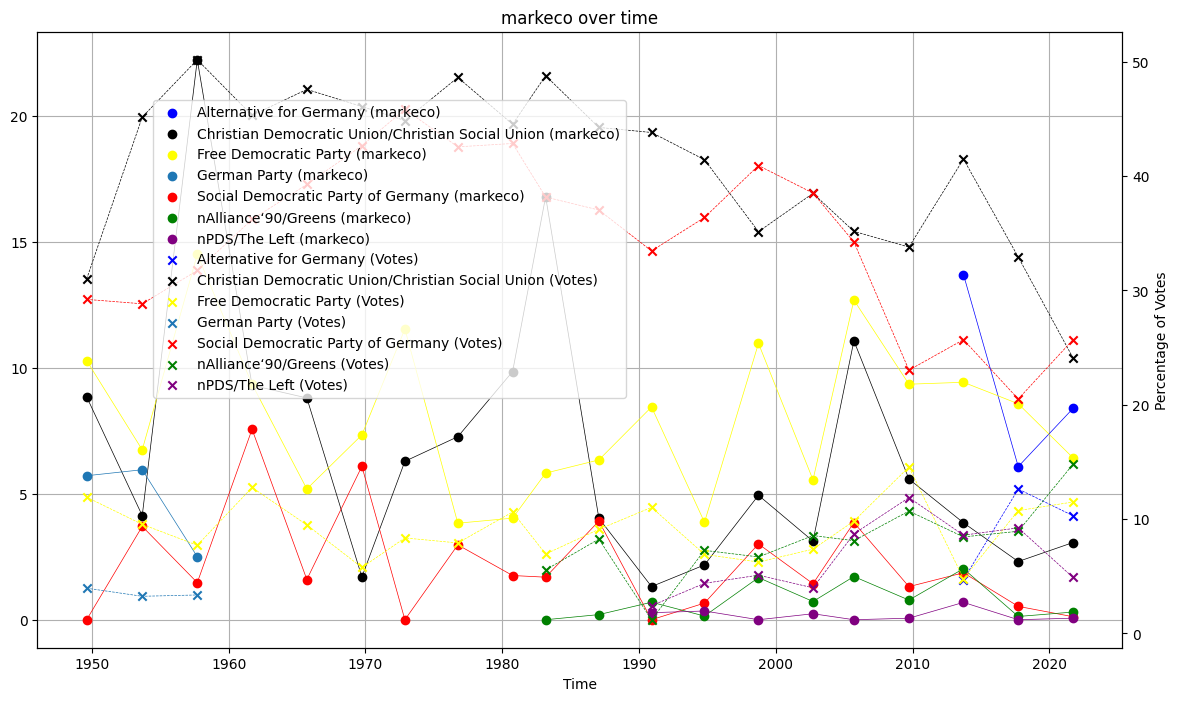

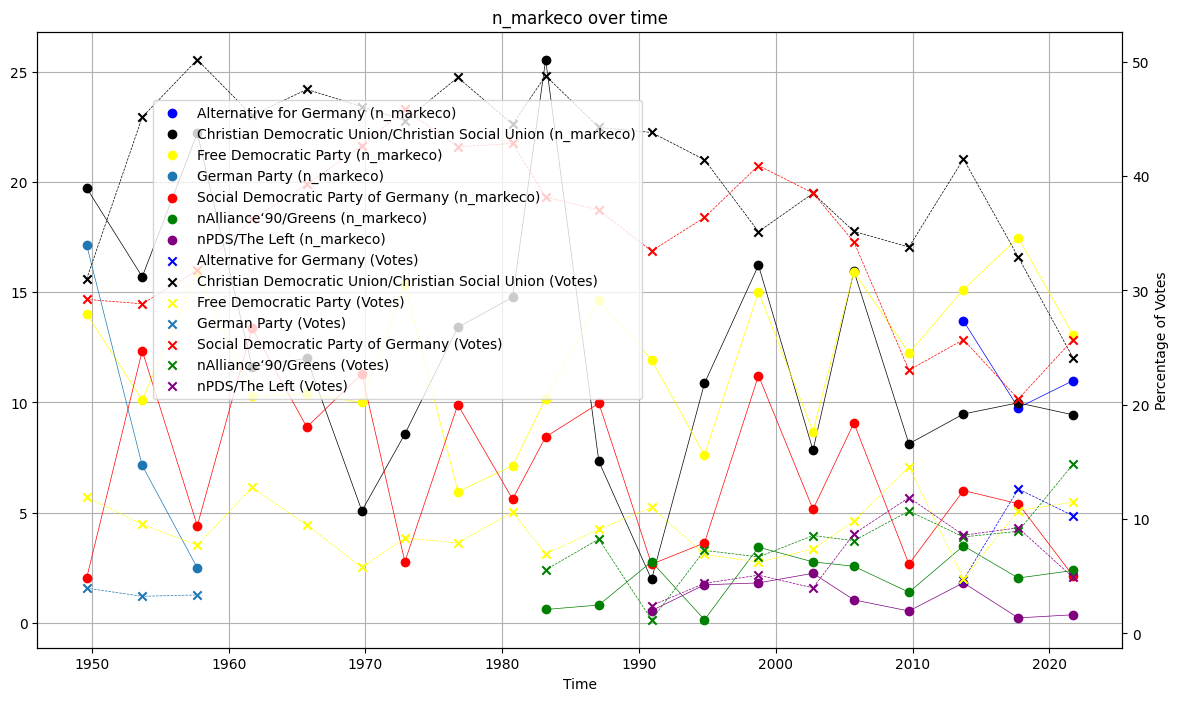

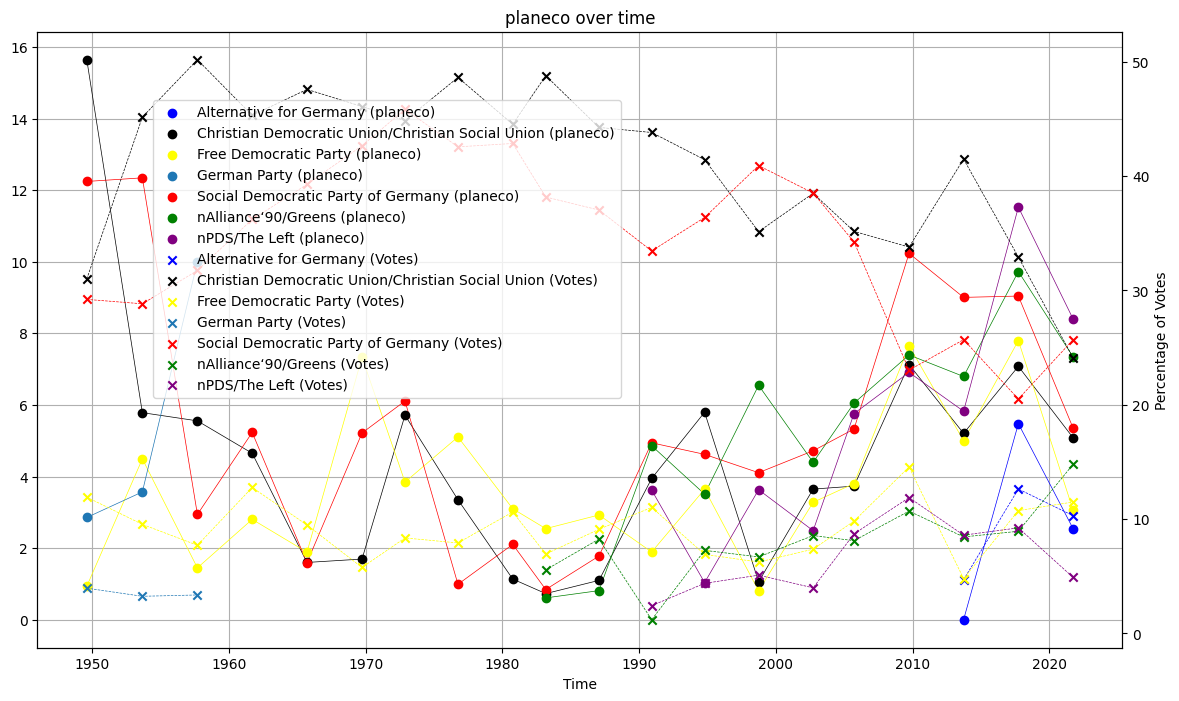

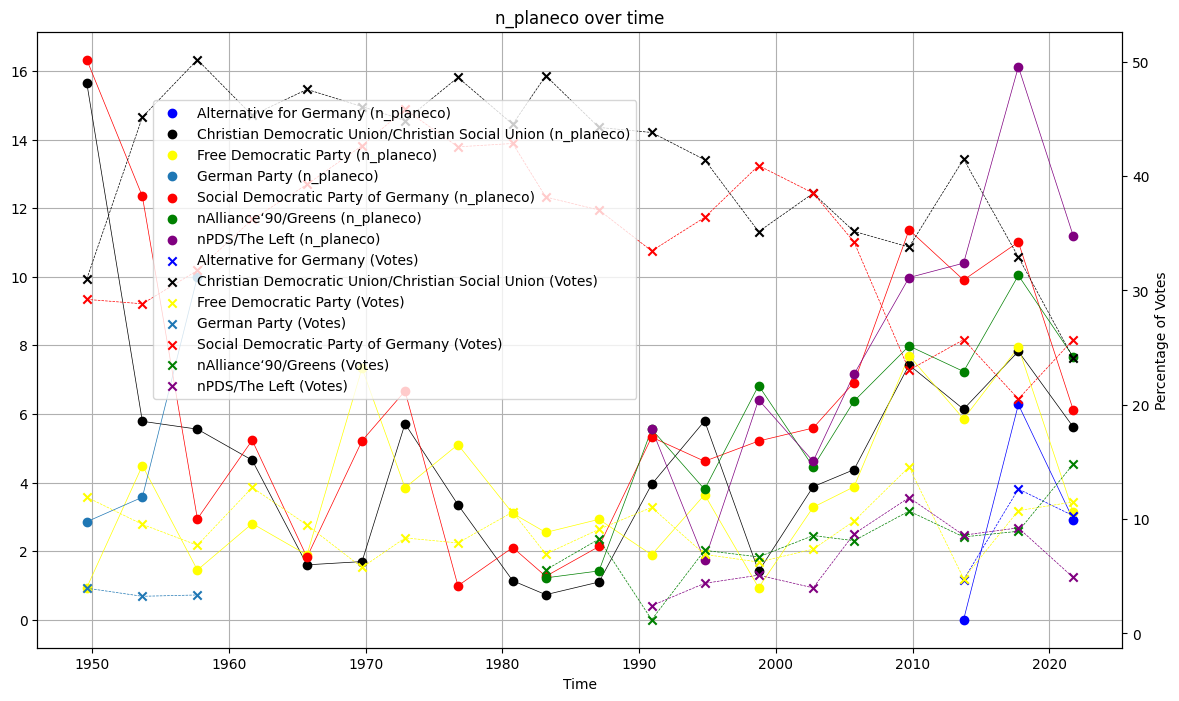

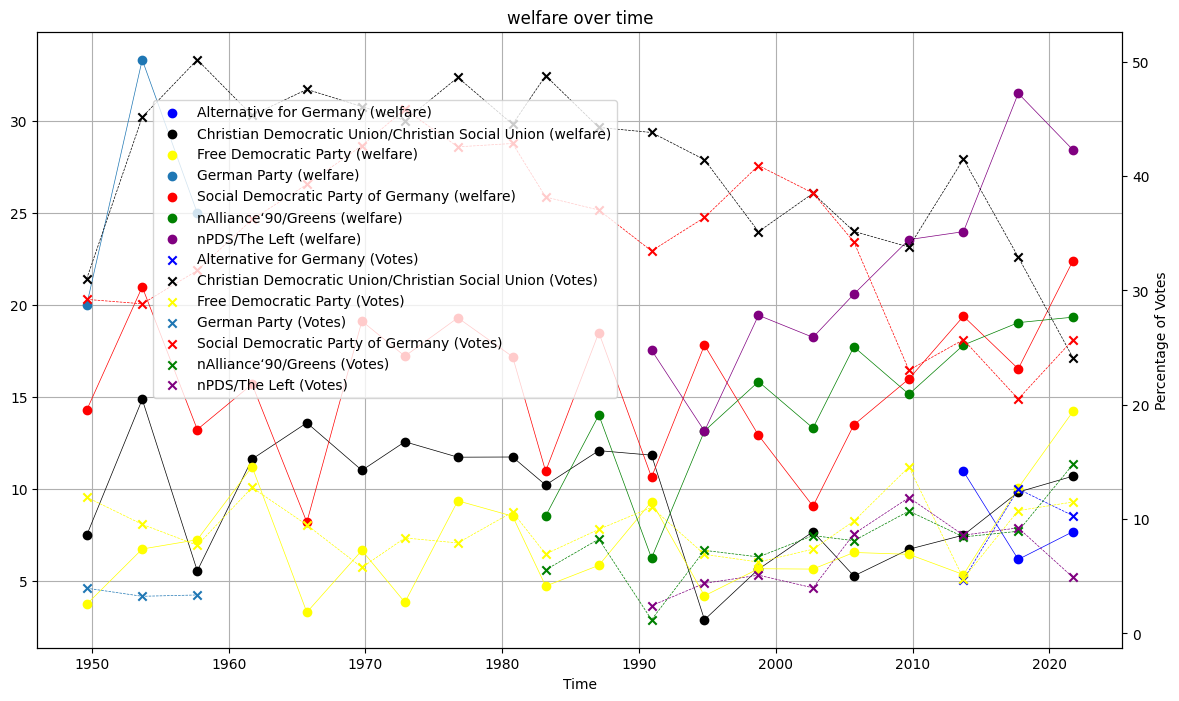

In [7]:
def plot_parameter_over_time(df, parameter, compare_votes=False, date_col='edate', party_col='partyname', color_dict=party_color_dict_germany):
    """
    Function to plot a numerical parameter over time, grouped by party.

    Parameters:
    - df: DataFrame containing the data
    - parameter: The column name of the numerical parameter to plot
    - compare_votes: Boolean flag to compare with percentage votes on a secondary y-axis (default: False)
    - date_col: Column name for the date (default: 'edate')
    - party_col: Column name for the party name (default: 'partyname' could also be partyabbrev)
    - color_dict: Dictionary mapping party names to colors (default: global party_color_dict_germany for german parties)
    """

    df.loc[:, date_col] = pd.to_datetime(df[date_col], format='%Y%m')

    # Pivot the dataframe to have 'date' as the index and 'partyname' as columns
    pivot_df = df.pivot(index=date_col, columns=party_col, values=parameter)
    votes_df = df.pivot(index=date_col, columns=party_col, values='pervote') if compare_votes else None

    # Plot the time series data with specified colors
    fig, ax1 = plt.subplots(figsize=(14, 8))

    ax1.set_title(f"{parameter} over time")
    ax1.set_xlabel('Time')
    ax1.set_ylabel(manifesto_coding_dict.get(parameter, None))

    for column in pivot_df.columns:
        party_data = pivot_df[column].dropna()
        if not party_data.empty:
            party_name = df[df[party_col] == column][party_col].values[0]
            color = color_dict.get(party_name, None) if color_dict else None
            ax1.scatter(party_data.index, party_data.values, label=f"{party_name} ({parameter})", color=color, zorder=5)
            ax1.plot(party_data.index, party_data.values, color=color, linewidth=0.5)

    if compare_votes and votes_df is not None:
        ax2 = ax1.twinx()
        ax2.set_ylabel('Percentage of Votes')

        for column in votes_df.columns:
            party_data = votes_df[column].dropna()
            if not party_data.empty:
                party_name = df[df[party_col] == column][party_col].values[0]
                color = color_dict.get(party_name, None) if color_dict else None
                ax2.scatter(party_data.index, party_data.values, label=f"{party_name} (Votes)", color=color, marker='x', zorder=5)
                ax2.plot(party_data.index, party_data.values, color=color, linewidth=0.5, linestyle='--')

    fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9), bbox_transform=ax1.transAxes)
    ax1.grid(True)
    plt.show()



#plot_parameter_over_time(df_new_manifesto_germany, 'per401')
#plot_parameter_over_time(df_new_manifesto_germany, 'per601', compare_votes = True) # seems that it correlates with AFD votes
plot_parameter_over_time(df_new_manifesto_germany, 'markeco', compare_votes = True)
plot_parameter_over_time(df_new_manifesto_germany, 'n_markeco', compare_votes = True)
plot_parameter_over_time(df_new_manifesto_germany, 'planeco', compare_votes = True)
plot_parameter_over_time(df_new_manifesto_germany, 'n_planeco', compare_votes = True)
plot_parameter_over_time(df_new_manifesto_germany, 'welfare', compare_votes = True)

## Multiple Regresssion

In [8]:
# Select relevant columns (parameters and votes)

parameters = ['markeco', 'planeco', 'welfare']

# should check for null values?

X = df_new_manifesto_germany[parameters]
y = df_new_manifesto_germany['pervote']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # the anwser to everything :D

# Initialize and fit the model
model = LinearRegression()
#model.fit(X_train, y_train)
# sgould use train test split?
model.fit(X, y)
"""
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

# Model performance
print('Train Mean Squared Error:', mean_squared_error(y_train, y_pred_train))
print('Test Mean Squared Error:', mean_squared_error(y_test, y_pred_test))
print('Train R^2:', r2_score(y_train, y_pred_train))
print('Test R^2:', r2_score(y_test, y_pred_test))
"""

y_pred = model.predict(X)

# Coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

# Model performance
print('Mean Squared Error:', mean_squared_error(y, y_pred))
print('R^2:', r2_score(y, y_pred))

# Interpreting the results
for param, coef in zip(parameters, model.coef_):
    print(f"If you increase {param} by 1 unit, the percentage of votes changes by {coef} units.")


         Coefficient
markeco     0.321735
planeco    -0.064802
welfare    -0.122947
Mean Squared Error: 250.38397527214198
R^2: 0.015828421256740444
If you increase markeco by 1 unit, the percentage of votes changes by 0.3217345257931318 units.
If you increase planeco by 1 unit, the percentage of votes changes by -0.06480192640791382 units.
If you increase welfare by 1 unit, the percentage of votes changes by -0.12294720275559552 units.


In [9]:
"""

# Residuals
residuals = y_test - y_pred_test

# Linearity
plt.scatter(y_pred_test, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Homoscedasticity
plt.scatter(y_pred_test, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Normality
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()
"""

'\n\n# Residuals\nresiduals = y_test - y_pred_test\n\n# Linearity\nplt.scatter(y_pred_test, residuals)\nplt.xlabel(\'Fitted Values\')\nplt.ylabel(\'Residuals\')\nplt.title(\'Residuals vs Fitted Values\')\nplt.show()\n\n# Homoscedasticity\nplt.scatter(y_pred_test, residuals)\nplt.xlabel(\'Fitted Values\')\nplt.ylabel(\'Residuals\')\nplt.title(\'Residuals vs Fitted Values\')\nplt.show()\n\n# Normality\nsns.histplot(residuals, kde=True)\nplt.title(\'Residuals Distribution\')\nplt.show()\n\n# Q-Q plot\nstats.probplot(residuals, dist="norm", plot=plt)\nplt.title(\'Q-Q Plot\')\nplt.show()\n'

Results for Social Democratic Party of Germany
         Coefficient
markeco     1.440677
planeco    -4.340376
welfare    -0.452632
Mean Squared Error: 25.530248959052198
R^2: 0.4829684595066085
If Social Democratic Party of Germany increases markeco by 1 unit, the percentage of votes changes by 1.4406774181783317 units.
If Social Democratic Party of Germany increases planeco by 1 unit, the percentage of votes changes by -4.340376305581019 units.
If Social Democratic Party of Germany increases welfare by 1 unit, the percentage of votes changes by -0.4526323486078474 units.




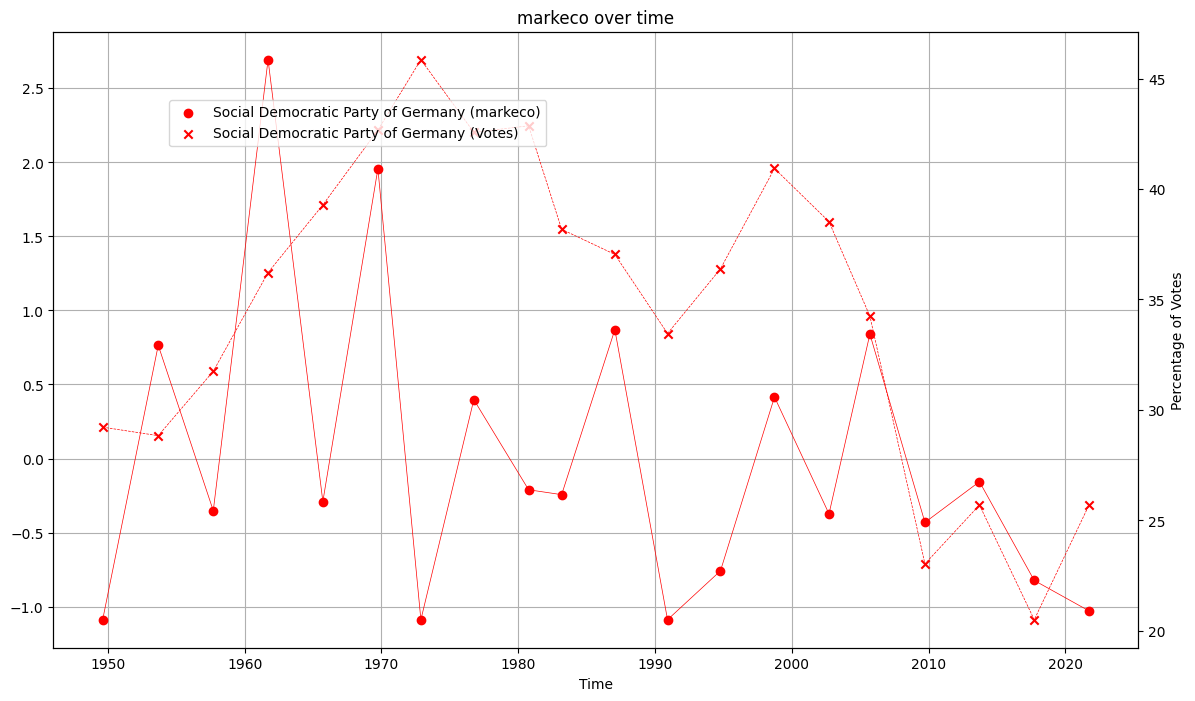

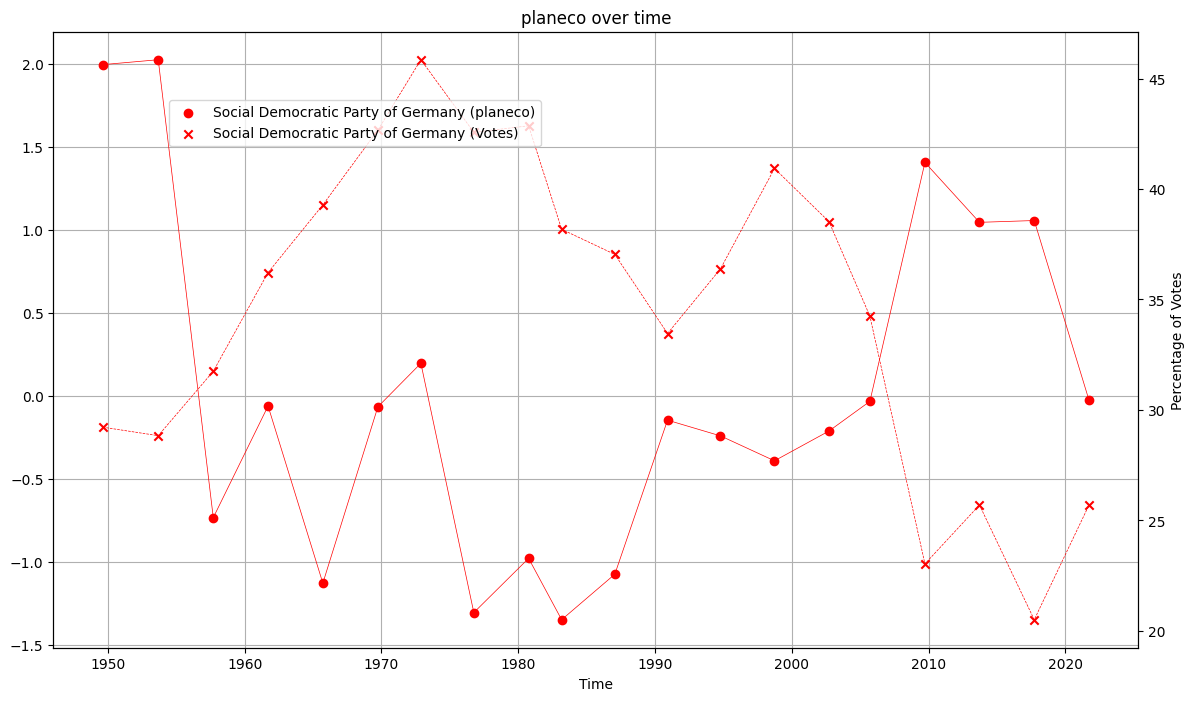

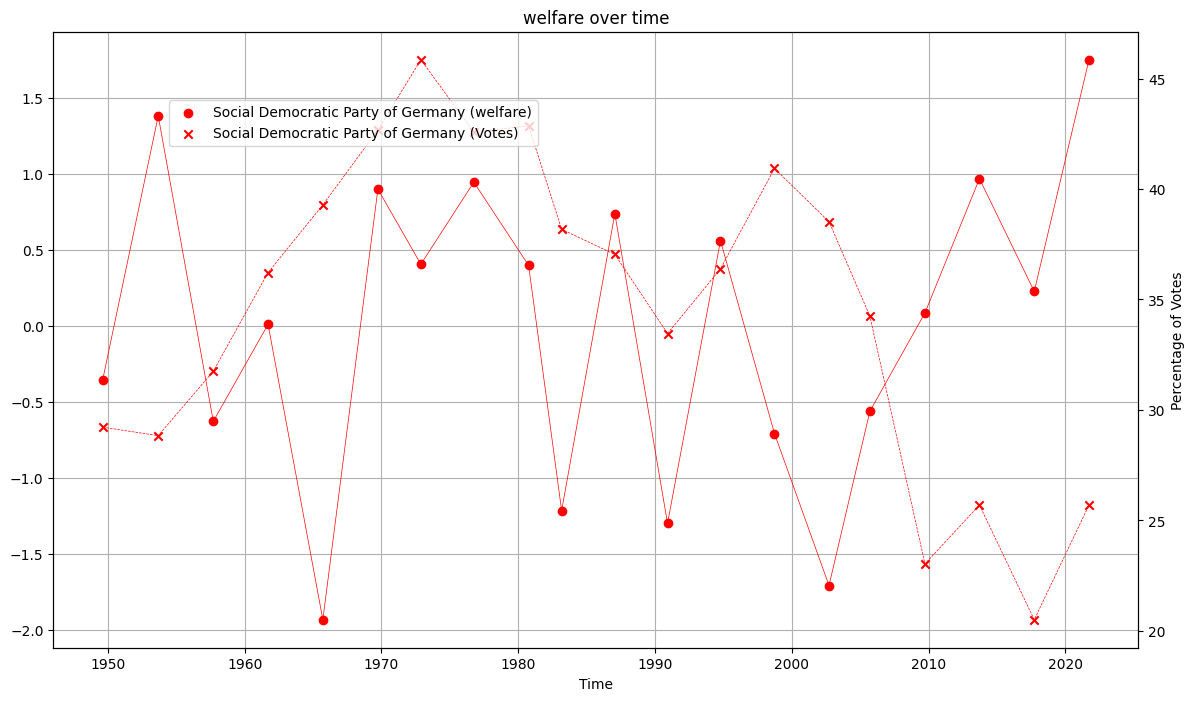

Results for Free Democratic Party
         Coefficient
markeco     0.273059
planeco     0.012896
welfare     1.032032
Mean Squared Error: 4.926946241145584
R^2: 0.1825584705508434
If Free Democratic Party increases markeco by 1 unit, the percentage of votes changes by 0.2730590163740566 units.
If Free Democratic Party increases planeco by 1 unit, the percentage of votes changes by 0.012895865173516485 units.
If Free Democratic Party increases welfare by 1 unit, the percentage of votes changes by 1.0320320717366807 units.




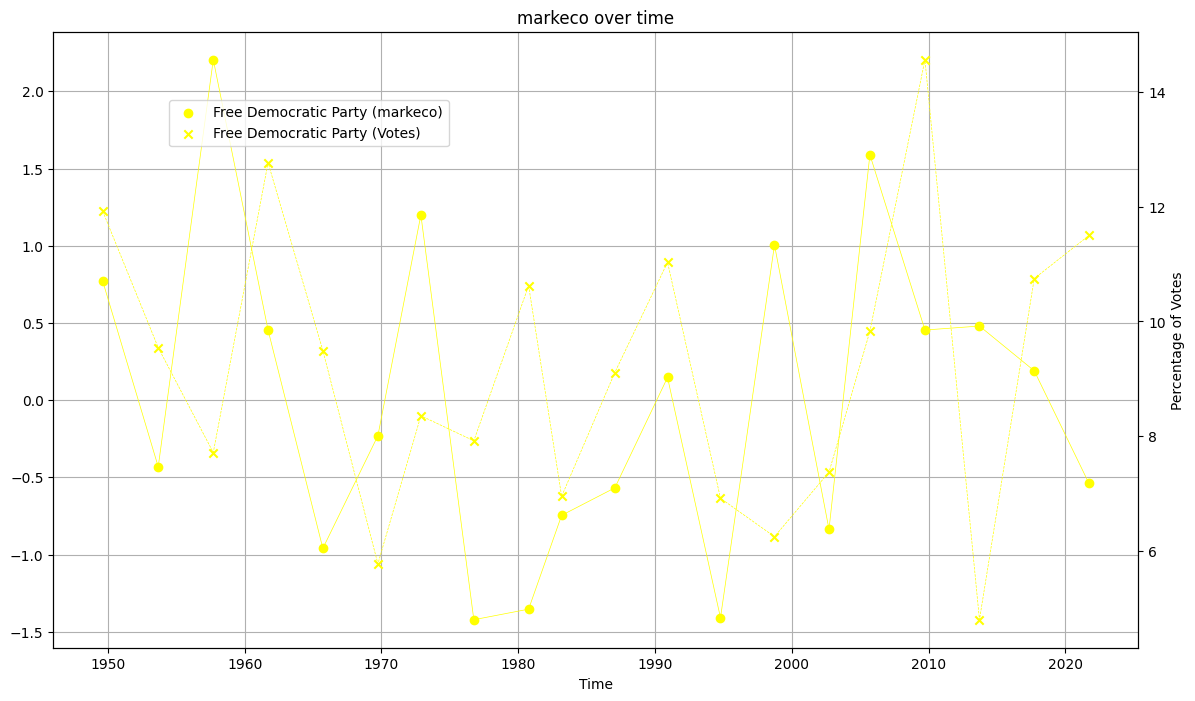

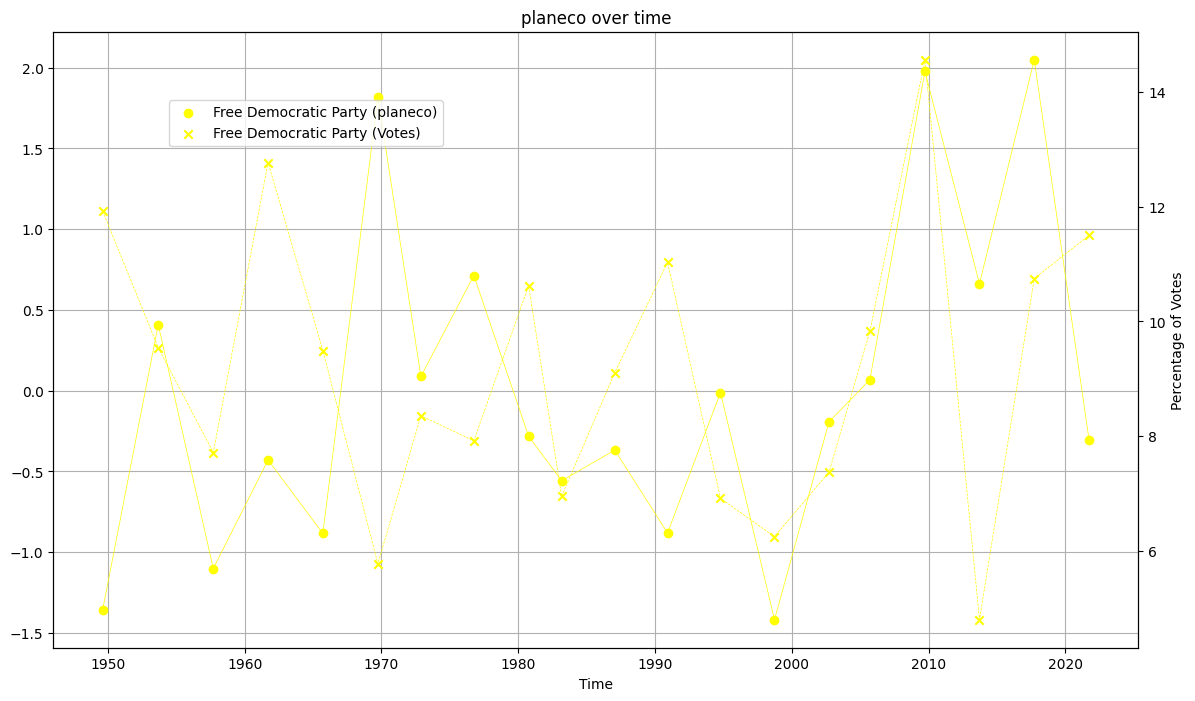

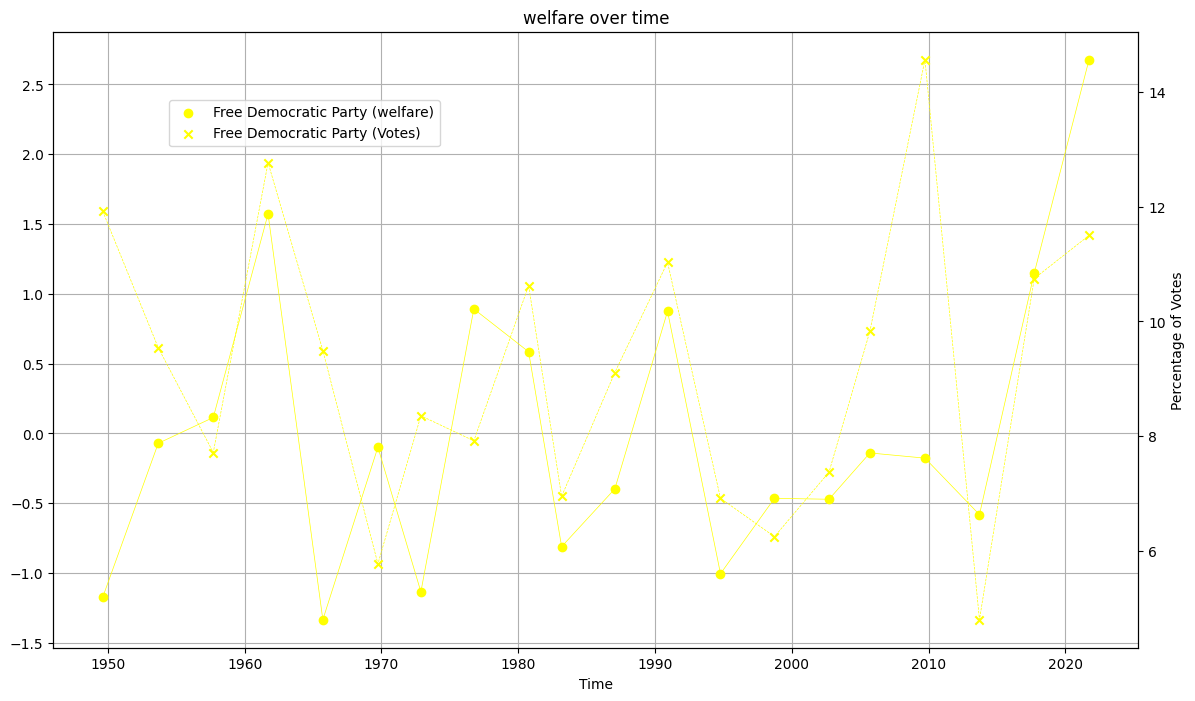

Results for Christian Democratic Union/Christian Social Union
         Coefficient
markeco     2.912483
planeco    -2.538446
welfare     2.230795
Mean Squared Error: 25.335209770760706
R^2: 0.45621117174509573
If Christian Democratic Union/Christian Social Union increases markeco by 1 unit, the percentage of votes changes by 2.912482867008253 units.
If Christian Democratic Union/Christian Social Union increases planeco by 1 unit, the percentage of votes changes by -2.538446051477482 units.
If Christian Democratic Union/Christian Social Union increases welfare by 1 unit, the percentage of votes changes by 2.230795343939647 units.




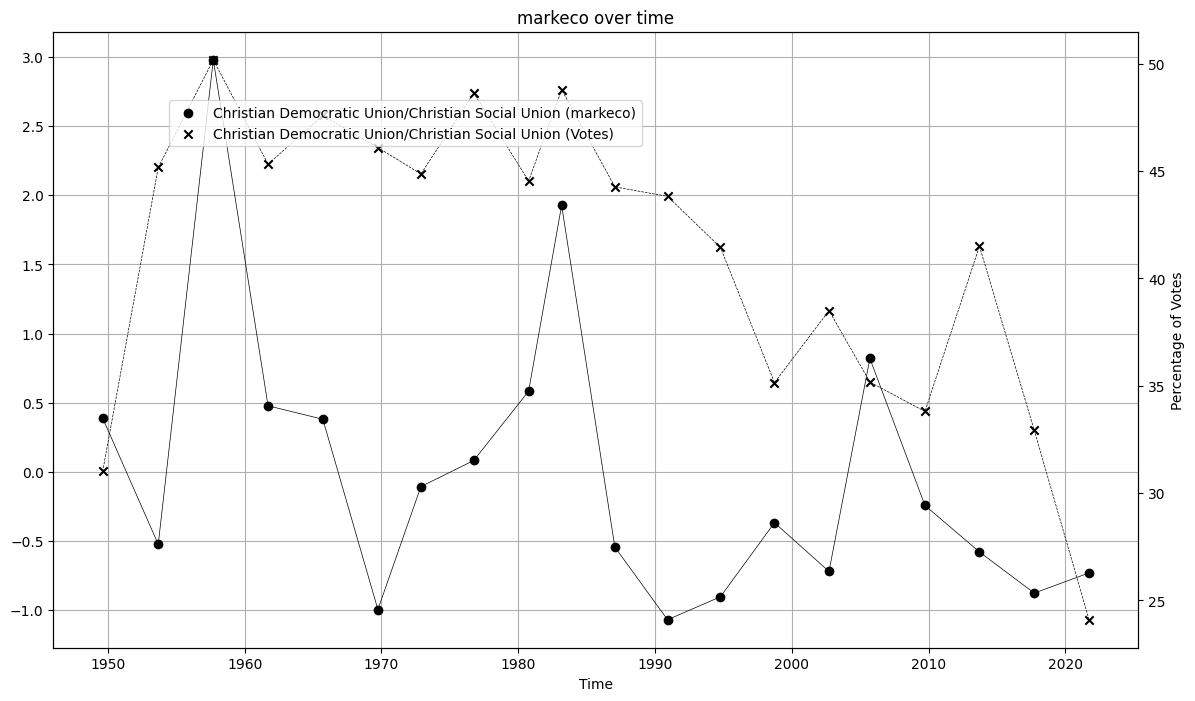

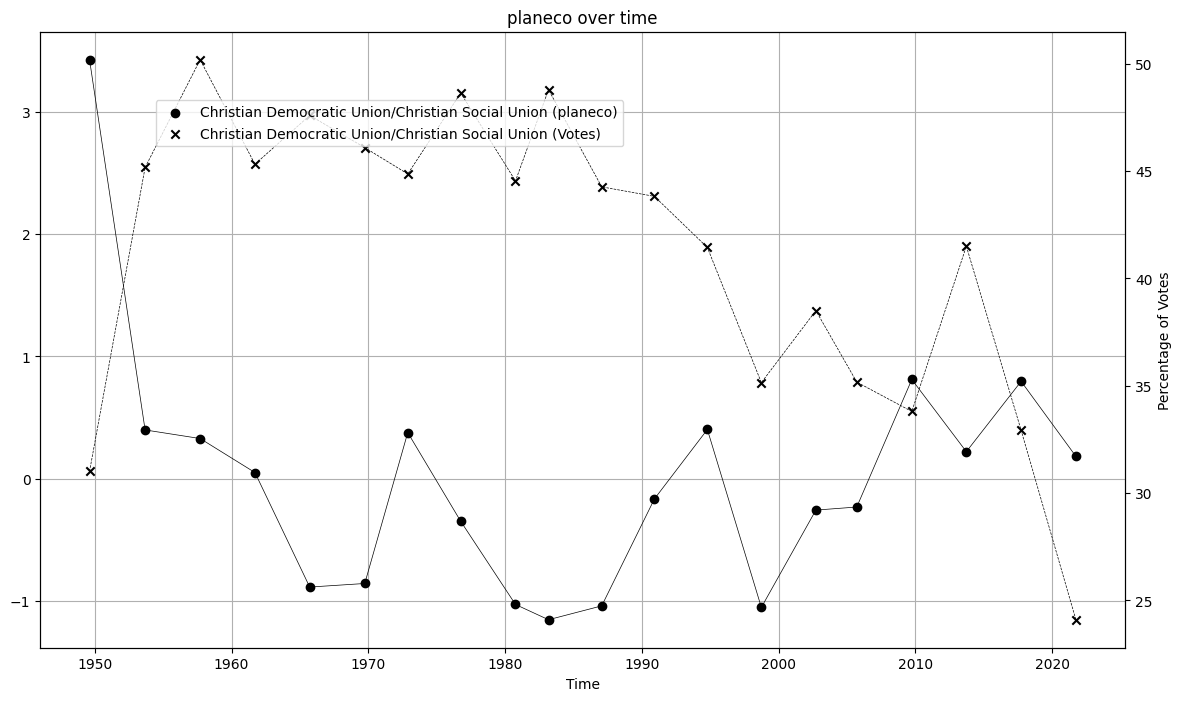

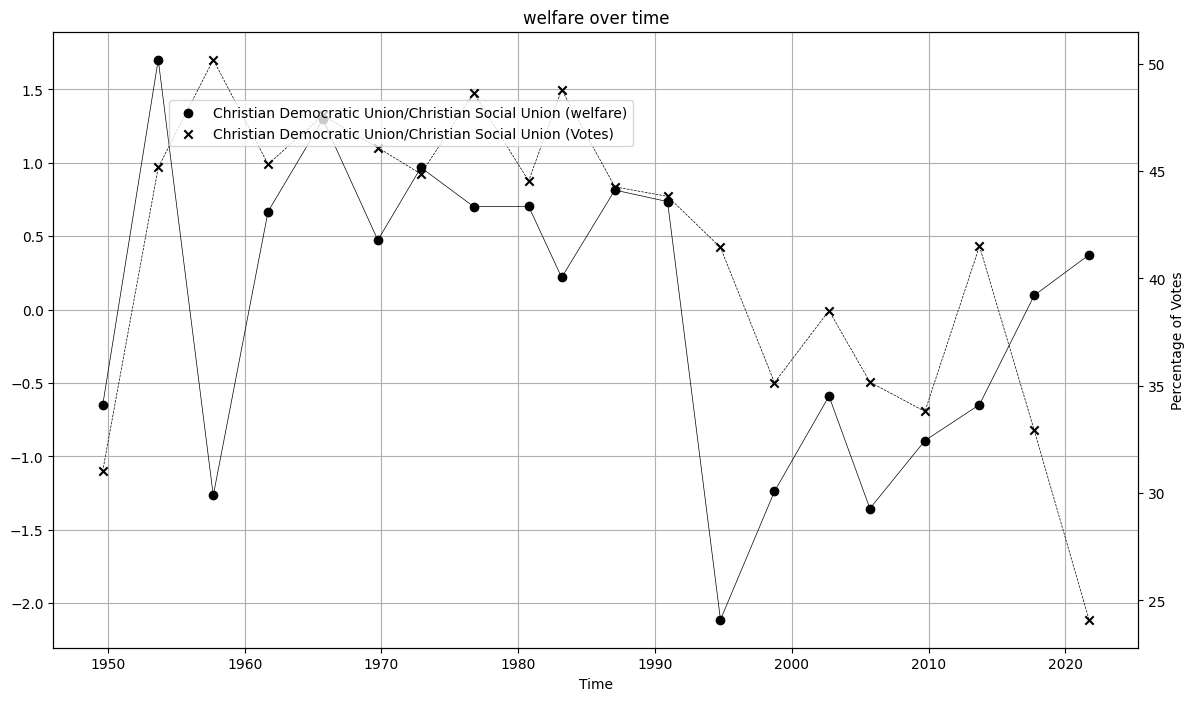

Results for German Party
         Coefficient
markeco     0.054266
planeco    -0.099807
welfare    -0.286268
Mean Squared Error: 0.0
R^2: 1.0
If German Party increases markeco by 1 unit, the percentage of votes changes by 0.054266107975038176 units.
If German Party increases planeco by 1 unit, the percentage of votes changes by -0.09980724736406724 units.
If German Party increases welfare by 1 unit, the percentage of votes changes by -0.28626801369539095 units.




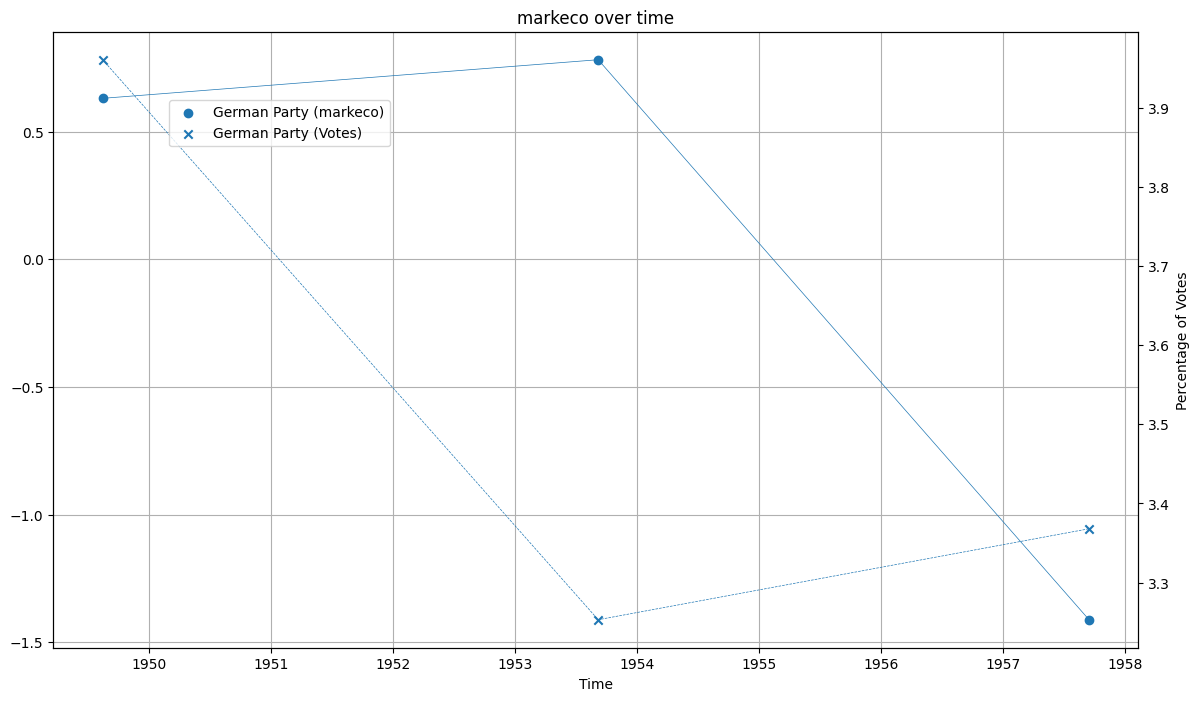

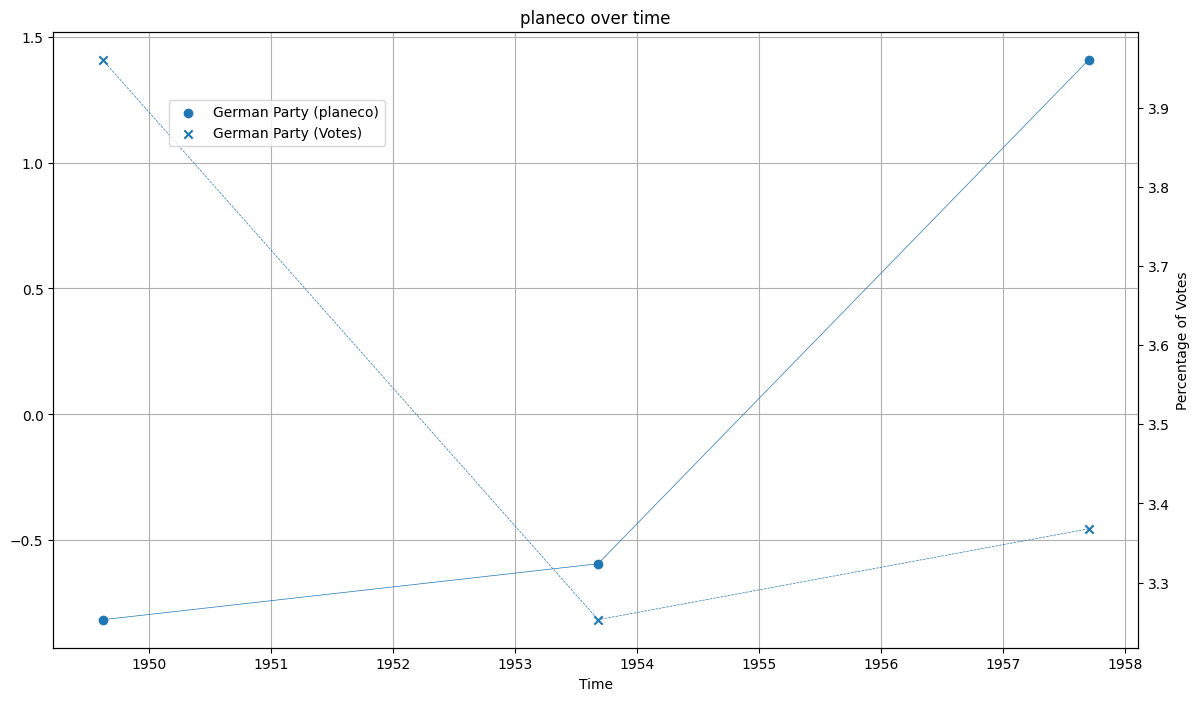

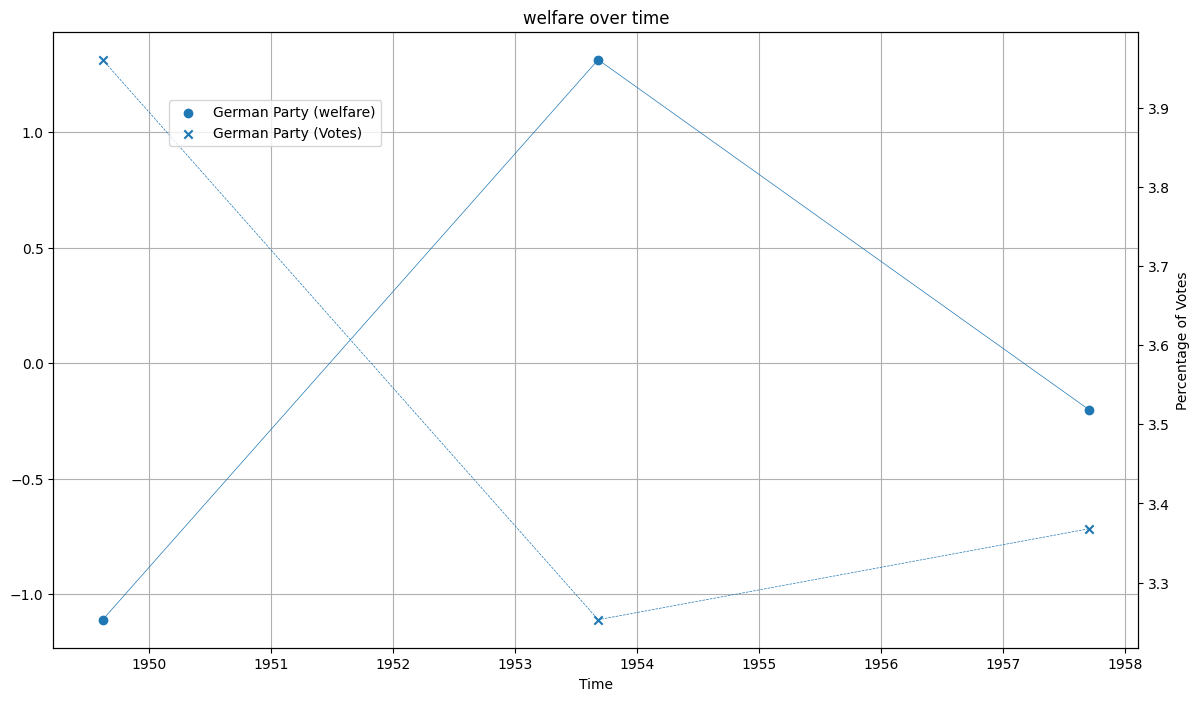

Results for nAlliance‘90/Greens
         Coefficient
markeco    -1.050458
planeco    -0.441667
welfare     3.132262
Mean Squared Error: 2.4331913158575875
R^2: 0.7552762898260127
If nAlliance‘90/Greens increases markeco by 1 unit, the percentage of votes changes by -1.0504578508240427 units.
If nAlliance‘90/Greens increases planeco by 1 unit, the percentage of votes changes by -0.44166687711260577 units.
If nAlliance‘90/Greens increases welfare by 1 unit, the percentage of votes changes by 3.132262340191662 units.




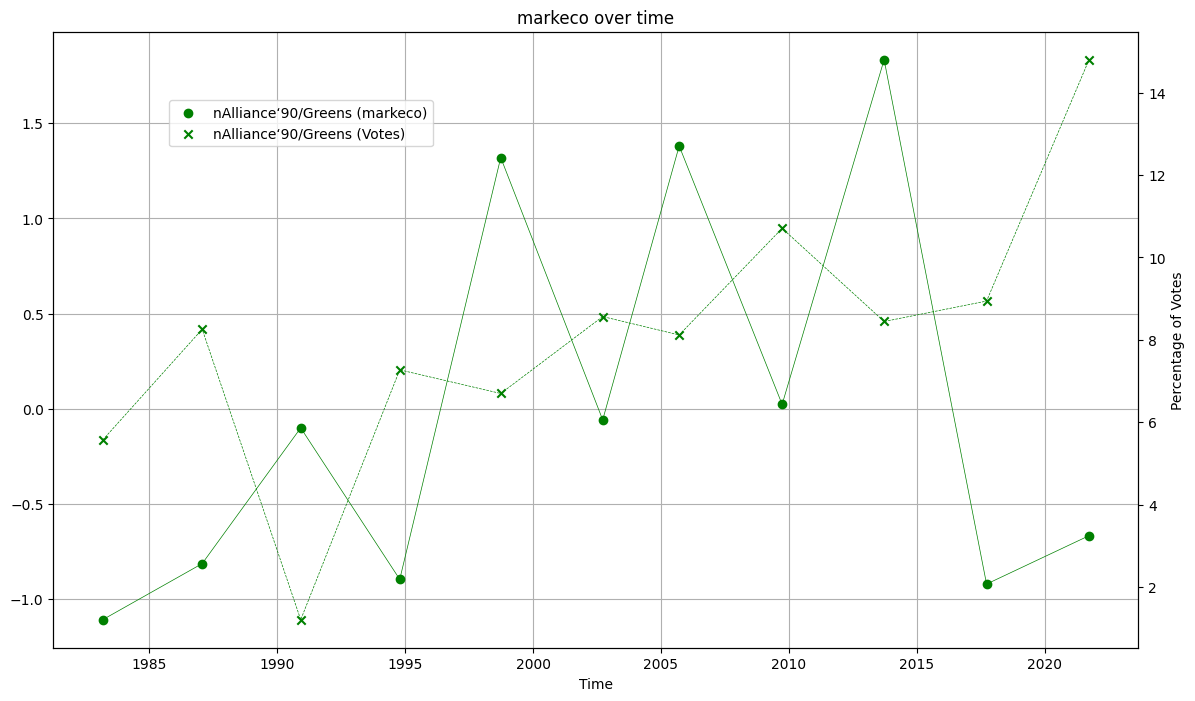

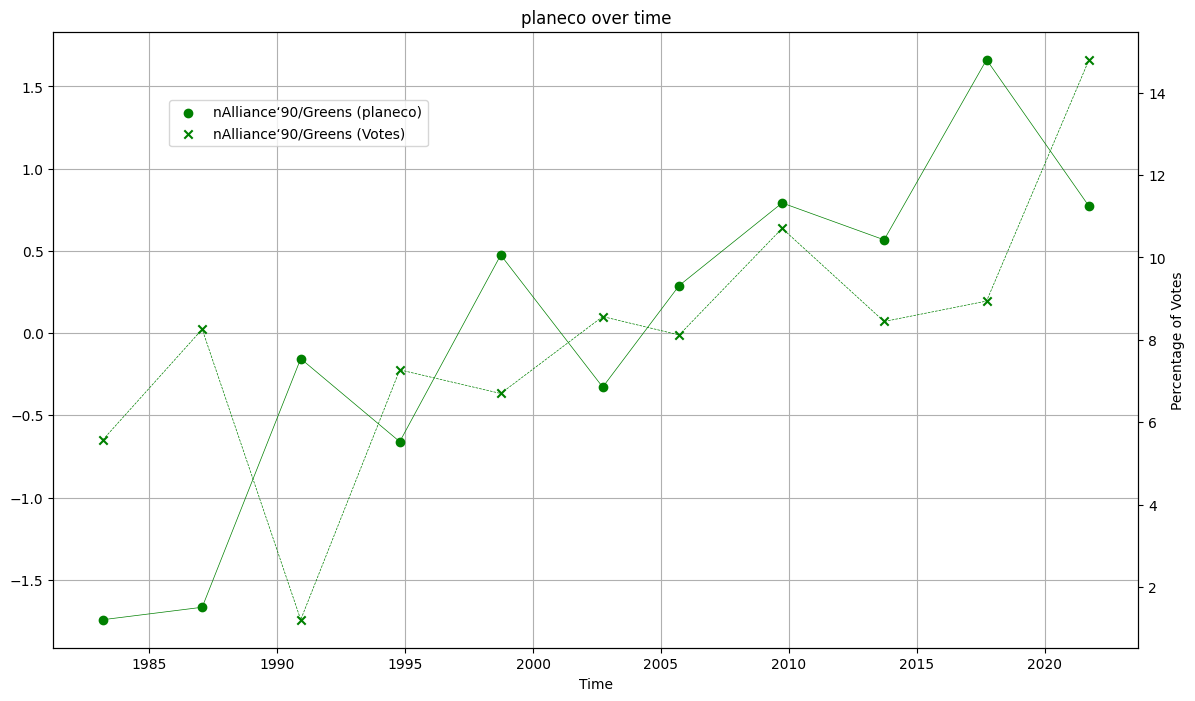

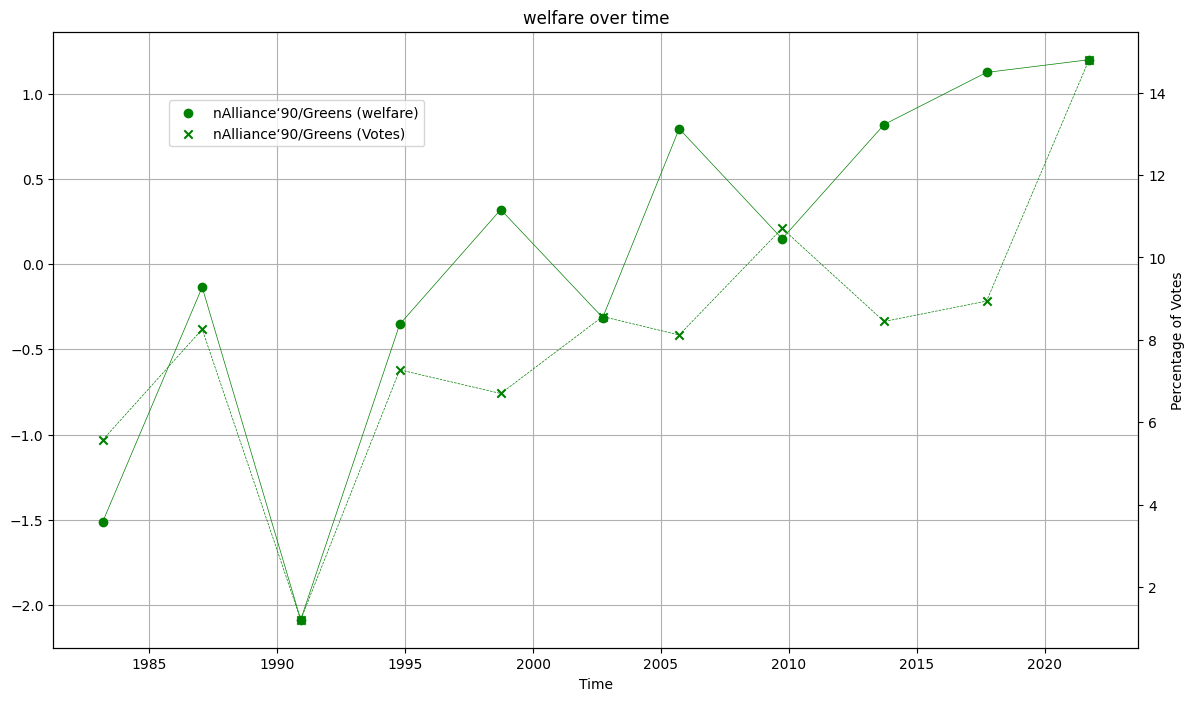

Results for nPDS/The Left
         Coefficient
markeco     0.522743
planeco     5.297892
welfare    -3.439773
Mean Squared Error: 4.918214175294714
R^2: 0.4294028092282769
If nPDS/The Left increases markeco by 1 unit, the percentage of votes changes by 0.5227432440682837 units.
If nPDS/The Left increases planeco by 1 unit, the percentage of votes changes by 5.297892478067887 units.
If nPDS/The Left increases welfare by 1 unit, the percentage of votes changes by -3.4397734317044777 units.




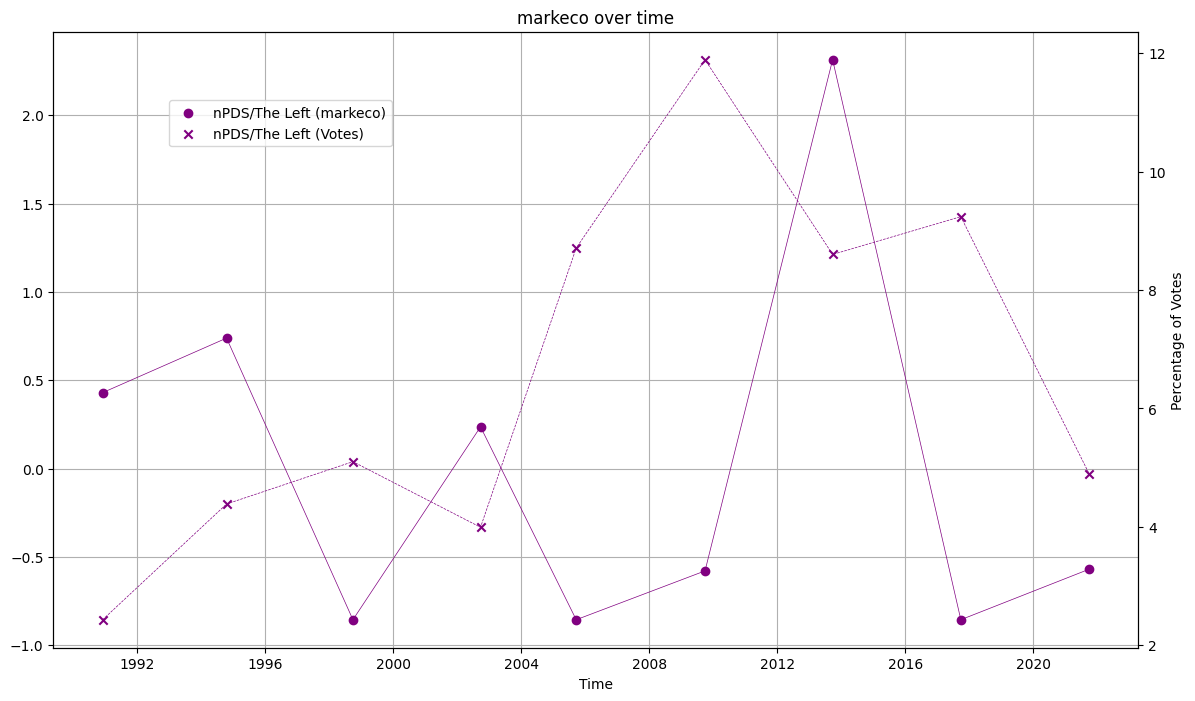

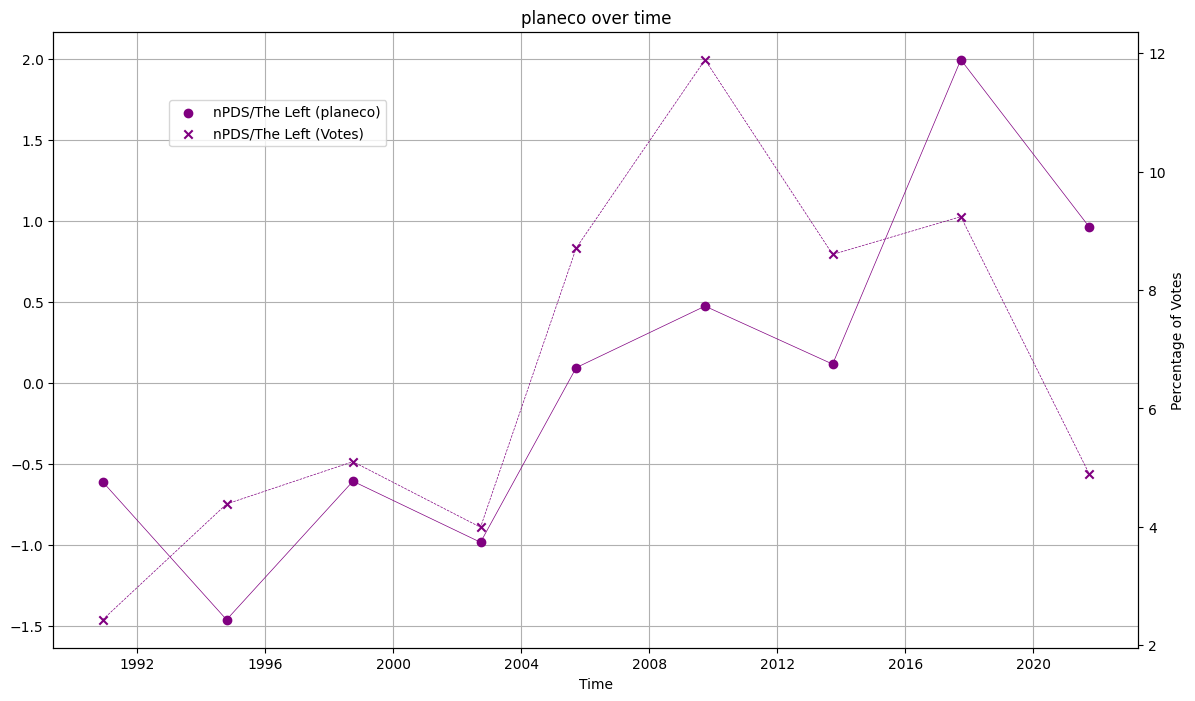

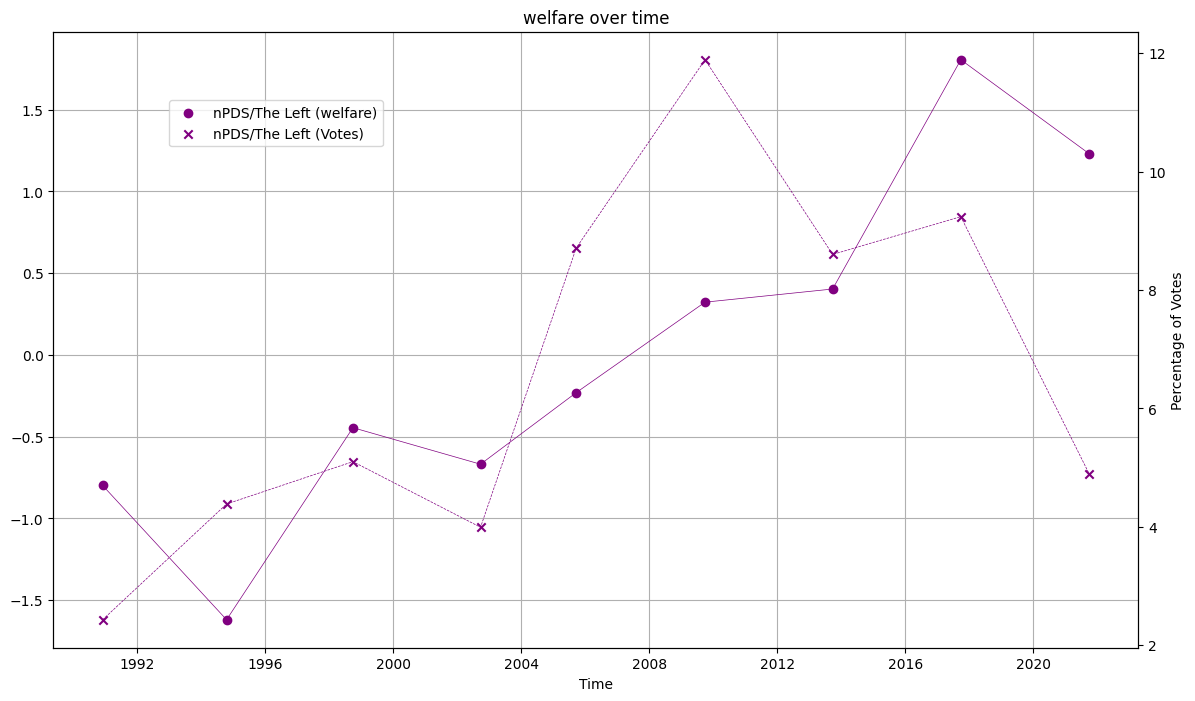

Results for Alternative for Germany
         Coefficient
markeco    -1.822039
planeco    -0.213204
welfare    -1.714023
Mean Squared Error: 2.629536350736706e-31
R^2: 1.0
If Alternative for Germany increases markeco by 1 unit, the percentage of votes changes by -1.8220393685825667 units.
If Alternative for Germany increases planeco by 1 unit, the percentage of votes changes by -0.21320417672373548 units.
If Alternative for Germany increases welfare by 1 unit, the percentage of votes changes by -1.714022800034439 units.




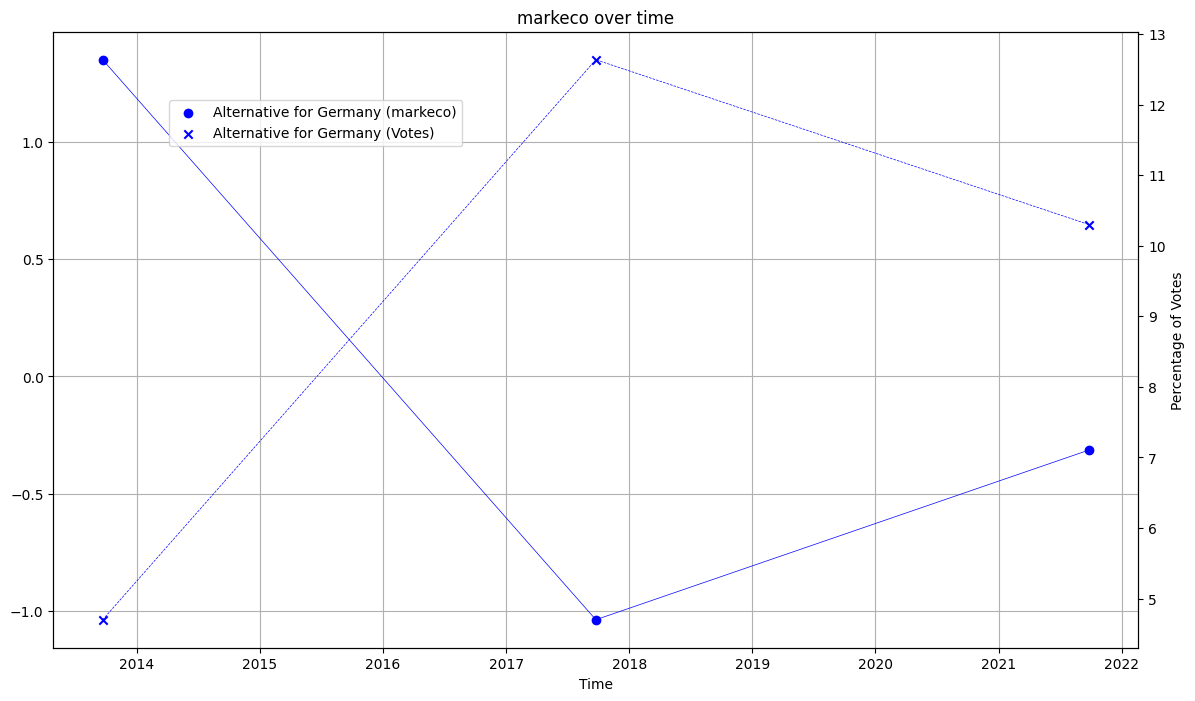

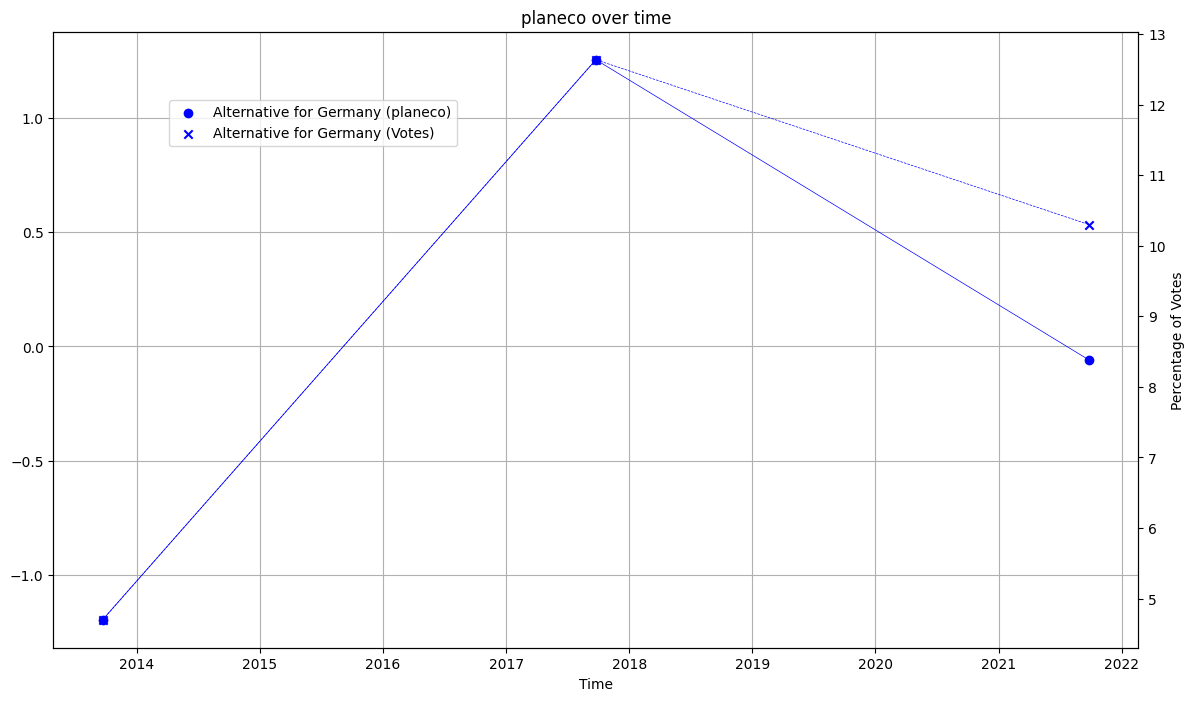

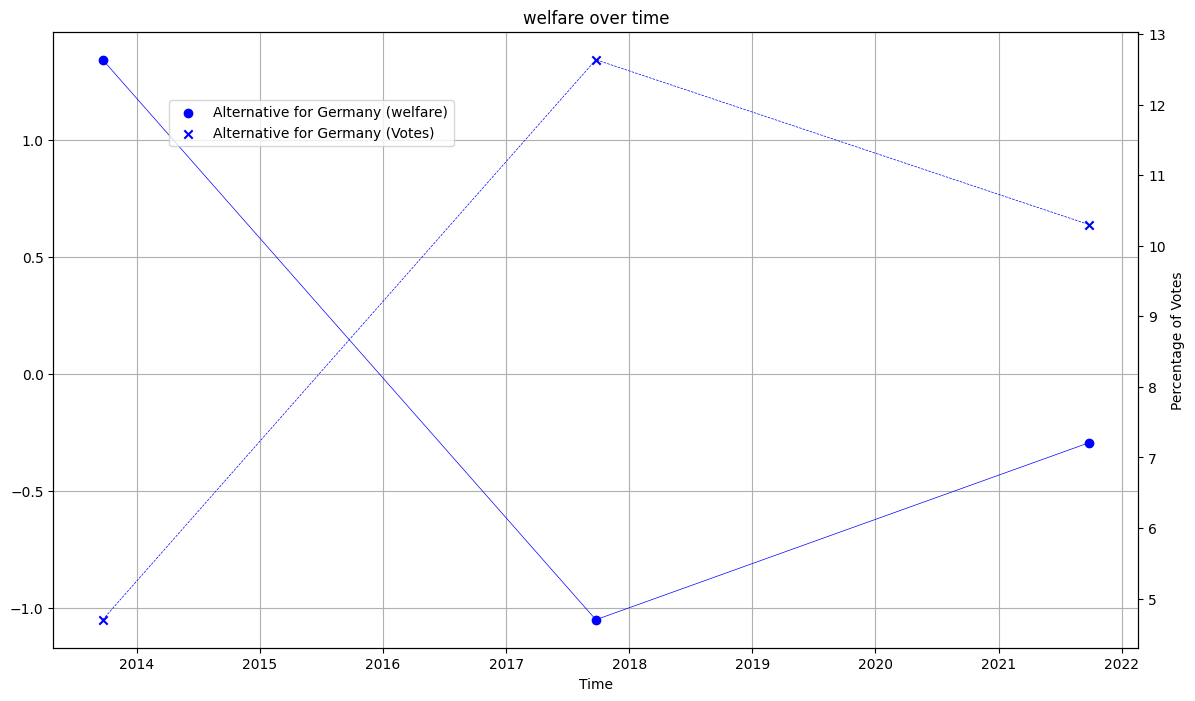

In [10]:

# Assuming df_new_manifesto_germany is already defined and cleaned

# Select relevant columns (parameters and votes)
parameters = ['markeco', 'planeco', 'welfare']
#parameters = ['markeco']

#df = df_new_manifesto_germany[['partyname', 'pervote'] + parameters].dropna()  # Drop rows with any missing values

# Check the data types and convert if necessary
#df[parameters] = df[parameters].apply(pd.to_numeric, errors='coerce')

def normalize_party_parameters(party_df, parameters=parameters):
    scaler = StandardScaler()
    party_df[parameters] = scaler.fit_transform(party_df[parameters])
    return party_df

# Function to perform regression for a single party
def analyze_party(df, party_name, parameters=parameters):
    # Filter the data for the specific party
    party_df = df[df['partyname'] == party_name].copy()
    
    #########
    # ONLY FOR PARTIES SO CHANGE WITHIN PARTY STANDRADS OTHERWISE SCALE WOULD BE SO DIFFERENT
    # FDP change of 1 for markeco is not as relevant as change of nPDST The Left for markeco 
    # -> normalization
    party_df = normalize_party_parameters(party_df, parameters) 
    
    # Define the independent variables (X) and dependent variable (y)
    X = party_df[parameters]
    y = party_df['pervote']

    # Initialize and fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Coefficients
    coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
    print(f"Results for {party_name}")
    print(coefficients)

    # Model performance
    print('Mean Squared Error:', mean_squared_error(y, y_pred))
    print('R^2:', r2_score(y, y_pred))

    # Interpreting the results
    for param, coef in zip(parameters, model.coef_):
        print(f"If {party_name} increases {param} by 1 unit, the percentage of votes changes by {coef} units.")
    
    print('\n')
    for param in parameters:
        plot_parameter_over_time(party_df, param, compare_votes = True)

# List of unique parties
unique_parties = df_new_manifesto_germany['partyname'].unique()

# Perform analysis for each party
for party in unique_parties:
    analyze_party(df_new_manifesto_germany, party, parameters)
    



In [11]:
"""
#gdp yearly 1950-
gdp_df = pd.read_excel(f"{data_folder}statistic_id4878_bruttoinlandsprodukt--bip--in-deutschland-1950-2023.xlsx")  # Ensure GDP data is in CSV with 'year' and 'gdp' columns
# gdp quarterly change 1991- 
gdp_change_df = pd.read_excel(f"{data_folder}bruttoinlandsprodukt_veraenderung.xlsx")  # Ensure GDP data is in CSV with 'year' and 'gdp' columns

# 3rd quarter 2020 is 01.07.2020 but actually it is 01.07.2020-30.09.2020 +8,9%
# Display the first few rows before cleaning
print("Before cleaning:")
print(gdp_change_df.head(10))

# gdp per capita 1991-
# not really needed change better
#gdp_per_capita_df = pd.read_csv(f"{data_folder}bruttoinlandsprodukt_einwohner.csv")  # Ensure GDP data is in CSV with 'year' and 'gdp' columns

# unemployment yearly 1950-
unemployment_df = pd.read_excel(f"{data_folder}statistic_id1127090_arbeitslosigkeit-in-deutschland-1950-bis-2023.xlsx")

# infaltion yearly 1950-
inflation_df = pd.read_excel(f"{data_folder}statistic_id4917_inflationsrate-in-deutschland-von-1950-bis-2023.xlsx")

# DAX monthly 1988-
dax_df = pd.read_csv(f"{data_folder}DAX Historische Daten.csv")

# infratest dimap survey / poll "Sonntagsfrage" more than monthly 2000-
survey_df = pd.read_excel(f"{data_folder}statistic_id1227103_ergebnisse-der-sonntagsfrage-seit-der-bundestagswahl-2000-bis-2024.xlsx")
"""

'\n#gdp yearly 1950-\ngdp_df = pd.read_excel(f"{data_folder}statistic_id4878_bruttoinlandsprodukt--bip--in-deutschland-1950-2023.xlsx")  # Ensure GDP data is in CSV with \'year\' and \'gdp\' columns\n# gdp quarterly change 1991- \ngdp_change_df = pd.read_excel(f"{data_folder}bruttoinlandsprodukt_veraenderung.xlsx")  # Ensure GDP data is in CSV with \'year\' and \'gdp\' columns\n\n# 3rd quarter 2020 is 01.07.2020 but actually it is 01.07.2020-30.09.2020 +8,9%\n# Display the first few rows before cleaning\nprint("Before cleaning:")\nprint(gdp_change_df.head(10))\n\n# gdp per capita 1991-\n# not really needed change better\n#gdp_per_capita_df = pd.read_csv(f"{data_folder}bruttoinlandsprodukt_einwohner.csv")  # Ensure GDP data is in CSV with \'year\' and \'gdp\' columns\n\n# unemployment yearly 1950-\nunemployment_df = pd.read_excel(f"{data_folder}statistic_id1127090_arbeitslosigkeit-in-deutschland-1950-bis-2023.xlsx")\n\n# infaltion yearly 1950-\ninflation_df = pd.read_excel(f"{data_folde

## economic data

In [12]:
#gdp yearly 1950-
gdp_df = pd.read_excel(f"{data_folder}statistic_id4878_bruttoinlandsprodukt--bip--in-deutschland-1950-2023.xlsx")
print("GDP Annual Data:")
print(gdp_df.head())

# gdp change quarterly
# 3rd quarter 2020 is 01.07.2020 but actually it is 01.07.2020-30.09.2020 +8,9%
# Display the first few rows before cleaning
gdp_change_df = pd.read_excel(f"{data_folder}bruttoinlandsprodukt_veraenderung.xlsx")
print("\nGDP Quarterly Change Data (Before Cleaning):")
print(gdp_change_df.head(10))

# gdp per capita 1991-
# not really needed change better
#gdp_per_capita_df = pd.read_csv(f"{data_folder}bruttoinlandsprodukt_einwohner.csv")
#print("\nGDP per Capita Data:")
#print(gdp_per_capita_df.head())

# unemployment yearly 1950-
unemployment_df = pd.read_excel(f"{data_folder}statistic_id1127090_arbeitslosigkeit-in-deutschland-1950-bis-2023.xlsx")
print("\nUnemployment Data:")
print(unemployment_df.head())

# infaltion yearly 1950-
inflation_df = pd.read_excel(f"{data_folder}statistic_id4917_inflationsrate-in-deutschland-von-1950-bis-2023.xlsx")
print("\nInflation Data:")
print(inflation_df.head())

# DAX monthly 1988-
dax_df = pd.read_csv(f"{data_folder}DAX Historische Daten.csv")
print("\nDAX Data:")
print(dax_df.head())

# infratest dimap survey / poll "Sonntagsfrage" more than monthly 2000-
survey_df = pd.read_excel(f"{data_folder}statistic_id1227103_ergebnisse-der-sonntagsfrage-seit-der-bundestagswahl-2000-bis-2024.xlsx")
print("\nSurvey Data:")
print(survey_df.head())

GDP Annual Data:
   year  BIP (in billion €)
0  2023             4194.65
1  2022             3962.15
2  2021             3673.81
3  2020             3449.62
4  2019             3534.88

GDP Quarterly Change Data (Before Cleaning):
              Quartal  Preisbereinigt (zum Vorjahresquartal)  \
0 1991-01-01 01:00:00                                    NaN   
1 1991-04-01 02:00:00                                    NaN   
2 1991-07-01 02:00:00                                    NaN   
3 1991-10-01 01:00:00                                    NaN   
4 1992-01-01 01:00:00                                    2.9   
5 1992-04-01 02:00:00                                    1.4   
6 1992-07-01 02:00:00                                    2.0   
7 1992-10-01 01:00:00                                    1.4   
8 1993-01-01 01:00:00                                   -2.4   
9 1993-04-01 02:00:00                                   -0.7   

   Preis-, saison- und kalenderbereinigt (zum Vorquartal)  
0   

In [13]:
cleaned_data_folder = os.path.join(data_folder, 'cleaned_data')

plots_folder = os.path.join(data_folder, 'images')

## gdp_df preprocessing

In [14]:
# Load GDP Annual Data
gdp_df = pd.read_excel(f"{data_folder}statistic_id4878_bruttoinlandsprodukt--bip--in-deutschland-1950-2023.xlsx")

# Inspect initial rows
print("GDP Annual Data (Before Cleaning):")
print(gdp_df.head())

# Rename columns to English
gdp_df.rename(columns={'year': 'Year', 'BIP (in billion €)': 'GDP_billion_EUR'}, inplace=True)

# Convert 'Year' to integer
gdp_df['Year'] = gdp_df['Year'].astype(int)

# Display cleaned data
print("\nCleaned GDP Annual Data:")
print(gdp_df.head())

# Save the cleaned DataFrame
gdp_df.to_csv(os.path.join(cleaned_data_folder, 'cleaned_df_gdp_annual.csv'), index=False)
gdp_df.to_excel(os.path.join(cleaned_data_folder, 'cleaned_df_gdp_annual.xlsx'), index=False)

GDP Annual Data (Before Cleaning):
   year  BIP (in billion €)
0  2023             4194.65
1  2022             3962.15
2  2021             3673.81
3  2020             3449.62
4  2019             3534.88

Cleaned GDP Annual Data:
   Year  GDP_billion_EUR
0  2023          4194.65
1  2022          3962.15
2  2021          3673.81
3  2020          3449.62
4  2019          3534.88


## gdp_change_df preprocessing

In [15]:
# Load GDP Quarterly Change Data
gdp_change_df = pd.read_excel(f"{data_folder}bruttoinlandsprodukt_veraenderung.xlsx")

# Inspect initial rows
print("\nGDP Quarterly Change Data (Before Cleaning):")
print(gdp_change_df.head(10))

# Rename columns to English
gdp_change_df.rename(columns={
    'Quartal': 'Quarter',
    'Preisbereinigt (zum Vorjahresquartal)': 'GDP_Previous_Year_Quarter_Adjusted',
    'Preis-, saison- und kalenderbereinigt (zum Vorquartal)': 'GDP_Previous_Quarterly_Adjusted'
}, inplace=True)

# Remove rows where 'GDP_Previous_Quarterly_Adjusted' is NaN (i.e., rows with only one column)
#gdp_change_df_clean = gdp_change_df.dropna(subset=['GDP_Previous_Quarterly_Adjusted']).copy()
gdp_change_df_clean = gdp_change_df

# Convert 'Quarter' to datetime without time components
gdp_change_df_clean['Date'] = pd.to_datetime(
    gdp_change_df_clean['Quarter'], format='%d.%m.%Y %H:%M', errors='coerce'
).dt.date



# Extract Year and Quarter Number
gdp_change_df_clean['Year'] = pd.to_datetime(gdp_change_df_clean['Date']).dt.year
gdp_change_df_clean['Quarter_Num'] = pd.to_datetime(gdp_change_df_clean['Date']).dt.quarter

# Convert 'GDP_Previous_Quarterly_Adjusted' to float
gdp_change_df_clean['GDP_Previous_Quarterly_Adjusted'] = gdp_change_df_clean['GDP_Previous_Quarterly_Adjusted'].astype(float)


# Function to get end-of-quarter date
def get_end_of_quarter(date):
    if date.month == 1:
        return datetime(date.year, 3, 31).date()
    elif date.month == 4:
        return datetime(date.year, 6, 30).date()
    elif date.month == 7:
        return datetime(date.year, 9, 30).date()
    elif date.month == 10:
        return datetime(date.year, 12, 31).date()
    else:
        return date  # If not a quarter-start month

# Add end-of-quarter date
gdp_change_df_clean['End_Quarter_Date'] = gdp_change_df_clean['Date'].apply(get_end_of_quarter)

# Create a copy with end-of-quarter dates
gdp_change_eoq_df = gdp_change_df_clean.copy()
gdp_change_eoq_df['Date'] = gdp_change_eoq_df['End_Quarter_Date']

# Drop the 'End_Quarter_Date' column as it's now incorporated into 'Date'
gdp_change_eoq_df.drop(columns=['End_Quarter_Date'], inplace=True)

# Concatenate original and end-of-quarter DataFrames
gdp_change_full_df = pd.concat([gdp_change_df_clean, gdp_change_eoq_df], ignore_index=True)

# Drop duplicates if any
gdp_change_full_df.drop_duplicates(subset=['Date'], inplace=True)

# Sort by Date
gdp_change_full_df.sort_values(by='Date', inplace=True)

# Reset index
gdp_change_full_df.reset_index(drop=True, inplace=True)

gdp_change_full_df['Date'] = pd.to_datetime(gdp_change_full_df['Date'])

# Resample GDP data to monthly frequency, filling missing months with the previous value
gdp_change_full_df = gdp_change_full_df.set_index('Date').resample('M').ffill()
# Calculate the 3-month rolling average
gdp_change_full_df['GDP_3M_Floating_Average'] = gdp_change_full_df['GDP_Previous_Year_Quarter_Adjusted'].rolling(window=3).mean()
# 3M quarter before

# Reset index to have 'Date' back as a column
gdp_change_full_df.reset_index(inplace=True)

filter_date = datetime.strptime('30.06.2024', '%d.%m.%Y').date()
filter_date = pd.to_datetime(filter_date)
gdp_change_full_df = gdp_change_full_df[gdp_change_full_df['Date'] <= filter_date]


# Display cleaned data
print("\nCleaned GDP Quarterly Change Data:")
print(gdp_change_full_df.head())

# Save the cleaned DataFrame
gdp_change_full_df.to_csv(os.path.join(cleaned_data_folder, 'cleaned_df_gdp_quarterly_monthly_change.csv'), index=False)
gdp_change_full_df.to_excel(os.path.join(cleaned_data_folder, 'cleaned_df_gdp_quarterly_monthly_change.xlsx'), index=False)


GDP Quarterly Change Data (Before Cleaning):
              Quartal  Preisbereinigt (zum Vorjahresquartal)  \
0 1991-01-01 01:00:00                                    NaN   
1 1991-04-01 02:00:00                                    NaN   
2 1991-07-01 02:00:00                                    NaN   
3 1991-10-01 01:00:00                                    NaN   
4 1992-01-01 01:00:00                                    2.9   
5 1992-04-01 02:00:00                                    1.4   
6 1992-07-01 02:00:00                                    2.0   
7 1992-10-01 01:00:00                                    1.4   
8 1993-01-01 01:00:00                                   -2.4   
9 1993-04-01 02:00:00                                   -0.7   

   Preis-, saison- und kalenderbereinigt (zum Vorquartal)  
0                                                NaN       
1                                               -0.5       
2                                               -0.2       
3        

## gdp_per_capita_df preprocessing

In [16]:
"""
# Load GDP per Capita Data
gdp_per_capita_df = pd.read_csv(f"{data_folder}bruttoinlandsprodukt_einwohner.csv", sep=';')  # Adjust separator if necessary

# Inspect initial rows
print("\nGDP per Capita Data (Before Cleaning):")
print(gdp_per_capita_df.head())

# Rename columns to English if necessary
# Assuming the combined column is 'Quartal;"Bruttoinlandsprodukt je Einwohner in Tsd. EUR"'
if 'Quartal;"Bruttoinlandsprodukt je Einwohner in Tsd. EUR"' in gdp_per_capita_df.columns:
    gdp_per_capita_df[['Quarter', 'GDP_per_Capita_TSD_EUR']] = gdp_per_capita_df['Quartal;"Bruttoinlandsprodukt je Einwohner in Tsd. EUR"'].str.split(';', expand=True)
    gdp_per_capita_df.drop(columns=['Quartal;"Bruttoinlandsprodukt je Einwohner in Tsd. EUR"'], inplace=True)
else:
    # Adjust based on actual column names
    pass

# Remove rows with missing GDP per Capita values
gdp_per_capita_df_clean = gdp_per_capita_df.dropna(subset=['GDP_per_Capita_TSD_EUR']).copy()

# Extract Year and Quarter Number from 'Quarter' column (e.g., '1. Vierteljahr 1991')
gdp_per_capita_df_clean[['Quarter_Number', 'Year']] = gdp_per_capita_df_clean['Quarter'].str.extract(r'(\d+)\. Vierteljahr (\d{4})').astype(int)

# Create start and end dates for each quarter
def get_quarter_dates(year, quarter):
    if quarter == 1:
        return datetime(year, 1, 1).date(), datetime(year, 3, 31).date()
    elif quarter == 2:
        return datetime(year, 4, 1).date(), datetime(year, 6, 30).date()
    elif quarter == 3:
        return datetime(year, 7, 1).date(), datetime(year, 9, 30).date()
    elif quarter == 4:
        return datetime(year, 10, 1).date(), datetime(year, 12, 31).date()

gdp_per_capita_df_clean[['Start_Date', 'End_Date']] = gdp_per_capita_df_clean.apply(
    lambda row: pd.Series(get_quarter_dates(row['Year'], row['Quarter_Number'])), axis=1
)

# Assign start dates
gdp_per_capita_df_clean['Date'] = gdp_per_capita_df_clean['Start_Date']

# Create a copy with end-of-quarter dates
gdp_per_capita_eoq_df = gdp_per_capita_df_clean.copy()
gdp_per_capita_eoq_df['Date'] = gdp_per_capita_eoq_df['End_Date']

# Keep only necessary columns
gdp_per_capita_df_clean = gdp_per_capita_df_clean[['Date', 'GDP_per_Capita_TSD_EUR']]
gdp_per_capita_eoq_df = gdp_per_capita_eoq_df[['Date', 'GDP_per_Capita_TSD_EUR']]

# Concatenate original and end-of-quarter DataFrames
gdp_per_capita_full_df = pd.concat([gdp_per_capita_df_clean, gdp_per_capita_eoq_df], ignore_index=True)

# Drop duplicates if any
gdp_per_capita_full_df.drop_duplicates(subset=['Date'], inplace=True)

# Sort by Date
gdp_per_capita_full_df.sort_values(by='Date', inplace=True)

# Reset index
gdp_per_capita_full_df.reset_index(drop=True, inplace=True)

# Convert 'GDP_per_Capita_TSD_EUR' to float
gdp_per_capita_full_df['GDP_per_Capita_TSD_EUR'] = gdp_per_capita_full_df['GDP_per_Capita_TSD_EUR'].astype(float)

# Display cleaned data
print("\nCleaned GDP per Capita Data:")
print(gdp_per_capita_full_df.head())

# Save the cleaned DataFrame
gdp_per_capita_full_df.to_csv(os.path.join(cleaned_data_folder, 'cleaned_df_gdp_per_capita.csv'), index=False)
gdp_per_capita_full_df.to_excel(os.path.join(cleaned_data_folder, 'cleaned_df_gdp_per_capita.xlsx'), index=False)
"""

'\n# Load GDP per Capita Data\ngdp_per_capita_df = pd.read_csv(f"{data_folder}bruttoinlandsprodukt_einwohner.csv", sep=\';\')  # Adjust separator if necessary\n\n# Inspect initial rows\nprint("\nGDP per Capita Data (Before Cleaning):")\nprint(gdp_per_capita_df.head())\n\n# Rename columns to English if necessary\n# Assuming the combined column is \'Quartal;"Bruttoinlandsprodukt je Einwohner in Tsd. EUR"\'\nif \'Quartal;"Bruttoinlandsprodukt je Einwohner in Tsd. EUR"\' in gdp_per_capita_df.columns:\n    gdp_per_capita_df[[\'Quarter\', \'GDP_per_Capita_TSD_EUR\']] = gdp_per_capita_df[\'Quartal;"Bruttoinlandsprodukt je Einwohner in Tsd. EUR"\'].str.split(\';\', expand=True)\n    gdp_per_capita_df.drop(columns=[\'Quartal;"Bruttoinlandsprodukt je Einwohner in Tsd. EUR"\'], inplace=True)\nelse:\n    # Adjust based on actual column names\n    pass\n\n# Remove rows with missing GDP per Capita values\ngdp_per_capita_df_clean = gdp_per_capita_df.dropna(subset=[\'GDP_per_Capita_TSD_EUR\']).copy()\

## unemployment_df preprocessing

In [17]:
# Load Unemployment Data
unemployment_df = pd.read_excel(f"{data_folder}statistic_id1127090_arbeitslosigkeit-in-deutschland-1950-bis-2023.xlsx")

# Inspect initial rows
print("\nUnemployment Data (Before Cleaning):")
print(unemployment_df.head())

# Rename columns to English
unemployment_df.rename(columns={
    'old Germany': 'Old_Germany_Unemployment',
    'combined Germany': 'Combined_Germany_Unemployment',
    'new Germany (incl. Berlin)': 'New_Germany_Unemployment'
}, inplace=True)

# Drop 'Unnamed: 4' if it exists
if 'Unnamed: 4' in unemployment_df.columns:
    unemployment_df.drop(columns=['Unnamed: 4'], inplace=True)

# Convert 'year' to integer
unemployment_df['Year'] = unemployment_df['year'].astype(int)

# Remove any non-numeric rows in 'year'
unemployment_df = unemployment_df[pd.to_numeric(unemployment_df['year'], errors='coerce').notnull()].copy()

# Convert unemployment rates to float
unemployment_df[['Old_Germany_Unemployment', 'Combined_Germany_Unemployment', 'New_Germany_Unemployment']] = unemployment_df[
    ['Old_Germany_Unemployment', 'Combined_Germany_Unemployment', 'New_Germany_Unemployment']
].astype(float)

# Display cleaned data
print("\nCleaned Unemployment Data:")
print(unemployment_df.head())

# Save the cleaned DataFrame
unemployment_df.to_csv(os.path.join(cleaned_data_folder, 'cleaned_df_unemployment.csv'), index=False)
unemployment_df.to_excel(os.path.join(cleaned_data_folder, 'cleaned_df_unemployment.xlsx'), index=False)


Unemployment Data (Before Cleaning):
   year  old Germany  combined Germany  new Germany (incl. Berlin) Unnamed: 4
0  1950         11.0               NaN                         NaN       in %
1  1951         10.4               NaN                         NaN       in %
2  1952          9.5               NaN                         NaN       in %
3  1953          8.4               NaN                         NaN       in %
4  1954          7.6               NaN                         NaN       in %

Cleaned Unemployment Data:
   year  Old_Germany_Unemployment  Combined_Germany_Unemployment  \
0  1950                      11.0                            NaN   
1  1951                      10.4                            NaN   
2  1952                       9.5                            NaN   
3  1953                       8.4                            NaN   
4  1954                       7.6                            NaN   

   New_Germany_Unemployment  Year  
0                    

## inflation_df preprocessing

In [18]:
# Load Inflation Data
inflation_df = pd.read_excel(f"{data_folder}statistic_id4917_inflationsrate-in-deutschland-von-1950-bis-2023.xlsx")

# Inspect initial rows
print("\nInflation Data (Before Cleaning):")
print(inflation_df.head())

# Rename columns to English
inflation_df.rename(columns={'year': 'Year', 'inflation rate': 'Inflation_Rate'}, inplace=True)

if 'Unnamed: 2' in unemployment_df.columns:
    unemployment_df.drop(columns=['Unnamed: 2'], inplace=True)
    
# Convert 'Year' to integer
inflation_df['Year'] = inflation_df['Year'].astype(int)

# Convert 'Inflation_Rate' to float
inflation_df['Inflation_Rate'] = inflation_df['Inflation_Rate'].astype(float)

# Display cleaned data
print("\nCleaned Inflation Data:")
print(inflation_df.head())

# Save the cleaned DataFrame
inflation_df.to_csv(os.path.join(cleaned_data_folder, 'cleaned_df_inflation.csv'), index=False)
inflation_df.to_excel(os.path.join(cleaned_data_folder, 'cleaned_df_inflation.xlsx'), index=False)


Inflation Data (Before Cleaning):
   year  inflation rate Unnamed: 2
0  1950            -6.4       in %
1  1951             7.6       in %
2  1952             2.1       in %
3  1953            -1.7       in %
4  1954             0.4       in %

Cleaned Inflation Data:
   Year  Inflation_Rate Unnamed: 2
0  1950            -6.4       in %
1  1951             7.6       in %
2  1952             2.1       in %
3  1953            -1.7       in %
4  1954             0.4       in %


## dax_df preprocessing

In [19]:
def get_last_day_of_month(date):
    """
    Given a date, return the last day of that month.
    """
    # Add one month and subtract one day
    next_month = date.replace(day=28) + pd.Timedelta(days=4)  # this will never fail
    last_day = next_month - pd.Timedelta(days=next_month.day)
    return last_day

# Load DAX Data
dax_df = pd.read_csv(f"{data_folder}DAX Historische Daten.csv", encoding='utf-8')

# Inspect initial rows
print("\nDAX Data (Before Cleaning):")
print(dax_df.head())

# Rename columns to English
dax_df.rename(columns={
    'Datum': 'Date',
    'Zuletzt': 'Last',
    'Eröffn.': 'Open',
    'Hoch': 'High',
    'Tief': 'Low',
    'Vol.': 'Volume',
    '+/- %': 'Change_Percentage'
}, inplace=True)

# Delete the columns 'Open', 'High', 'Low'
dax_df.drop(columns=['Open', 'High', 'Low'], inplace=True)

# Convert 'Date' to datetime without time components
dax_df['Date'] = pd.to_datetime(dax_df['Date'], format='%d.%m.%Y', errors='coerce').dt.date
# Adjust 'Date' to the last day of the same month
dax_df['Date'] = dax_df['Date'].apply(get_last_day_of_month)

# Clean 'Last', 'Volume', 'Change_Percentage' columns
def clean_numeric_dax(x):
    """
    Cleans numerical strings by:
    - Removing thousands separators ('.')
    - Replacing decimal separators (',' with '.')
    - Removing 'M' and '%' characters
    - Converting to float
    """
    if isinstance(x, str):
        x = x.replace('.', '').replace(',', '.').replace('M', '').replace('%', '')
        try:
            return float(x)
        except ValueError:
            return float('nan')
    else:
        return x

# Apply the cleaning function to numerical columns
dax_df['Last'] = dax_df['Last'].apply(clean_numeric_dax)
dax_df['Volume'] = dax_df['Volume'].apply(clean_numeric_dax)
dax_df['Change_Percentage'] = dax_df['Change_Percentage'].apply(clean_numeric_dax)

# Drop rows with NaN in 'Last', 'Volume', 'Change_Percentage'
#dax_df.dropna(subset=['Last', 'Volume', 'Change_Percentage'], inplace=True)

# Sort by Date
dax_df.sort_values(by='Date', inplace=True)

# Reset index
dax_df.reset_index(drop=True, inplace=True)

filter_date = datetime.strptime('30.06.2024', '%d.%m.%Y').date()
dax_df = dax_df[dax_df['Date'] <= filter_date]

# Display cleaned data
print("\nCleaned DAX Data:")
print(dax_df.head())

# Save the cleaned DataFrame
dax_df.to_csv(os.path.join(cleaned_data_folder, 'cleaned_df_dax.csv'), index=False)
dax_df.to_excel(os.path.join(cleaned_data_folder, 'cleaned_df_dax.xlsx'), index=False)


DAX Data (Before Cleaning):
        Datum    Zuletzt    Eröffn.       Hoch       Tief     Vol.   +/- %
0  01.09.2024  18.556,25  18.917,25  18.993,95  18.205,65  471,83M  -1,85%
1  01.08.2024  18.906,92  18.404,95  18.971,75  17.021,65   95,58M   2,15%
2  01.07.2024  18.508,65  18.419,75  18.781,45  18.023,45   62,45M   1,50%
3  01.06.2024  18.235,45  18.658,85  18.786,35  17.949,85   64,59M  -1,42%
4  01.05.2024  18.497,94  17.919,75  18.890,05  17.874,85  144,01M   3,16%

Cleaned DAX Data:
         Date     Last  Volume  Change_Percentage
0  1988-01-31   936.00     NaN              -6.88
1  1988-02-29  1083.34     NaN              15.74
2  1988-03-31  1062.33     NaN              -1.94
3  1988-04-30  1049.17     NaN              -1.24
4  1988-05-31  1075.66     NaN               2.52


## survey_df preprocessing

In [20]:

# Load the survey data
survey_df = pd.read_excel(f"{data_folder}statistic_id1227103_ergebnisse-der-sonntagsfrage-seit-der-bundestagswahl-2000-bis-2024.xlsx")
print("\nSurvey Data (Before Cleaning):")
print(survey_df.head())

# Convert 'date' to 'Date' without time components
survey_df['Date'] = pd.to_datetime(survey_df['date'], format='%Y-%m-%d', errors='coerce').dt.date

# Drop the original 'date' column since it's already converted
survey_df.drop(columns=['date'], inplace=True)
survey_df.drop(columns=['FW'], inplace=True)
survey_df.drop(columns=['BSW'], inplace=True)
survey_df.drop(columns=['others'], inplace=True)



# Ensure all party columns are numeric, exclude non-numeric and non-party columns like 'Date'
party_columns = survey_df.columns.difference(['Date'])

# Convert NaN values to 0
survey_df[party_columns] = survey_df[party_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

# Convert all party columns to integers
survey_df[party_columns] = survey_df[party_columns].astype(int)
#survey_df[party_columns] = survey_df[party_columns].astype(float)

# Sort by Date
survey_df.sort_values(by='Date', inplace=True)

# Reset index
survey_df.reset_index(drop=True, inplace=True)

# Filter data up to 30.06.2024
filter_date = datetime.strptime('30.06.2024', '%d.%m.%Y').date()
survey_df = survey_df[survey_df['Date'] <= filter_date]

# Display cleaned data
print("\nCleaned Survey Data:")
print(survey_df.head())


survey_df.to_csv(os.path.join(cleaned_data_folder, 'cleaned_df_survey.csv'), index=False)
survey_df.to_excel(os.path.join(cleaned_data_folder, 'cleaned_df_survey.xlsx'), index=False)


Survey Data (Before Cleaning):
        date Social Democratic Party of Germany  \
0 2024-09-05                                 15   
1 2024-08-08                                 15   
2 2024-07-04                                 14   
3 2024-05-30                                 15   
4 2024-05-02                                 15   

   Christian Democratic Union/Christian Social Union nAlliance‘90/Greens  \
0                                               33.0                  11   
1                                               32.0                  12   
2                                               31.0                  13   
3                                               31.0                  14   
4                                               31.0                  15   

  Free Democratic Party Alternative for Germany nPDS/The Left  FW  BSW others  
0                     4                      17             3 NaN  8.0      9  
1                     5                     

## finished cleaning now load and start

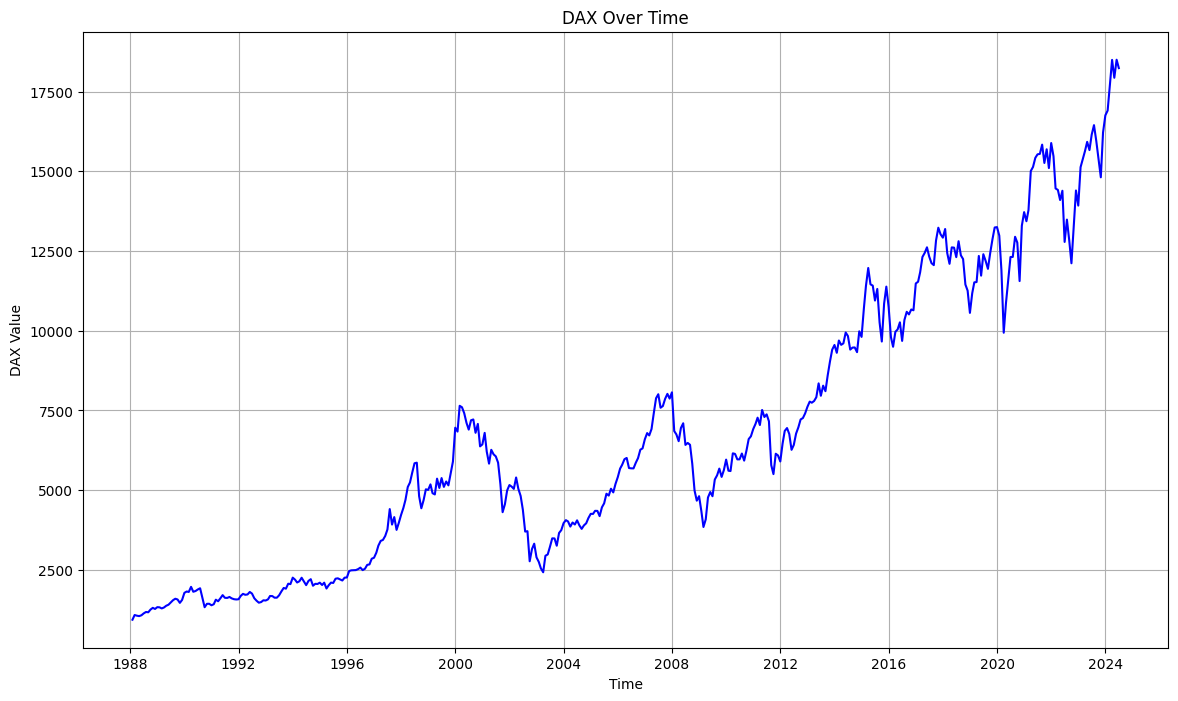

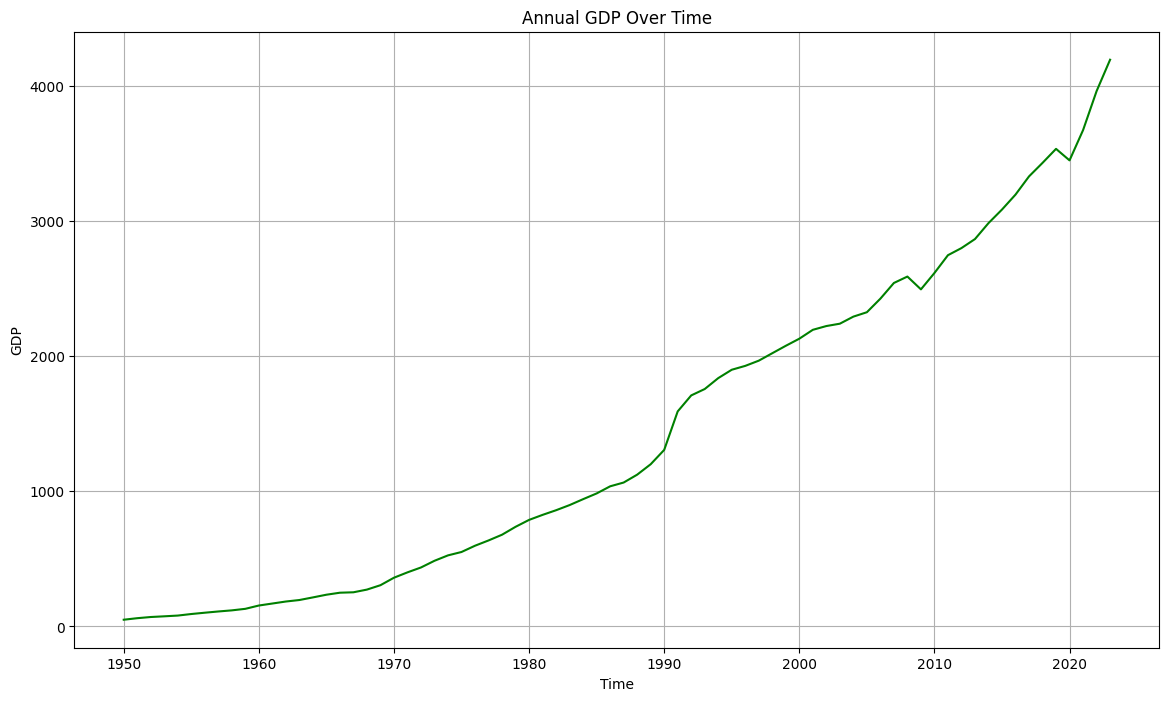

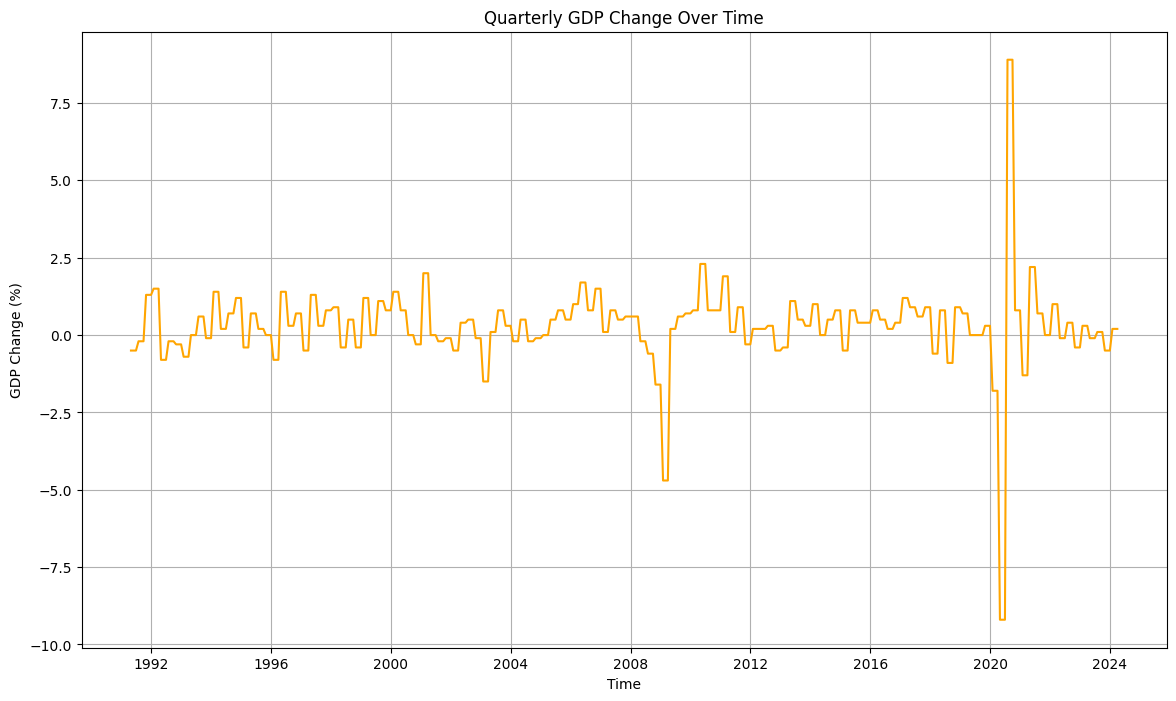

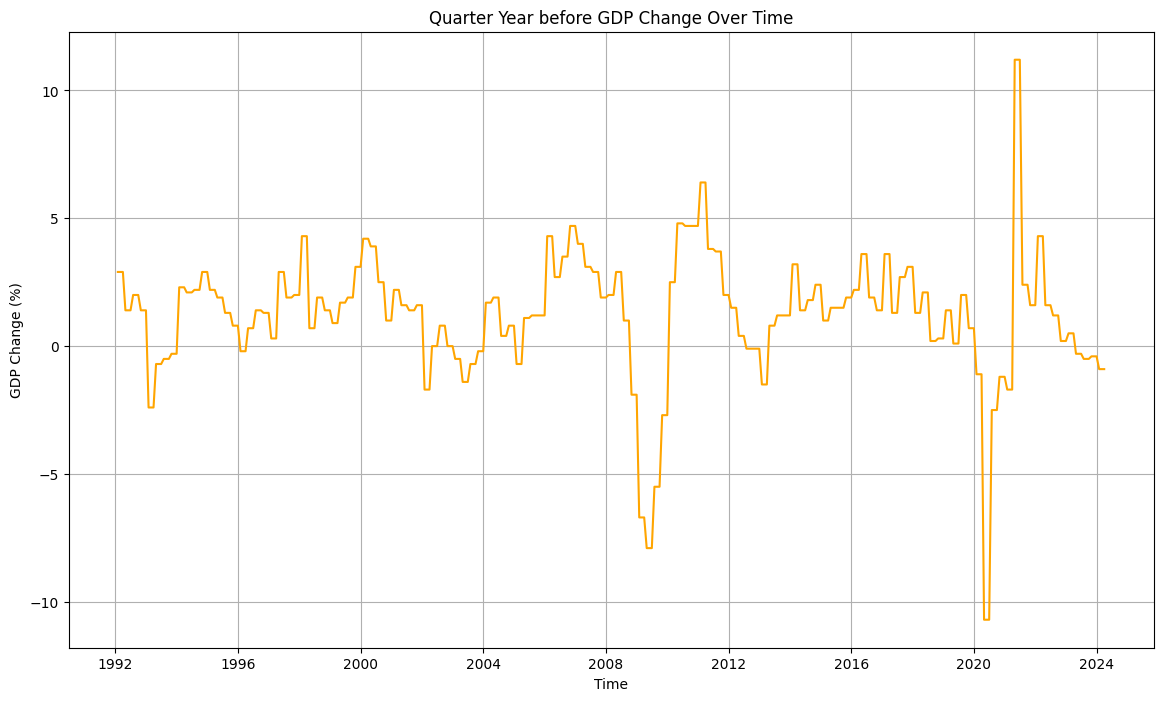

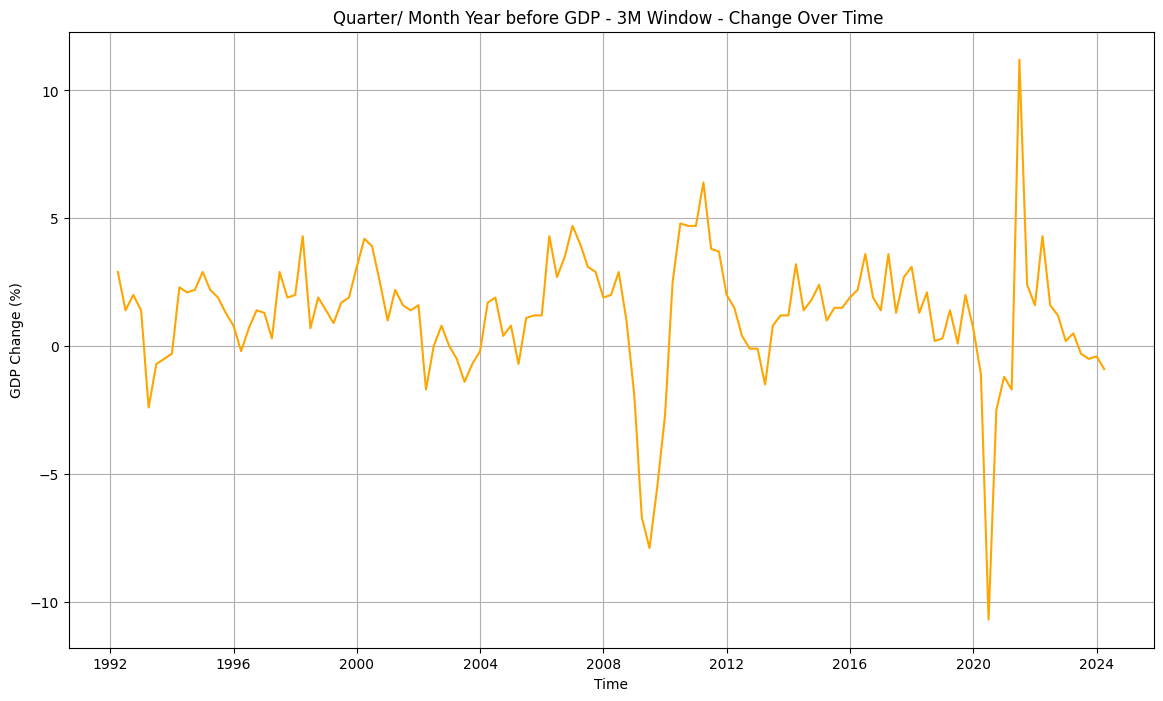

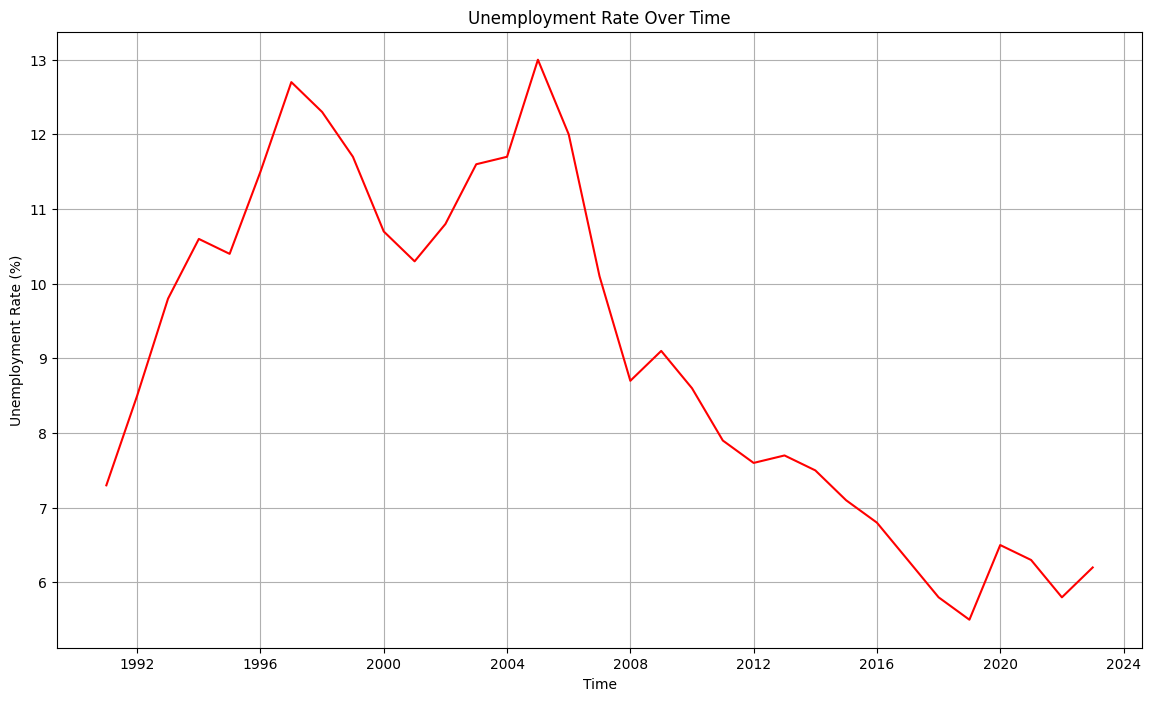

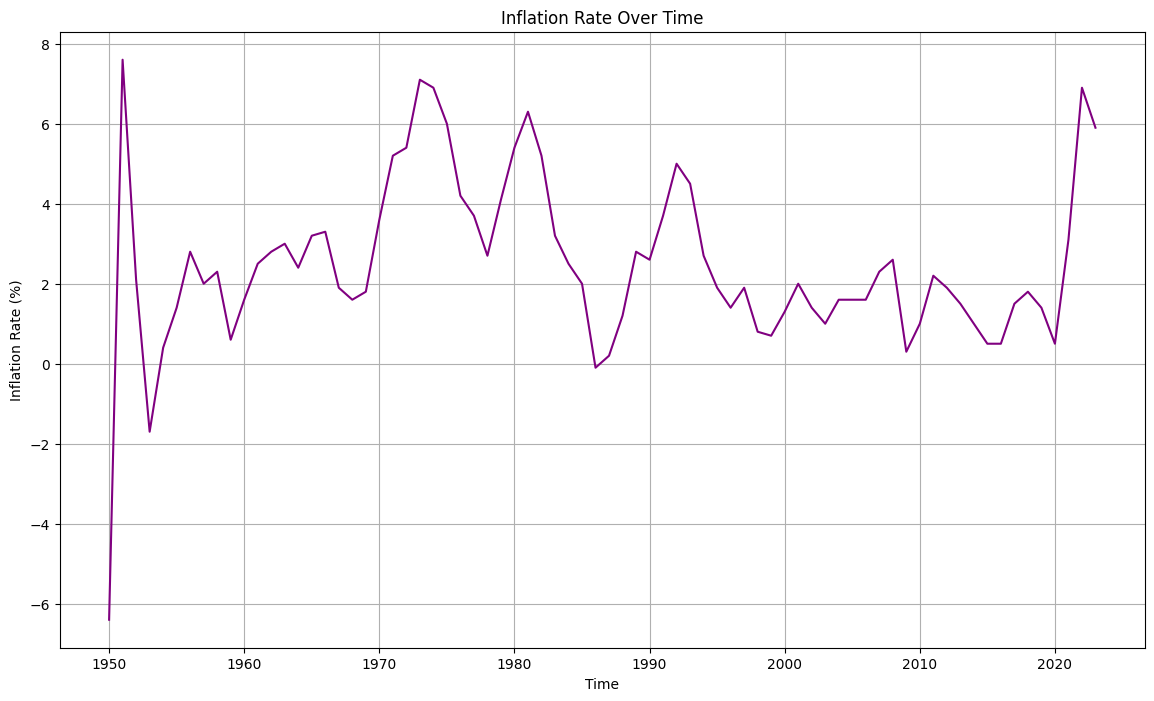

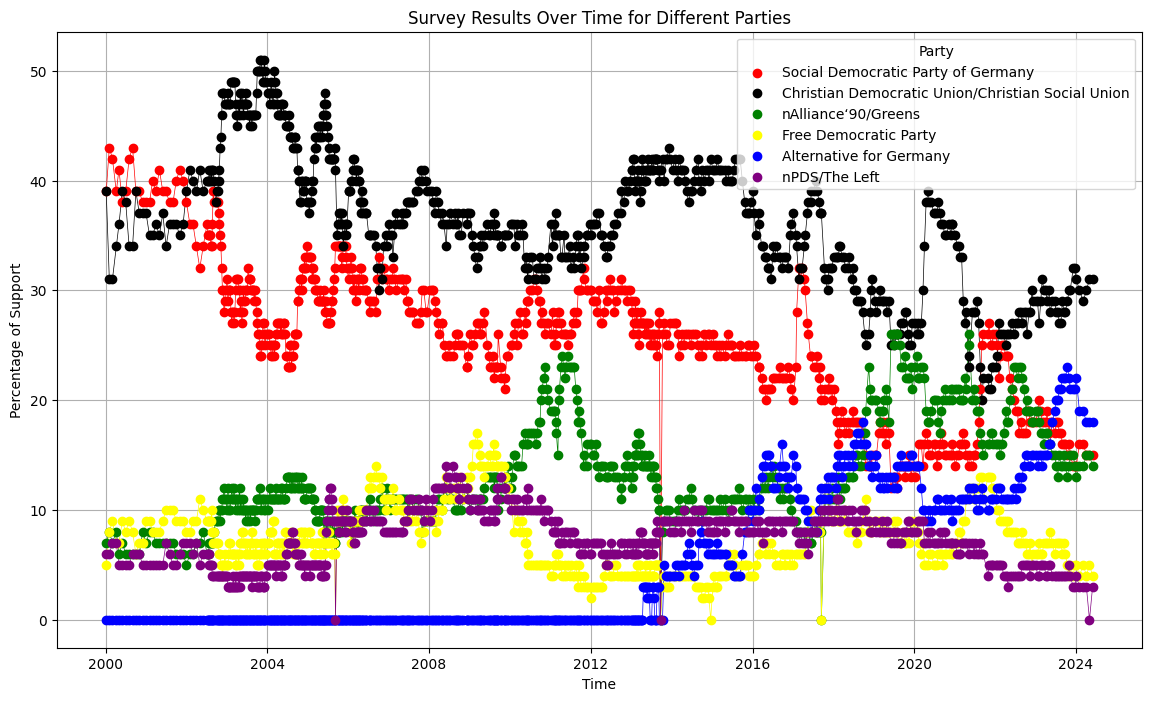

In [21]:
cleaned_df_dax = pd.read_csv(os.path.join(cleaned_data_folder, 'cleaned_df_dax.csv'), parse_dates=['Date'])
cleaned_df_gdp_annual = pd.read_csv(os.path.join(cleaned_data_folder, 'cleaned_df_gdp_annual.csv'), parse_dates=['Year'], date_parser=lambda x: pd.to_datetime(x, format='%Y'))
#cleaned_df_gdp_quarterly_change = pd.read_csv(os.path.join(cleaned_data_folder, 'cleaned_df_gdp_quarterly_change.csv'), parse_dates=['Date'])
cleaned_df_gdp_quarterly_monthly_change = pd.read_csv(os.path.join(cleaned_data_folder, 'cleaned_df_gdp_quarterly_monthly_change.csv'), parse_dates=['Date'])
cleaned_df_unemployment = pd.read_csv(os.path.join(cleaned_data_folder, 'cleaned_df_unemployment.csv'), parse_dates=['year'], date_parser=lambda x: pd.to_datetime(x, format='%Y'))
cleaned_df_inflation = pd.read_csv(os.path.join(cleaned_data_folder, 'cleaned_df_inflation.csv'), parse_dates=['Year'], date_parser=lambda x: pd.to_datetime(x, format='%Y'))
#cleaned_df_gdp_per_capita = pd.read_csv(os.path.join(cleaned_data_folder, 'cleaned_df_gdp_per_capita.csv'), parse_dates=['Date'])
cleaned_df_survey = pd.read_csv(os.path.join(cleaned_data_folder, 'cleaned_df_survey.csv'), parse_dates=['Date'])



# Plotting DAX data
plt.figure(figsize=(14, 8))
plt.plot(cleaned_df_dax['Date'], cleaned_df_dax['Last'], label='DAX', color='blue')
plt.title('DAX Over Time')
plt.xlabel('Time')
plt.ylabel('DAX Value')
plt.grid(True)
plt.savefig(os.path.join(plot_save_folder, 'dax_over_time.png'))
plt.show()

# Plotting annual GDP data
plt.figure(figsize=(14, 8))
plt.plot(cleaned_df_gdp_annual['Year'], cleaned_df_gdp_annual['GDP_billion_EUR'], label='Annual GDP', color='green')
plt.title('Annual GDP Over Time')
plt.xlabel('Time')
plt.ylabel('GDP')
plt.grid(True)
plt.savefig(os.path.join(plot_save_folder, 'gdp_annual_over_time.png'))
plt.show()

##

# Plotting quarterly GDP change
plt.figure(figsize=(14, 8))
plt.plot(cleaned_df_gdp_quarterly_monthly_change['Date'], cleaned_df_gdp_quarterly_monthly_change['GDP_Previous_Quarterly_Adjusted'], label='Quarterly GDP Change', color='orange')
plt.title('Quarterly GDP Change Over Time')
plt.xlabel('Time')
plt.ylabel('GDP Change (%)')
plt.grid(True)
plt.savefig(os.path.join(plot_save_folder, 'gdp_quarterly_change_over_time.png'))
plt.show()

# Plotting quarterly GDP change year before
plt.figure(figsize=(14, 8))
plt.plot(cleaned_df_gdp_quarterly_monthly_change['Date'], cleaned_df_gdp_quarterly_monthly_change['GDP_Previous_Year_Quarter_Adjusted'], label='Quarter Year before GDP Change', color='orange')
plt.title('Quarter Year before GDP Change Over Time')
plt.xlabel('Time')
plt.ylabel('GDP Change (%)')
plt.grid(True)
plt.savefig(os.path.join(plot_save_folder, 'gdp_quarter_year_before_change_over_time.png'))
plt.show()

# Plotting quarterly monthly GDP change year before
plt.figure(figsize=(14, 8))
plt.plot(cleaned_df_gdp_quarterly_monthly_change['Date'], cleaned_df_gdp_quarterly_monthly_change['GDP_3M_Floating_Average'], label='Quarter/ Month Year before GDP Change', color='orange')
plt.title('Quarter/ Month Year before GDP - 3M Window - Change Over Time ')
plt.xlabel('Time')
plt.ylabel('GDP Change (%)')
plt.grid(True)
plt.savefig(os.path.join(plot_save_folder, 'gdp_quarter_year_before_3m_window_change_over_time.png'))
plt.show()

# Plotting Unemployment rate
plt.figure(figsize=(14, 8))
plt.plot(cleaned_df_unemployment['year'], cleaned_df_unemployment['Combined_Germany_Unemployment'], label='Unemployment Rate', color='red')
plt.title('Unemployment Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Unemployment Rate (%)')
plt.grid(True)
plt.savefig(os.path.join(plot_save_folder, 'unemployment_rate_over_time.png'))
plt.show()

# Plotting Inflation rate
plt.figure(figsize=(14, 8))
plt.plot(cleaned_df_inflation['Year'], cleaned_df_inflation['Inflation_Rate'], label='Inflation Rate', color='purple')
plt.title('Inflation Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Inflation Rate (%)')
plt.grid(True)
plt.savefig(os.path.join(plot_save_folder, 'inflation_rate_over_time.png'))
plt.show()

# Plotting Survey data with Party Colors
plt.figure(figsize=(14, 8))
for column in cleaned_df_survey.columns:
    if column not in ['Date', 'date']:
        party_data = cleaned_df_survey[['Date', column]].dropna()
        if not party_data.empty:
            color = party_color_dict_germany.get(column, None)
            plt.scatter(party_data['Date'], party_data[column], label=column, color=color, zorder=5)
            plt.plot(party_data['Date'], party_data[column], color=color, linewidth=0.5)

plt.title('Survey Results Over Time for Different Parties')
plt.xlabel('Time')
plt.ylabel('Percentage of Support')
plt.legend(title='Party')
plt.grid(True)
plt.savefig(os.path.join(plot_save_folder, 'survey_data_over_time.png'))
plt.show()

In [22]:
print(df_new_manifesto_germany.head())
print(cleaned_df_gdp_quarterly_monthly_change.head())

      country countryname  oecdmember  eumember      edate    date  party  \
1942       41     Germany           0         0 1949-08-14  194908  41320   
1943       41     Germany           0         0 1949-08-14  194908  41420   
1944       41     Germany           0         0 1949-08-14  194908  41521   
1946       41     Germany           0         0 1949-08-14  194908  41620   
1951       41     Germany           0        10 1953-09-06  195309  41320   

                                              partyname partyabbrev  parfam  \
1942                 Social Democratic Party of Germany         SPD      30   
1943                              Free Democratic Party         FDP      40   
1944  Christian Democratic Union/Christian Social Union     CDU/CSU      50   
1946                                       German Party          DP      60   
1951                 Social Democratic Party of Germany         SPD      30   

      ... markeco  welfare  intpeace  datasetversion  id_perm 

# Main Section

## define functions

In [23]:
def df_merging(df_manifesto, df_economic, df_manifesto_mode='no_delay'):
    #print('Starting merging for df_manifesto and df_economic')
    
    df_manifesto_merging = df_manifesto.copy() # mostly df_new_manifesto_germany_analysis
    df_economic_merging = df_economic.copy() # mostly cleaned_df_gdp_quarterly_monthly_change
    
    # all types of manifesto df's have an edate (election date)
    df_manifesto_merging['Date'] = pd.to_datetime(df_manifesto_merging['edate'], errors='coerce')


    # Initialize an empty DataFrame to store election data and corresponding 3-month G average
    df_merged = pd.DataFrame()
    
    if df_manifesto_mode == 'no_delay':
        # Create a new 'Date_month_before' column representing the same day as the edate
        # but since merge/ join below is backward it will take GDP 3M of the last day of the month before which is perfect
        # so election 22.09 merge on 31.08
        df_manifesto_merging[f'MANIFESTO_Date_merge_{df_manifesto_mode}'] = df_manifesto_merging['Date'] - pd.DateOffset(months=0)
    
    elif df_manifesto_mode == 'delay':
        # Create a new 'Date_Published' column representing the publication date of the manifesto 
        # 3 months before the edate (most of the  manifestos are published in may/ june so a bit earlier is needed) 
        # but since merge/ join below is backward it will take GDP 3M average of 31.05 which is perfect
        # so election 22.09 merge on 31.05
        df_manifesto_merging[f'MANIFESTO_Date_merge_{df_manifesto_mode}'] = df_manifesto_merging['Date'] - pd.DateOffset(months=3)


    else:
        print('Please select mode no_delay or delay.')
        print('Returning empty df')
        return df_merged

    
    
    df_manifesto_merging = df_manifesto_merging.sort_values(by=f'MANIFESTO_Date_merge_{df_manifesto_mode}')
    
    # Rename 'Date' column in df_economic_merging to 'ECONOMIC_Date_merge' to avoid column conflicts
    # ECONOMIC_Date_merge will always be Date thanks to preprocessing of quarterly and monthly data. yearly is not used as of now
    df_economic_merging.rename(columns={'Date': 'ECONOMIC_Date_merge'}, inplace=True)
    # Sort both dataframes by their date columns to use 'merge_asof'
    df_economic_merging = df_economic_merging.sort_values(by='ECONOMIC_Date_merge')
    

    # Merge the manifesto data with the economic data
    # asof = similar to a left-join except that we match on nearest key rather than equal keys. Both DataFrames must be sorted by the key.
    df_merged = pd.merge_asof(
        df_manifesto_merging,
        df_economic_merging,
        left_on= f'MANIFESTO_Date_merge_{df_manifesto_mode}',
        right_on='ECONOMIC_Date_merge',
        direction='backward'
    )

    # Check the columns
    # print(df_merged.columns)

    # Save the merged DataFrame if needed
    df_merged.to_csv(os.path.join(data_folder, f'df_merged_{df_manifesto_mode}.csv'), index=False)
    
    return df_merged

In [24]:
def normalize_party_codes(party_df, codes):
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    print(scaler)
    party_df[codes] = scaler.fit_transform(party_df[codes])
    return party_df    


In [25]:
def analyze_party(df, party_name, economic_value, manifesto_codes, df_manifesto_mode='no_delay'):
    party_df = pd.DataFrame()
    # Filter the data for the specific party
    party_df = df[df['partyname'] == party_name].copy()

    # Drop rows with NaN values in 'GDP_3M_Floating_Average' and the selected parameters
    party_df = party_df.dropna(subset=[economic_value] + manifesto_codes)

    if party_df.empty:
        print(f"No valid data for {party_name}. Skipping analysis.")
        return party_df  # Return empty DataFrame if no data

    # Normalize within party standards
    party_df = normalize_party_codes(party_df, manifesto_codes)
    
    party_df.to_csv(os.path.join(data_folder, f'party_df_{df_manifesto_mode}.csv'), index=False)


    X = party_df[economic_value].values.reshape(-1, 1)  # Reshape to 2D for single feature

    print(f"Results for {party_name} on {df_manifesto_mode} mode")
    
    # Loop through each manifesto code individually
    for param in manifesto_codes:
        y = party_df[param].values  # Dependent variable (manifesto focus)
        
        #print(y)

        model = LinearRegression()
        model.fit(X, y)

        # Coefficients
        intercept = model.intercept_
        coef = model.coef_[0]

        print('##############################################################################')
        print(f"{party_name}: Coefficient for {param} on {economic_value}: {coef} (with intercept {intercept}) \n")
        print(f" y = {intercept} + {coef}*x \n")

        # Determine the trend based on the coefficient
        if coef > 0:
            trend = 'increases'
        else:
            trend = 'decreases'

        print(f"For an increase of 1 of {economic_value}, {param} in the manifesto of {party_name} {trend} by {coef}")
        
        # Make predictions
        y_pred = model.predict(X)
        #print(y_pred)
        
        # Calculate Mean Squared Error (MSE) and R² Score for the individual manifesto code
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        
        print('')
        print(f"Mean Squared Error (MSE) for {param}: {mse}")
        print(f"R² Score for {param}: {r2}")
        print('##############################################################################')

    return party_df  # Return the party_df for plotting later


In [26]:
def plot_party_analysis(party_df, party_name, economic_value, manifesto_codes, y_label, df_manifesto_mode='no_delay'):
    # Plot the relationship between the economic indicators and each parameter over time
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the manifesto focus parameters on the first y-axis
    for param in manifesto_codes:
        ax1.plot(party_df['Date'], party_df[param], label=f'{param} Focus')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Score', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create the second y-axis for the GDP 3-month floating average
    ax2 = ax1.twinx()
    ax2.scatter(party_df['Date'], party_df[economic_value], color='orange', label=economic_value)
    ax2.plot(party_df['Date'], party_df[economic_value], color='orange', linestyle=':', linewidth=1)
    ax2.set_ylabel(f'{y_label} - {df_manifesto_mode} mode', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Add legends and title
    fig.suptitle(f'{economic_value} and Manifesto codes for {party_name}')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    partyabbrev = party_df["partyabbrev"].values[1]
    partyabbrev = partyabbrev[:3]
    plt.savefig(os.path.join(plot_save_folder, f'{partyabbrev}_{economic_value}_{df_manifesto_mode}.png'))
    plt.show()


## analysis

## gdp and election data (no delay)

StandardScaler()
Results for Social Democratic Party of Germany on no_delay mode
##############################################################################
Social Democratic Party of Germany: Coefficient for per416 on GDP_3M_Floating_Average: 0.20243168876331535 (with intercept -0.19568396580453803) 

 y = -0.19568396580453803 + 0.20243168876331535*x 

For an increase of 1 of GDP_3M_Floating_Average, per416 in the manifesto of Social Democratic Party of Germany increases by 0.20243168876331535

Mean Squared Error (MSE) for per416: 0.6131621234690401
R² Score for per416: 0.38683787653096
##############################################################################
##############################################################################
Social Democratic Party of Germany: Coefficient for per504 on GDP_3M_Floating_Average: 0.22533065347274917 (with intercept -0.21781963169032417) 

 y = -0.21781963169032417 + 0.22533065347274917*x 

For an increase of 1 of GDP_3M_Floating_Avera

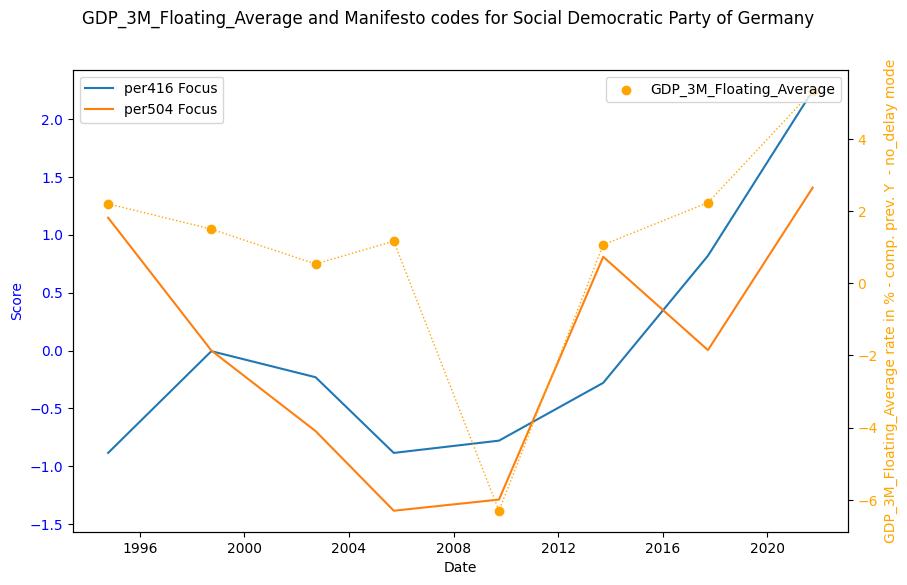

StandardScaler()
Results for Free Democratic Party on no_delay mode
##############################################################################
Free Democratic Party: Coefficient for per416 on GDP_3M_Floating_Average: 0.19356077610183792 (with intercept -0.1871087502317767) 

 y = -0.1871087502317767 + 0.19356077610183792*x 

For an increase of 1 of GDP_3M_Floating_Average, per416 in the manifesto of Free Democratic Party increases by 0.19356077610183792

Mean Squared Error (MSE) for per416: 0.6463230930138228
R² Score for per416: 0.35367690698617704
##############################################################################
##############################################################################
Free Democratic Party: Coefficient for per504 on GDP_3M_Floating_Average: 0.1605010323746987 (with intercept -0.155150997962209) 

 y = -0.155150997962209 + 0.1605010323746987*x 

For an increase of 1 of GDP_3M_Floating_Average, per504 in the manifesto of Free Democratic Party incr

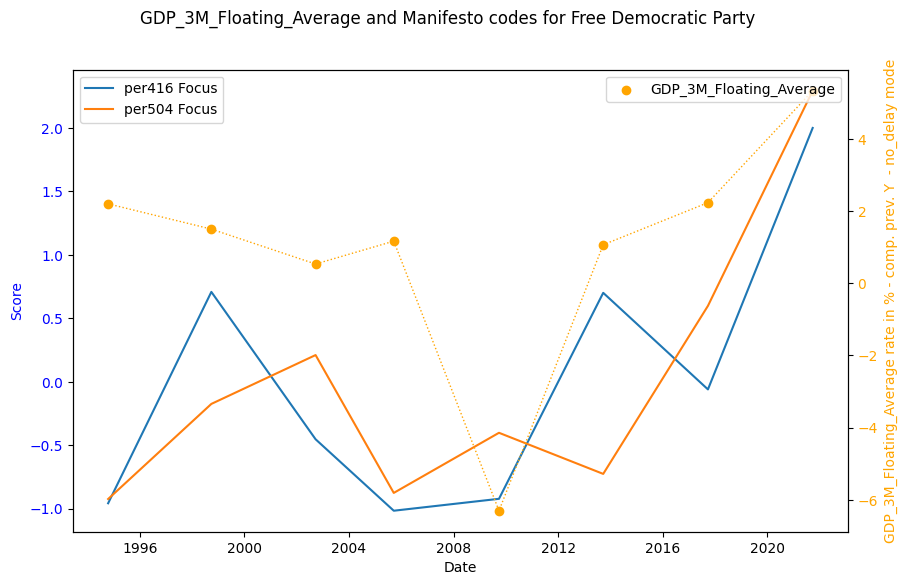

StandardScaler()
Results for Christian Democratic Union/Christian Social Union on no_delay mode
##############################################################################
Christian Democratic Union/Christian Social Union: Coefficient for per416 on GDP_3M_Floating_Average: 0.18642623074924483 (with intercept -0.1802120230576033) 

 y = -0.1802120230576033 + 0.18642623074924483*x 

For an increase of 1 of GDP_3M_Floating_Average, per416 in the manifesto of Christian Democratic Union/Christian Social Union increases by 0.18642623074924483

Mean Squared Error (MSE) for per416: 0.6719152590126608
R² Score for per416: 0.3280847409873392
##############################################################################
##############################################################################
Christian Democratic Union/Christian Social Union: Coefficient for per504 on GDP_3M_Floating_Average: 0.2011704112156546 (with intercept -0.1944647308417992) 

 y = -0.1944647308417992 + 0.2011704112

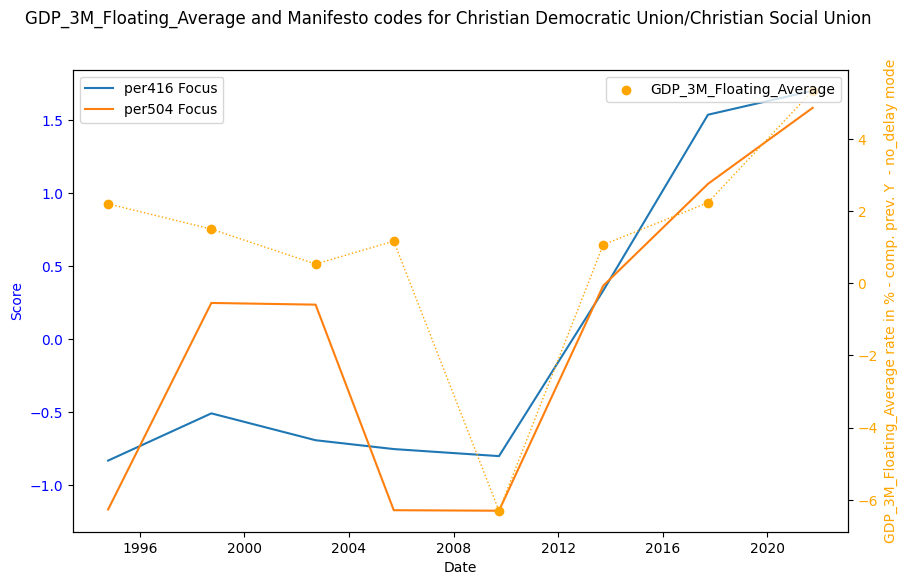

No valid data for German Party. Skipping analysis.
StandardScaler()
Results for nAlliance‘90/Greens on no_delay mode
##############################################################################
nAlliance‘90/Greens: Coefficient for per416 on GDP_3M_Floating_Average: 0.19147806442859258 (with intercept -0.18509546228097304) 

 y = -0.18509546228097304 + 0.19147806442859258*x 

For an increase of 1 of GDP_3M_Floating_Average, per416 in the manifesto of nAlliance‘90/Greens increases by 0.19147806442859258

Mean Squared Error (MSE) for per416: 0.6538932639548964
R² Score for per416: 0.34610673604510345
##############################################################################
##############################################################################
nAlliance‘90/Greens: Coefficient for per504 on GDP_3M_Floating_Average: 0.29041530064487164 (with intercept -0.2807347906233754) 

 y = -0.2807347906233754 + 0.29041530064487164*x 

For an increase of 1 of GDP_3M_Floating_Average, per5

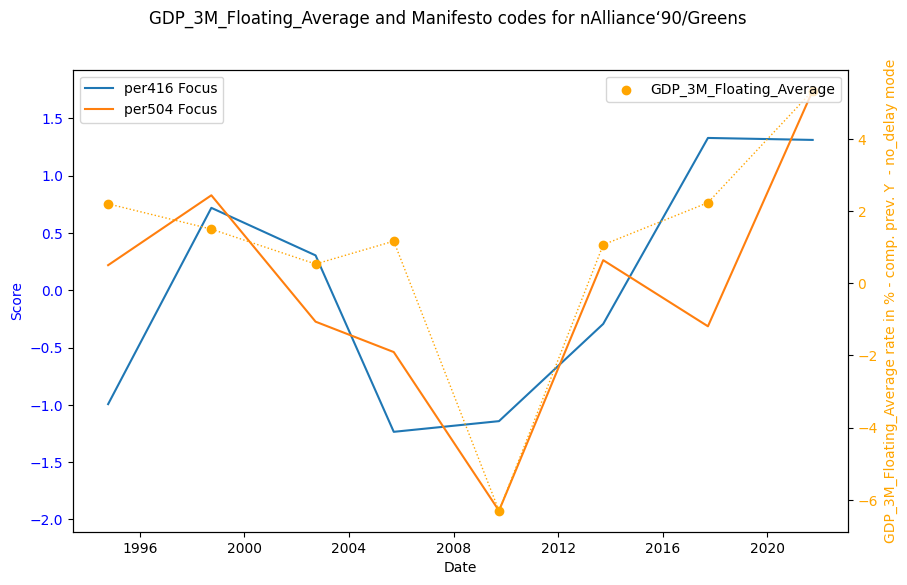

StandardScaler()
Results for nPDS/The Left on no_delay mode
##############################################################################
nPDS/The Left: Coefficient for per416 on GDP_3M_Floating_Average: 0.20412979797585118 (with intercept -0.19732547137665613) 

 y = -0.19732547137665613 + 0.20412979797585118*x 

For an increase of 1 of GDP_3M_Floating_Average, per416 in the manifesto of nPDS/The Left increases by 0.20412979797585118

Mean Squared Error (MSE) for per416: 0.6066448814595123
R² Score for per416: 0.39335511854048766
##############################################################################
##############################################################################
nPDS/The Left: Coefficient for per504 on GDP_3M_Floating_Average: 0.2906319162892816 (with intercept -0.2809441857463054) 

 y = -0.2809441857463054 + 0.2906319162892816*x 

For an increase of 1 of GDP_3M_Floating_Average, per504 in the manifesto of nPDS/The Left increases by 0.2906319162892816

Mean Sq

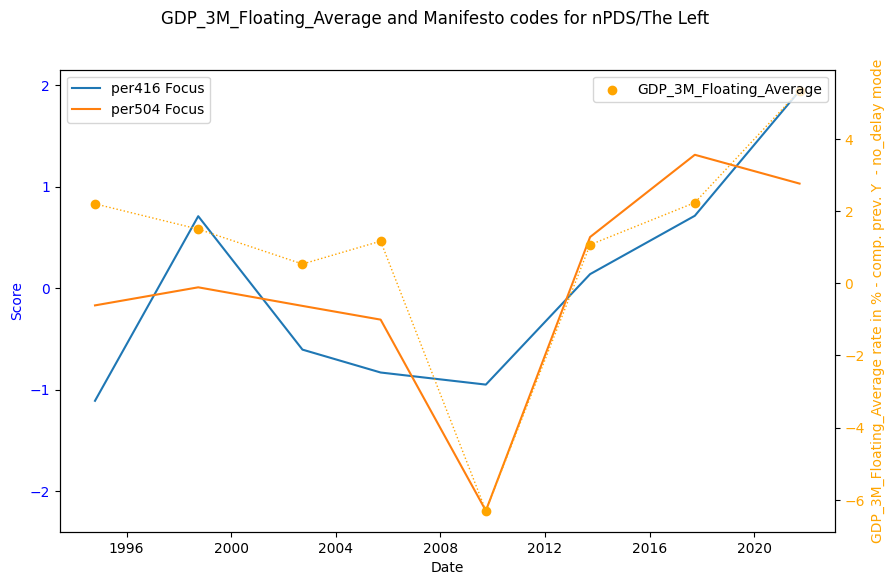

StandardScaler()
Results for Alternative for Germany on no_delay mode
##############################################################################
Alternative for Germany: Coefficient for per416 on GDP_3M_Floating_Average: -0.2986446106208867 (with intercept 0.859432823897885) 

 y = 0.859432823897885 + -0.2986446106208867*x 

For an increase of 1 of GDP_3M_Floating_Average, per416 in the manifesto of Alternative for Germany decreases by -0.2986446106208867

Mean Squared Error (MSE) for per416: 0.7108747716708298
R² Score for per416: 0.2891252283291701
##############################################################################
##############################################################################
Alternative for Germany: Coefficient for per504 on GDP_3M_Floating_Average: 0.5482051043039453 (with intercept -1.5776124668302434) 

 y = -1.5776124668302434 + 0.5482051043039453*x 

For an increase of 1 of GDP_3M_Floating_Average, per504 in the manifesto of Alternative for Germa

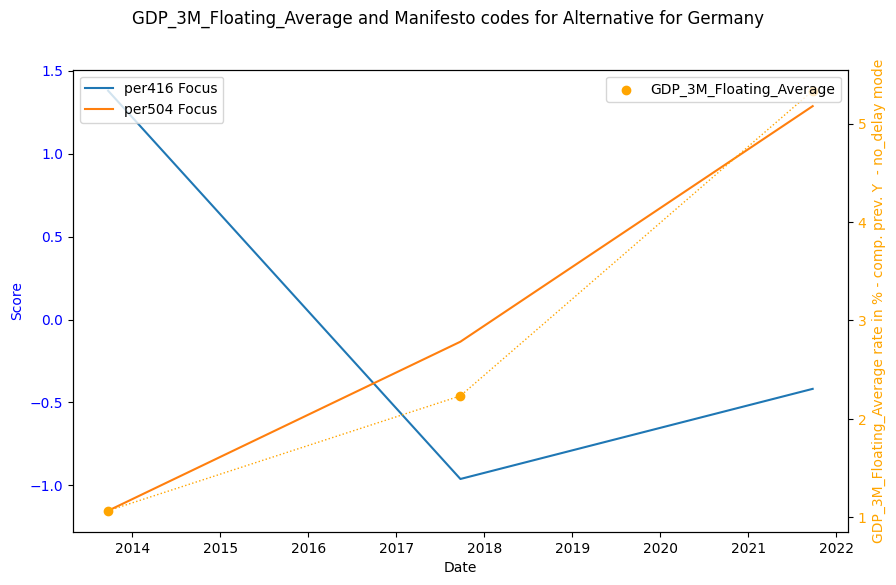

In [27]:
# Parameters to set CONFIG
economic_value = 'GDP_3M_Floating_Average'
#parameters = ['markeco', 'n_markeco', 'planeco', 'n_planeco', 'n_crisiseco', 'per410']
parameters = ['markeco', 'planeco', 'per410']
parameters = ['per102', 'per408', 'per415', 'per416', 'per504']
parameters = ['per416', 'per504', 'markeco', 'planeco', 'per410']
parameters = ['per416', 'per504']
#parameters = ['markeco', 'planeco', 'per410']


#parameters = ['planeco']
y_label=f'{economic_value} rate in % - comp. prev. Y '
df_manifesto_mode='no_delay'



df_merged_for_analysis = pd.DataFrame()
df_merged_for_analysis = df_merging(df_new_manifesto_germany, cleaned_df_gdp_quarterly_monthly_change, df_manifesto_mode=df_manifesto_mode)

    
# Example: Analyze the relationship between economic indicators and manifesto focus for each party
for party in df_merged_for_analysis['partyname'].unique():
    party_df = analyze_party(df_merged_for_analysis, party, economic_value, parameters, df_manifesto_mode=df_manifesto_mode)
    
    if not party_df.empty:
        plot_party_analysis(party_df, party, economic_value, parameters, y_label=y_label, df_manifesto_mode=df_manifesto_mode)

## gdp and election data (delay)

StandardScaler()
Results for Social Democratic Party of Germany on delay mode
##############################################################################
Social Democratic Party of Germany: Coefficient for markeco on GDP_3M_Floating_Average: -0.06156270165260532 (with intercept 0.04181133487239454) 

 y = 0.04181133487239454 + -0.06156270165260532*x 

For an increase of 1 of GDP_3M_Floating_Average, markeco in the manifesto of Social Democratic Party of Germany decreases by -0.06156270165260532

Mean Squared Error (MSE) for markeco: 0.9464510012059529
R² Score for markeco: 0.05354899879404673
##############################################################################
##############################################################################
Social Democratic Party of Germany: Coefficient for planeco on GDP_3M_Floating_Average: -0.15078731110156868 (with intercept 0.10240971545648213) 

 y = 0.10240971545648213 + -0.15078731110156868*x 

For an increase of 1 of GDP_3M_Floating

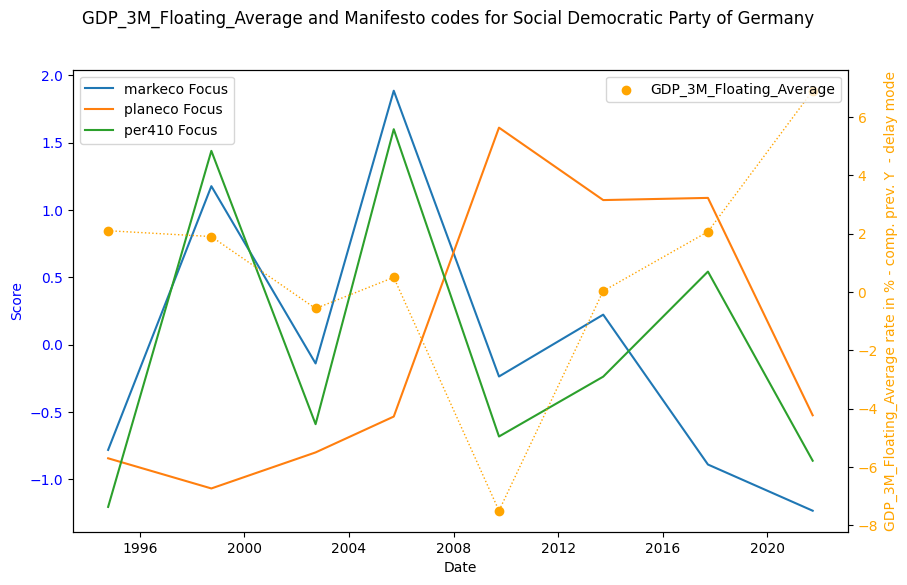

StandardScaler()
Results for Free Democratic Party on delay mode
##############################################################################
Free Democratic Party: Coefficient for markeco on GDP_3M_Floating_Average: -0.06807223165859132 (with intercept 0.04623239066812672) 

 y = 0.04623239066812672 + -0.06807223165859132*x 

For an increase of 1 of GDP_3M_Floating_Average, markeco in the manifesto of Free Democratic Party decreases by -0.06807223165859132

Mean Squared Error (MSE) for markeco: 0.9345279421166308
R² Score for markeco: 0.06547205788336918
##############################################################################
##############################################################################
Free Democratic Party: Coefficient for planeco on GDP_3M_Floating_Average: -0.13796639295112803 (with intercept 0.09370217521264108) 

 y = 0.09370217521264108 + -0.13796639295112803*x 

For an increase of 1 of GDP_3M_Floating_Average, planeco in the manifesto of Free Democrati

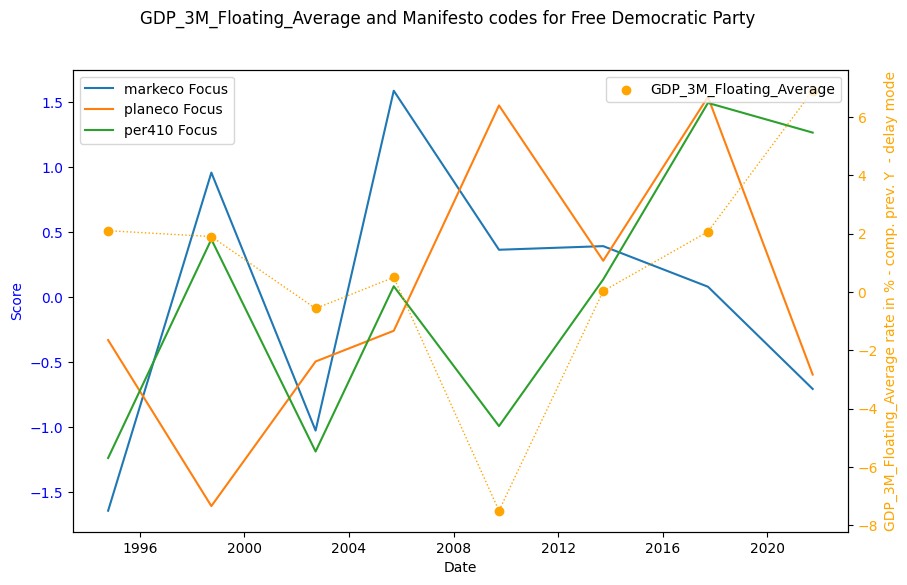

StandardScaler()
Results for Christian Democratic Union/Christian Social Union on delay mode
##############################################################################
Christian Democratic Union/Christian Social Union: Coefficient for markeco on GDP_3M_Floating_Average: -0.07368135159858728 (with intercept 0.050041917960707116) 

 y = 0.050041917960707116 + -0.07368135159858728*x 

For an increase of 1 of GDP_3M_Floating_Average, markeco in the manifesto of Christian Democratic Union/Christian Social Union decreases by -0.07368135159858728

Mean Squared Error (MSE) for markeco: 0.9232936739383693
R² Score for markeco: 0.07670632606163053
##############################################################################
##############################################################################
Christian Democratic Union/Christian Social Union: Coefficient for planeco on GDP_3M_Floating_Average: -0.07491621435543501 (with intercept 0.05088059558306637) 

 y = 0.05088059558306637 + -0

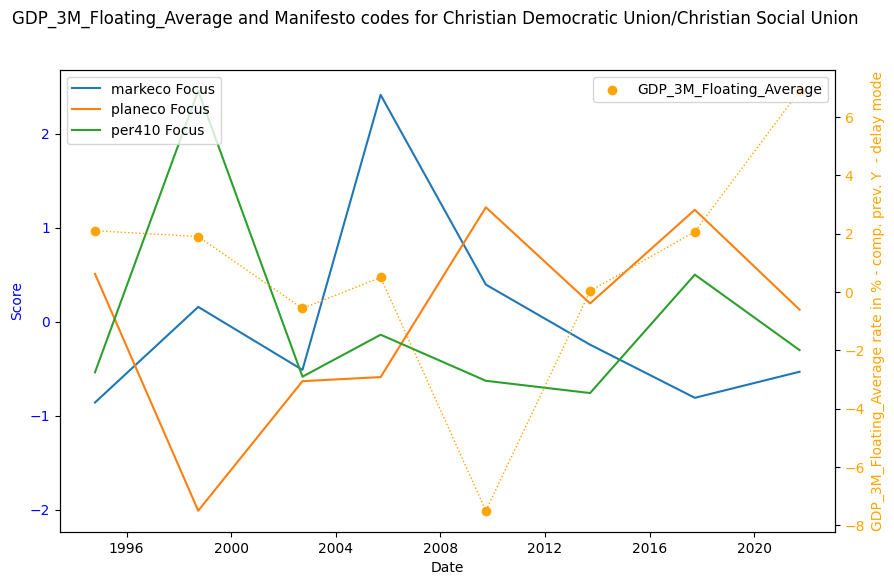

No valid data for German Party. Skipping analysis.
StandardScaler()
Results for nAlliance‘90/Greens on delay mode
##############################################################################
nAlliance‘90/Greens: Coefficient for markeco on GDP_3M_Floating_Average: -0.05660346812216004 (with intercept 0.03844318876630043) 

 y = 0.03844318876630043 + -0.05660346812216004*x 

For an increase of 1 of GDP_3M_Floating_Average, markeco in the manifesto of nAlliance‘90/Greens decreases by -0.05660346812216004

Mean Squared Error (MSE) for markeco: 0.9547308752978412
R² Score for markeco: 0.045269124702158825
##############################################################################
##############################################################################
nAlliance‘90/Greens: Coefficient for planeco on GDP_3M_Floating_Average: 0.003459797424918173 (with intercept -0.002349779084423591) 

 y = -0.002349779084423591 + 0.003459797424918173*x 

For an increase of 1 of GDP_3M_Floating_Ave

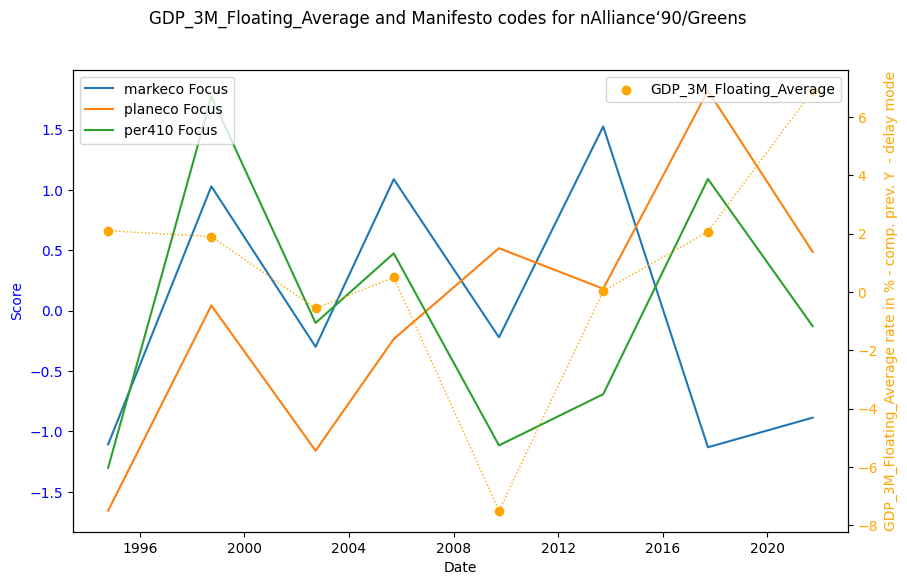

StandardScaler()
Results for nPDS/The Left on delay mode
##############################################################################
nPDS/The Left: Coefficient for markeco on GDP_3M_Floating_Average: -0.013728042604470855 (with intercept 0.009323628935536381) 

 y = 0.009323628935536381 + -0.013728042604470855*x 

For an increase of 1 of GDP_3M_Floating_Average, markeco in the manifesto of nPDS/The Left decreases by -0.013728042604470855

Mean Squared Error (MSE) for markeco: 0.9973372324786651
R² Score for markeco: 0.0026627675213348745
##############################################################################
##############################################################################
nPDS/The Left: Coefficient for planeco on GDP_3M_Floating_Average: 0.027386902426052906 (with intercept -0.018600271231027702) 

 y = -0.018600271231027702 + 0.027386902426052906*x 

For an increase of 1 of GDP_3M_Floating_Average, planeco in the manifesto of nPDS/The Left increases by 0.027386

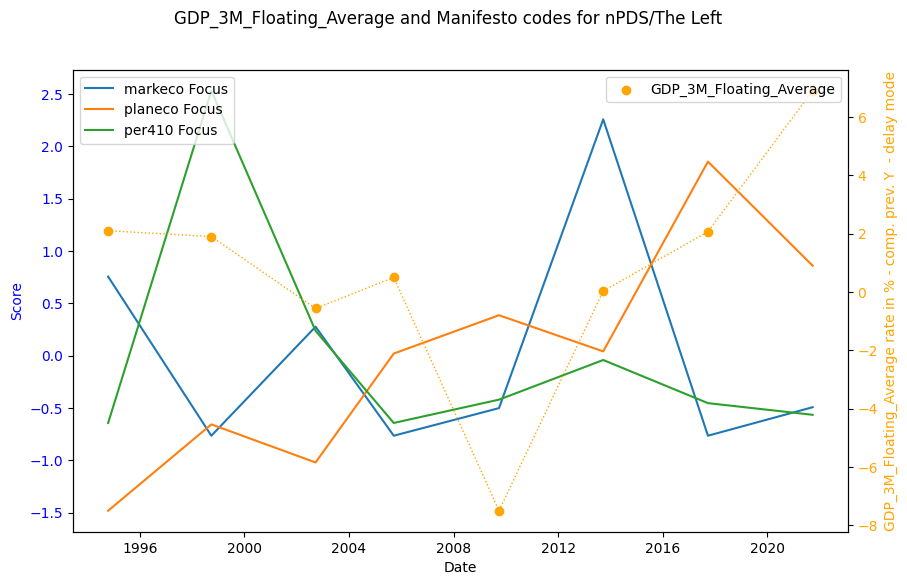

StandardScaler()
Results for Alternative for Germany on delay mode
##############################################################################
Alternative for Germany: Coefficient for markeco on GDP_3M_Floating_Average: -0.1713309430363204 (with intercept 0.5139928291089614) 

 y = 0.5139928291089614 + -0.1713309430363204*x 

For an increase of 1 of GDP_3M_Floating_Average, markeco in the manifesto of Alternative for Germany decreases by -0.1713309430363204

Mean Squared Error (MSE) for markeco: 0.7565333274140139
R² Score for markeco: 0.2434666725859861
##############################################################################
##############################################################################
Alternative for Germany: Coefficient for planeco on GDP_3M_Floating_Average: 0.08613214906588199 (with intercept -0.258396447197646) 

 y = -0.258396447197646 + 0.08613214906588199*x 

For an increase of 1 of GDP_3M_Floating_Average, planeco in the manifesto of Alternative for 

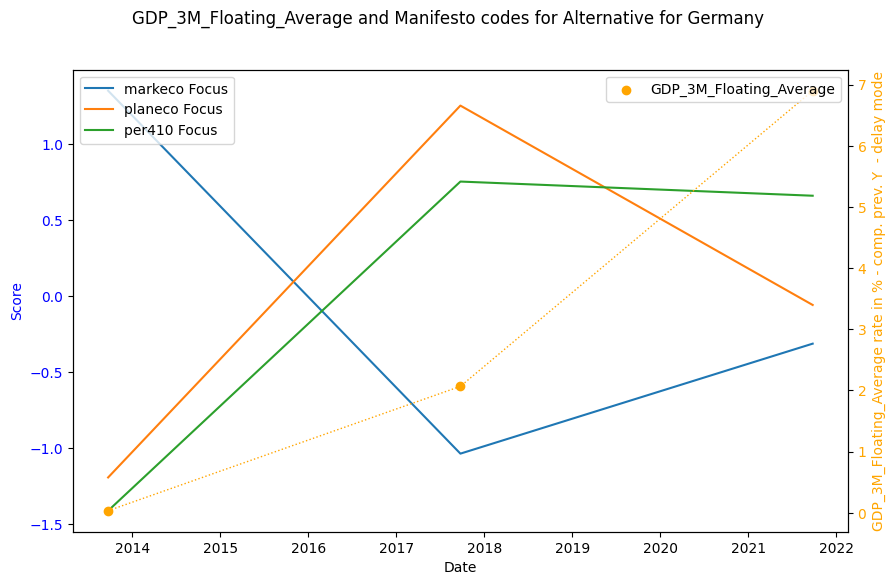

In [28]:
# Parameters to set CONFIG
economic_value = 'GDP_3M_Floating_Average'
#parameters = ['markeco', 'n_markeco', 'planeco', 'n_planeco', 'n_crisiseco', 'per410']
parameters = ['markeco', 'planeco', 'per410']
parameters = ['per102', 'per408', 'per415', 'per416', 'per504']
parameters = ['per416', 'per504', 'markeco', 'planeco', 'per410']
parameters = ['per408', 'per416', 'per504']
parameters = ['per416', 'per504']
parameters = ['markeco', 'planeco', 'per410']


#parameters = ['planeco']
y_label=f'{economic_value} rate in % - comp. prev. Y '
df_manifesto_mode='delay'



df_merged_for_analysis = pd.DataFrame()
df_merged_for_analysis = df_merging(df_new_manifesto_germany, cleaned_df_gdp_quarterly_monthly_change, df_manifesto_mode=df_manifesto_mode)

    
# Example: Analyze the relationship between economic indicators and manifesto focus for each party
for party in df_merged_for_analysis['partyname'].unique():
    party_df = analyze_party(df_merged_for_analysis, party, economic_value, parameters, df_manifesto_mode=df_manifesto_mode)
    
    if not party_df.empty:
        plot_party_analysis(party_df, party, economic_value, parameters, y_label=y_label, df_manifesto_mode=df_manifesto_mode)

## dax

In [29]:
"""
# Assuming 'cleaned_df_dax' has the DAX data and 'Date' column in datetime format
df_new_manifesto_germany['Date'] = pd.to_datetime(df_new_manifesto_germany['edate'], errors='coerce')
cleaned_df_dax['Date'] = pd.to_datetime(cleaned_df_dax['Date'])

print(cleaned_df_dax.head())

# Resample DAX data to monthly frequency, filling missing months with the previous value
dax_monthly = cleaned_df_dax.set_index('Date').resample('M').ffill()


# Calculate the 3-month rolling average
dax_monthly['DAX_3M_Floating_Average'] = dax_monthly['Change_Percentage'].rolling(window=3).mean()

# Reset index to have 'Date' back as a column
dax_monthly.reset_index(inplace=True)

dax_monthly.to_csv(os.path.join(data_folder, '1_dax_monthly.csv'), index=False)

# Initialize an empty DataFrame to store election data and corresponding 3-month DAX average
election_dax_df = pd.DataFrame()

# Iterate through each election date in the manifesto data
for election_date in df_new_manifesto_germany['Date']:
    # Filter DAX data for the 3 months before the election
    mask = (dax_monthly['Date'] < election_date) & (dax_monthly['Date'] >= (election_date - pd.DateOffset(months=1)))
    
    # Calculate the average of the 3 months' DAX
    avg_dax_3m = dax_monthly.loc[mask, 'DAX_3M_Floating_Average'].mean()
    
    # Append the results to the election_dax_df using pd.concat
    new_row = pd.DataFrame({'Date': [election_date], 'DAX_3M_Floating_Average': [avg_dax_3m]})
    election_dax_df = pd.concat([election_dax_df, new_row], ignore_index=True)
    election_dax_df.to_csv(os.path.join(data_folder, '2_election_dax_df'), index=False)


# Now election_dax_df has the 3-month DAX floating averages aligned to each election date
# Merge the election manifesto data with the 3-month DAX average data
df_merged = pd.merge(df_new_manifesto_germany, election_dax_df, on='Date', how='inner')

# Drop duplicates if necessary
df_merged.drop_duplicates(subset=['Date', 'partyname'], keep='first', inplace=True)

# Now 'df_merged' contains both the manifesto data and the corresponding 3-month DAX averages before the election
df_merged.to_csv(os.path.join(data_folder, '3_df_merged_with_dax.csv'), index=False)

def normalize_party_codes(party_df, codes):
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    print(scaler)
    party_df[codes] = scaler.fit_transform(party_df[codes])
    return party_df

def analyze_party(df, party_name, economic_value, manifesto_codes):
    party_df = pd.DataFrame()
    # Filter the data for the specific party
    party_df = df[df['partyname'] == party_name].copy()
    
    # Drop rows with NaN values in 'GDP_3M_Floating_Average' and the selected parameters
    party_df = party_df.dropna(subset=[economic_value] + manifesto_codes)
    
    if party_df.empty:
        print(f"No valid data for {party_name}. Skipping analysis.")
        return
    
    # Normalize within party standards
    party_df = normalize_party_codes(party_df, manifesto_codes)
    
    party_df.to_csv(os.path.join(data_folder, 'party_df.csv'), index=False)
    

    X = party_df[economic_value].values.reshape(-1, 1)  # Reshape to 2D for single feature
    y = party_df[manifesto_codes]  # Dependent variables (manifesto focus)

    model = LinearRegression()
    model.fit(X, y)

    print(f"Results for {party_name}")
    for param, intercept, coef in zip(manifesto_codes,  model.intercept_, model.coef_.flatten()):
        print('##############################################################################')
        print(f"{party_name}: Coefficient for {param} on {economic_value}: {coef} (with intercept {intercept})")
        print('')
        print(f" y = ß0 + ß1*x           y = {intercept} + {coef}*x")
        print('')
        if coef > 0:
            trend = 'increases'
        else:
            trend = 'decreases'
        print(f"for an increase of 1 of {economic_value}, {param} in the manifesto of {party_name} {trend} by {coef} (normalized)")


    # Plot the relationship between the economic indicators and each parameter over time
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the manifesto focus parameters on the first y-axis
    for param in manifesto_codes:
        ax1.plot(party_df['Date'], party_df[param], label=f'{param} Focus')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Score', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create the second y-axis for the GDP 3-month floating average
    ax2 = ax1.twinx()
    ax2.scatter(party_df['Date'], party_df[economic_value], color='orange', label=economic_value)
    ax2.plot(party_df['Date'], party_df[economic_value], color='orange', linestyle=':', linewidth=1)
    ax2.set_ylabel(f'DAX growth rate in % - comp. to previous month - mean over 3 months', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Add legends and title
    fig.suptitle(f'Economic Indicators in Manifesto for {party_name}')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    
    partyabbrev = party_df["partyabbrev"].values[1]
    partyabbrev = partyabbrev[:3]
    plt.savefig(os.path.join(plot_save_folder, f'{partyabbrev}.png'))
    
    plt.show()
    
# Parameters to set
economic_value = 'DAX_3M_Floating_Average'
parameters = ['markeco', 'n_markeco', 'planeco', 'n_planeco', 'n_crisiseco', 'per410']
parameters = ['markeco', 'planeco', 'n_crisiseco', 'per410']


# Example: Analyze the relationship between economic indicators and manifesto focus for each party
for party in df_merged['partyname'].unique():
    analyze_party(df_merged, party, economic_value, parameters)
"""

'\n# Assuming \'cleaned_df_dax\' has the DAX data and \'Date\' column in datetime format\ndf_new_manifesto_germany[\'Date\'] = pd.to_datetime(df_new_manifesto_germany[\'edate\'], errors=\'coerce\')\ncleaned_df_dax[\'Date\'] = pd.to_datetime(cleaned_df_dax[\'Date\'])\n\nprint(cleaned_df_dax.head())\n\n# Resample DAX data to monthly frequency, filling missing months with the previous value\ndax_monthly = cleaned_df_dax.set_index(\'Date\').resample(\'M\').ffill()\n\n\n# Calculate the 3-month rolling average\ndax_monthly[\'DAX_3M_Floating_Average\'] = dax_monthly[\'Change_Percentage\'].rolling(window=3).mean()\n\n# Reset index to have \'Date\' back as a column\ndax_monthly.reset_index(inplace=True)\n\ndax_monthly.to_csv(os.path.join(data_folder, \'1_dax_monthly.csv\'), index=False)\n\n# Initialize an empty DataFrame to store election data and corresponding 3-month DAX average\nelection_dax_df = pd.DataFrame()\n\n# Iterate through each election date in the manifesto data\nfor election_date 

## gdp and election data (no delay)

StandardScaler()
Results for Social Democratic Party of Germany on no_delay mode
##############################################################################
Social Democratic Party of Germany: Coefficient for welfare on GDP_3M_Floating_Average: 0.11017058954454587 (with intercept -0.10649823655972744) 

 y = -0.10649823655972744 + 0.11017058954454587*x 

For an increase of 1 of GDP_3M_Floating_Average, welfare in the manifesto of Social Democratic Party of Germany increases by 0.11017058954454587

Mean Squared Error (MSE) for welfare: 0.8854214449224038
R² Score for welfare: 0.11457855507759607
##############################################################################
##############################################################################
Social Democratic Party of Germany: Coefficient for per505 on GDP_3M_Floating_Average: 0.014007678786825685 (with intercept -0.013540756160598272) 

 y = -0.013540756160598272 + 0.014007678786825685*x 

For an increase of 1 of GDP_3M_Flo

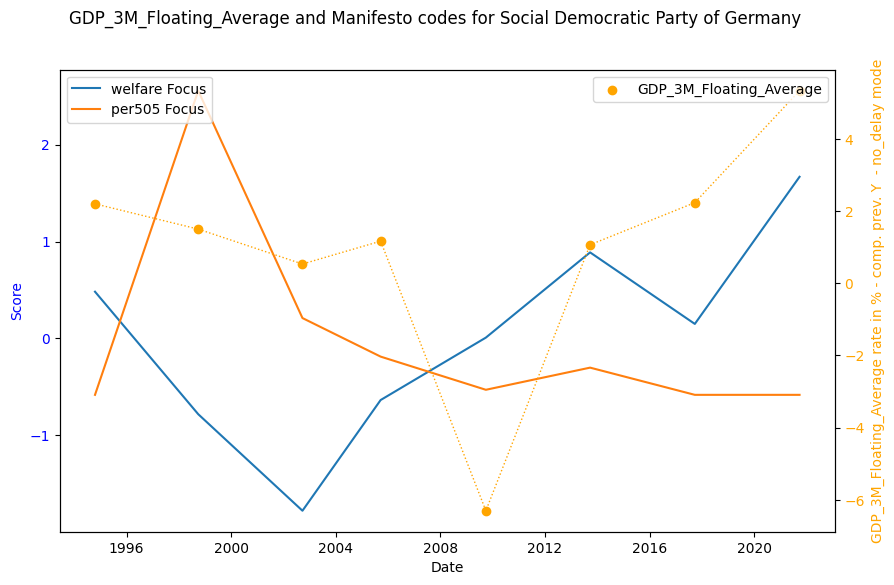

StandardScaler()
Results for Free Democratic Party on no_delay mode
##############################################################################
Free Democratic Party: Coefficient for welfare on GDP_3M_Floating_Average: 0.15315581306178808 (with intercept -0.14805061929306157) 

 y = -0.14805061929306157 + 0.15315581306178808*x 

For an increase of 1 of GDP_3M_Floating_Average, welfare in the manifesto of Free Democratic Party increases by 0.15315581306178808

Mean Squared Error (MSE) for welfare: 0.778568722975612
R² Score for welfare: 0.22143127702438803
##############################################################################
##############################################################################
Free Democratic Party: Coefficient for per505 on GDP_3M_Floating_Average: 0.03930912812578853 (with intercept -0.037998823854928795) 

 y = -0.037998823854928795 + 0.03930912812578853*x 

For an increase of 1 of GDP_3M_Floating_Average, per505 in the manifesto of Free Democrat

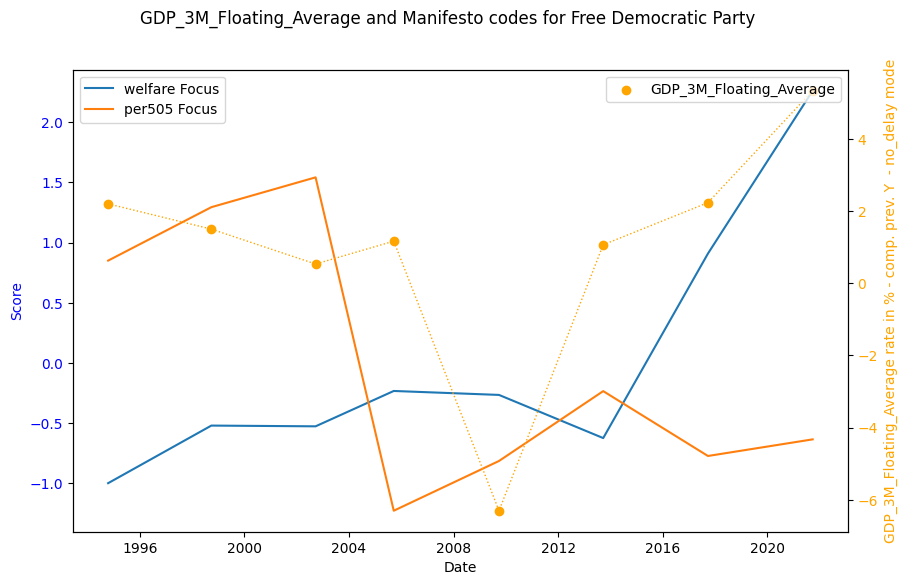

StandardScaler()
Results for Christian Democratic Union/Christian Social Union on no_delay mode
##############################################################################
Christian Democratic Union/Christian Social Union: Coefficient for welfare on GDP_3M_Floating_Average: 0.0865326672383296 (with intercept -0.08364824499705188) 

 y = -0.08364824499705188 + 0.0865326672383296*x 

For an increase of 1 of GDP_3M_Floating_Average, welfare in the manifesto of Christian Democratic Union/Christian Social Union increases by 0.0865326672383296

Mean Squared Error (MSE) for welfare: 0.9293142004058579
R² Score for welfare: 0.07068579959414234
##############################################################################
##############################################################################
Christian Democratic Union/Christian Social Union: Coefficient for per505 on GDP_3M_Floating_Average: 0.06129695065992423 (with intercept -0.059253718971260194) 

 y = -0.059253718971260194 + 0.0

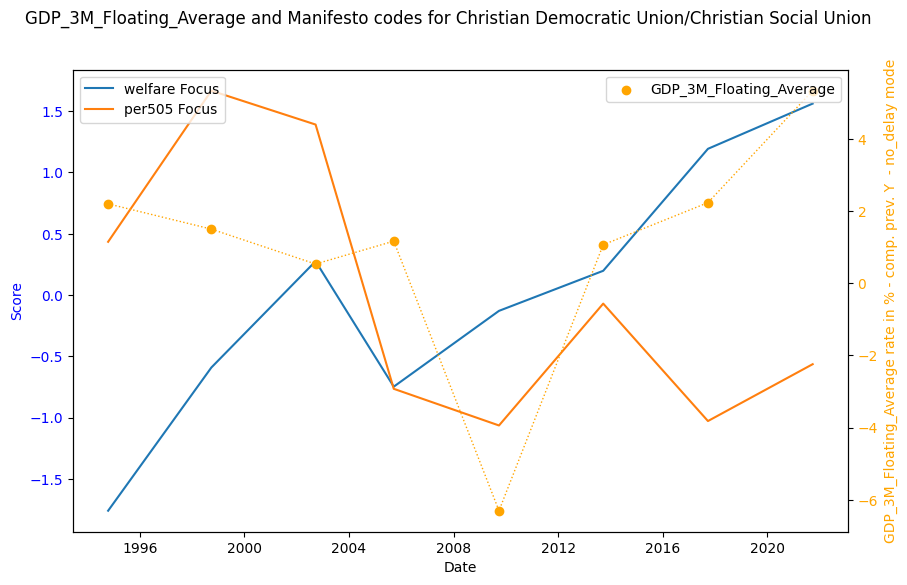

No valid data for German Party. Skipping analysis.
StandardScaler()
Results for nAlliance‘90/Greens on no_delay mode
##############################################################################
nAlliance‘90/Greens: Coefficient for welfare on GDP_3M_Floating_Average: 0.13212024526124794 (with intercept -0.12771623708587376) 

 y = -0.12771623708587376 + 0.13212024526124794*x 

For an increase of 1 of GDP_3M_Floating_Average, welfare in the manifesto of nAlliance‘90/Greens increases by 0.13212024526124794

Mean Squared Error (MSE) for welfare: 0.8352176330774967
R² Score for welfare: 0.16478236692250348
##############################################################################
##############################################################################
nAlliance‘90/Greens: Coefficient for per505 on GDP_3M_Floating_Average: -0.03584489378708869 (with intercept 0.034650063994185895) 

 y = 0.034650063994185895 + -0.03584489378708869*x 

For an increase of 1 of GDP_3M_Floating_Avera

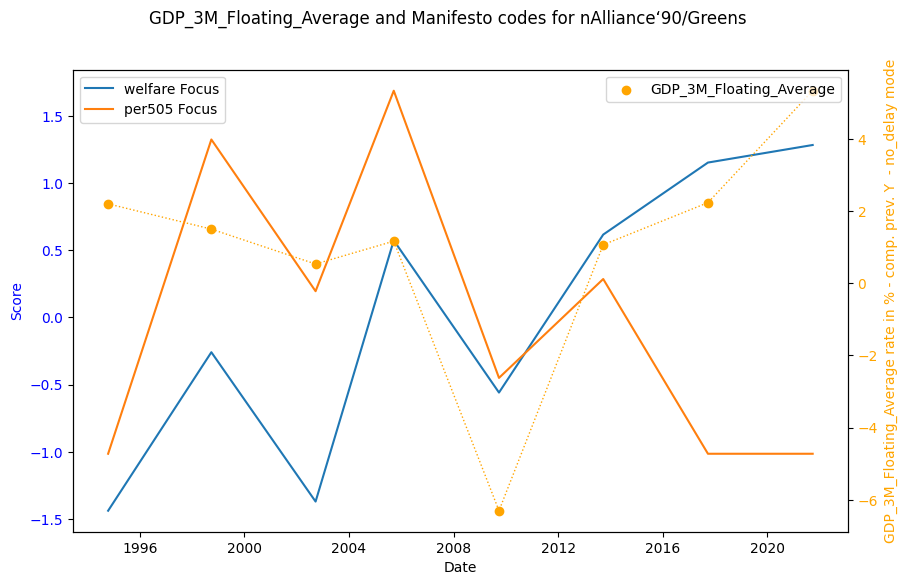

StandardScaler()
Results for nPDS/The Left on no_delay mode
##############################################################################
nPDS/The Left: Coefficient for welfare on GDP_3M_Floating_Average: 0.043821292880267274 (with intercept -0.042360583117591805) 

 y = -0.042360583117591805 + 0.043821292880267274*x 

For an increase of 1 of GDP_3M_Floating_Average, welfare in the manifesto of nPDS/The Left increases by 0.043821292880267274

Mean Squared Error (MSE) for welfare: 0.9818723141004493
R² Score for welfare: 0.018127685899550494
##############################################################################
##############################################################################
nPDS/The Left: Coefficient for per505 on GDP_3M_Floating_Average: 0.09028883868381986 (with intercept -0.08727921072769251) 

 y = -0.08727921072769251 + 0.09028883868381986*x 

For an increase of 1 of GDP_3M_Floating_Average, per505 in the manifesto of nPDS/The Left increases by 0.09028883868

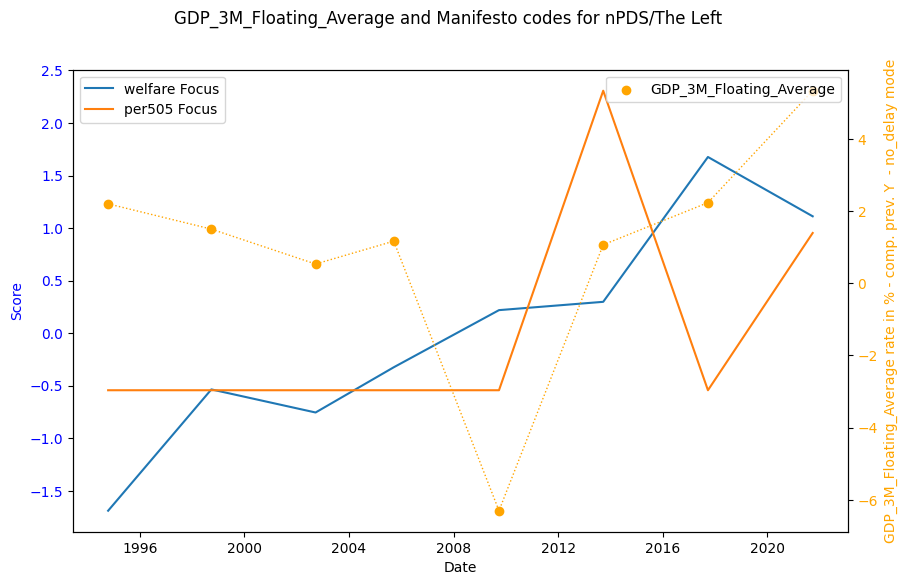

StandardScaler()
Results for Alternative for Germany on no_delay mode
##############################################################################
Alternative for Germany: Coefficient for welfare on GDP_3M_Floating_Average: -0.2550035187479486 (with intercept 0.7338434595079851) 

 y = 0.7338434595079851 + -0.2550035187479486*x 

For an increase of 1 of GDP_3M_Floating_Average, welfare in the manifesto of Alternative for Germany decreases by -0.2550035187479486

Mean Squared Error (MSE) for welfare: 0.7892007935901523
R² Score for welfare: 0.21079920640984784
##############################################################################
##############################################################################
Alternative for Germany: Coefficient for per505 on GDP_3M_Floating_Average: 0.5356216725493347 (with intercept -1.5414001465586409) 

 y = -1.5414001465586409 + 0.5356216725493347*x 

For an increase of 1 of GDP_3M_Floating_Average, per505 in the manifesto of Alternative fo

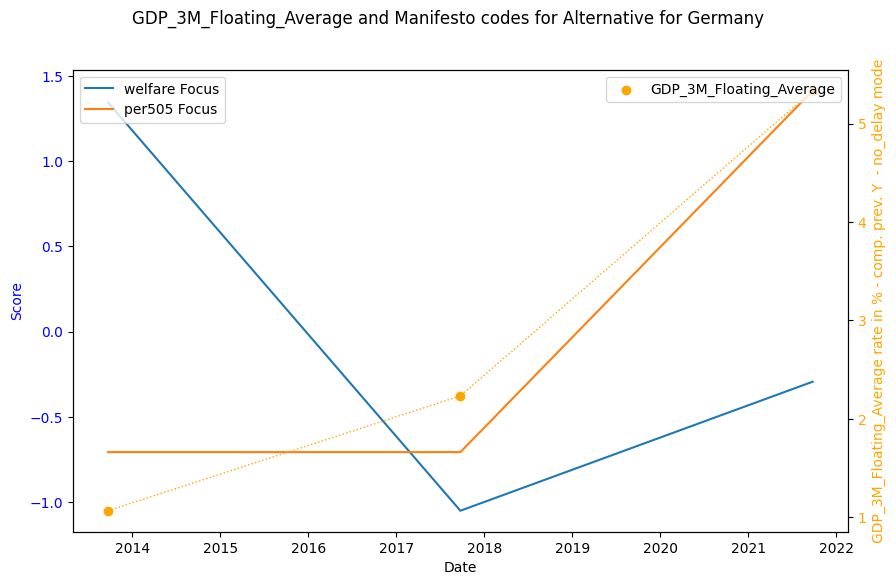

In [30]:
  
# Parameters to set
economic_value = 'GDP_3M_Floating_Average'
parameters = ['welfare', 'per505'] # welfare = 503 + 504 505 = Welfare State Limitation
y_label=f'{economic_value} rate in % - comp. prev. Y '
df_manifesto_mode='no_delay'



df_merged_for_analysis = pd.DataFrame()
df_merged_for_analysis = df_merging(df_new_manifesto_germany, cleaned_df_gdp_quarterly_monthly_change, df_manifesto_mode=df_manifesto_mode)

    
# Example: Analyze the relationship between economic indicators and manifesto focus for each party
for party in df_merged_for_analysis['partyname'].unique():
    party_df = analyze_party(df_merged_for_analysis, party, economic_value, parameters, df_manifesto_mode=df_manifesto_mode)
    
    if not party_df.empty:
        plot_party_analysis(party_df, party, economic_value, parameters, y_label=y_label, df_manifesto_mode=df_manifesto_mode)


## gdp and election data (delay)

StandardScaler()
Results for Social Democratic Party of Germany on delay mode
##############################################################################
Social Democratic Party of Germany: Coefficient for welfare on GDP_3M_Floating_Average: 0.10615360353179445 (with intercept -0.07209598906534348) 

 y = -0.07209598906534348 + 0.10615360353179445*x 

For an increase of 1 of GDP_3M_Floating_Average, welfare in the manifesto of Social Democratic Party of Germany increases by 0.10615360353179445

Mean Squared Error (MSE) for welfare: 0.8407844441452617
R² Score for welfare: 0.15921555585473823
##############################################################################
##############################################################################
Social Democratic Party of Germany: Coefficient for per505 on GDP_3M_Floating_Average: 0.019152623668608593 (with intercept -0.013007823574930107) 

 y = -0.013007823574930107 + 0.019152623668608593*x 

For an increase of 1 of GDP_3M_Floati

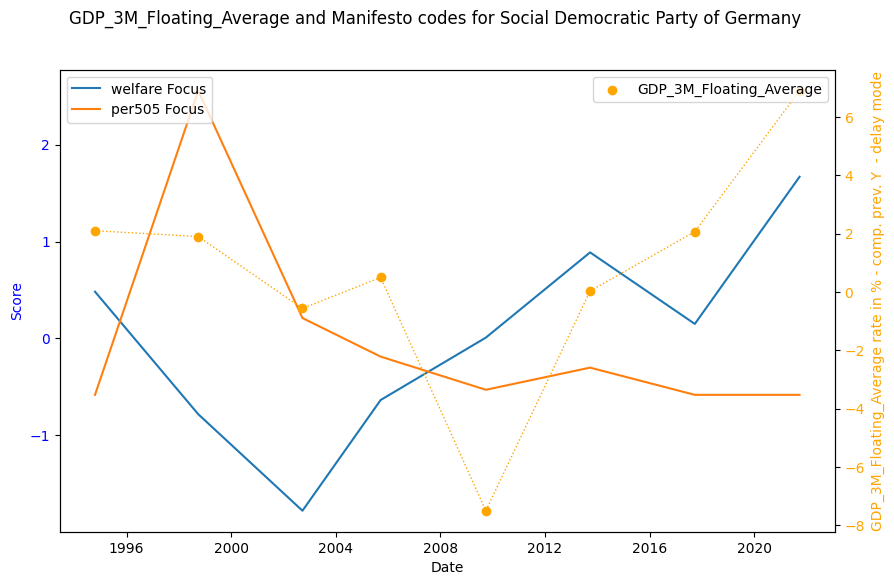

StandardScaler()
Results for Free Democratic Party on delay mode
##############################################################################
Free Democratic Party: Coefficient for welfare on GDP_3M_Floating_Average: 0.1464018550402478 (with intercept -0.09943125988150137) 

 y = -0.09943125988150137 + 0.1464018550402478*x 

For an increase of 1 of GDP_3M_Floating_Average, welfare in the manifesto of Free Democratic Party increases by 0.1464018550402478

Mean Squared Error (MSE) for welfare: 0.6971628337222029
R² Score for welfare: 0.3028371662777971
##############################################################################
##############################################################################
Free Democratic Party: Coefficient for per505 on GDP_3M_Floating_Average: 0.025458943676996665 (with intercept -0.017290865913960115) 

 y = -0.017290865913960115 + 0.025458943676996665*x 

For an increase of 1 of GDP_3M_Floating_Average, per505 in the manifesto of Free Democratic P

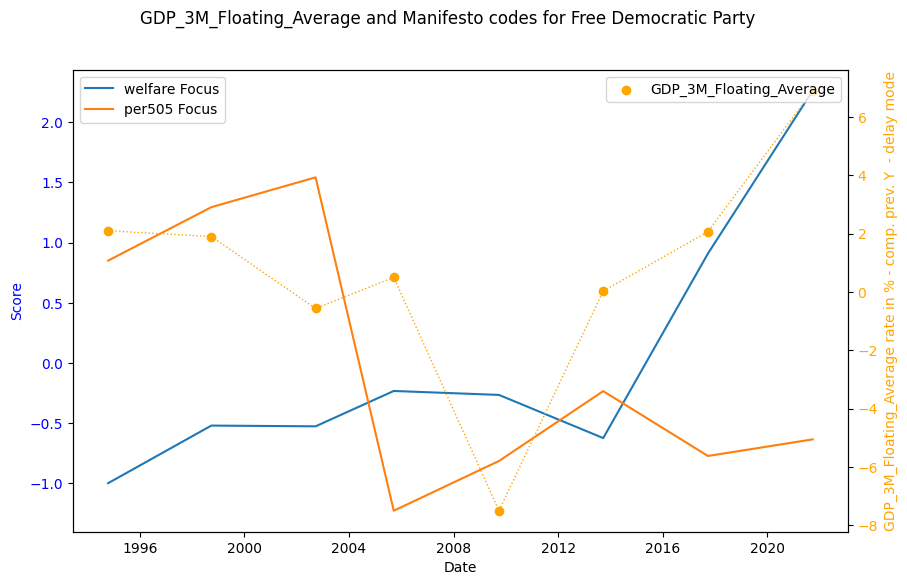

StandardScaler()
Results for Christian Democratic Union/Christian Social Union on delay mode
##############################################################################
Christian Democratic Union/Christian Social Union: Coefficient for welfare on GDP_3M_Floating_Average: 0.078459360163244 (with intercept -0.0532869821108698) 

 y = -0.0532869821108698 + 0.078459360163244*x 

For an increase of 1 of GDP_3M_Floating_Average, welfare in the manifesto of Christian Democratic Union/Christian Social Union increases by 0.078459360163244

Mean Squared Error (MSE) for welfare: 0.9130227767486302
R² Score for welfare: 0.08697722325137003
##############################################################################
##############################################################################
Christian Democratic Union/Christian Social Union: Coefficient for per505 on GDP_3M_Floating_Average: 0.04308009166394198 (with intercept -0.029258562255094024) 

 y = -0.029258562255094024 + 0.043080091

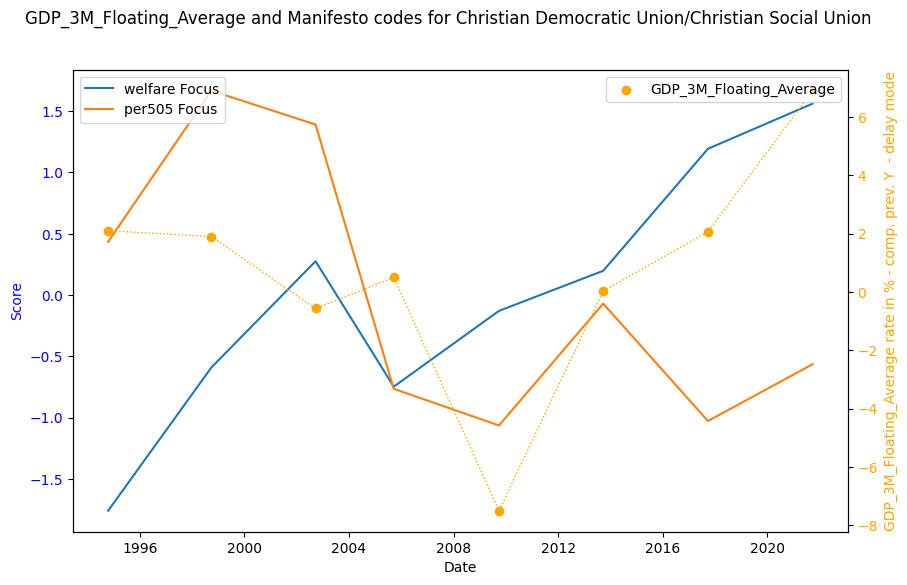

No valid data for German Party. Skipping analysis.
StandardScaler()
Results for nAlliance‘90/Greens on delay mode
##############################################################################
nAlliance‘90/Greens: Coefficient for welfare on GDP_3M_Floating_Average: 0.11494876717576244 (with intercept -0.07806937104020606) 

 y = -0.07806937104020606 + 0.11494876717576244*x 

For an increase of 1 of GDP_3M_Floating_Average, welfare in the manifesto of nAlliance‘90/Greens increases by 0.11494876717576244

Mean Squared Error (MSE) for welfare: 0.8133084548790941
R² Score for welfare: 0.18669154512090613
##############################################################################
##############################################################################
nAlliance‘90/Greens: Coefficient for per505 on GDP_3M_Floating_Average: -0.04060945195753759 (with intercept 0.0275805861211611) 

 y = 0.0275805861211611 + -0.04060945195753759*x 

For an increase of 1 of GDP_3M_Floating_Average, per

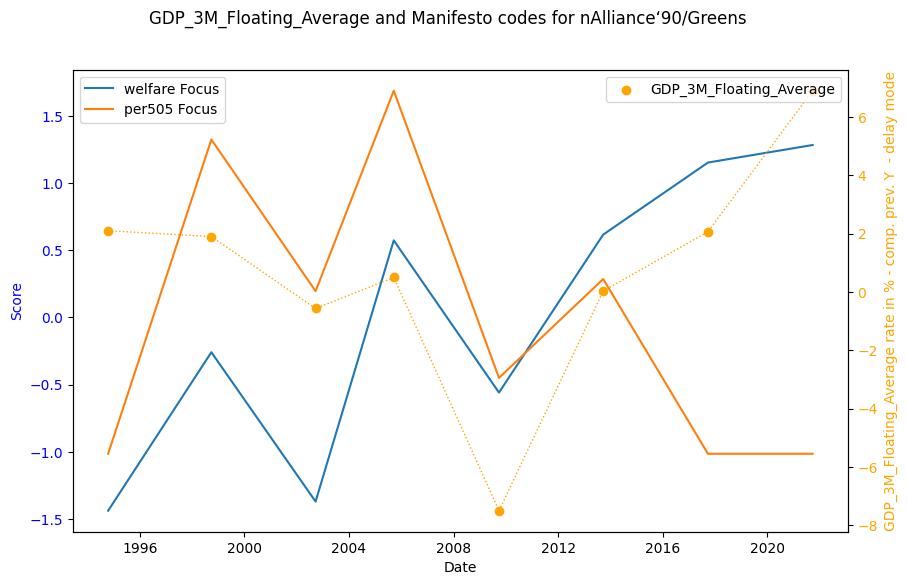

StandardScaler()
Results for nPDS/The Left on delay mode
##############################################################################
nPDS/The Left: Coefficient for welfare on GDP_3M_Floating_Average: 0.04603100004278275 (with intercept -0.03126272086239005) 

 y = -0.03126272086239005 + 0.04603100004278275*x 

For an increase of 1 of GDP_3M_Floating_Average, welfare in the manifesto of nPDS/The Left increases by 0.04603100004278275

Mean Squared Error (MSE) for welfare: 0.9700624101018627
R² Score for welfare: 0.029937589898137107
##############################################################################
##############################################################################
nPDS/The Left: Coefficient for per505 on GDP_3M_Floating_Average: 0.06606275153755849 (with intercept -0.044867618752591786) 

 y = -0.044867618752591786 + 0.06606275153755849*x 

For an increase of 1 of GDP_3M_Floating_Average, per505 in the manifesto of nPDS/The Left increases by 0.06606275153755849

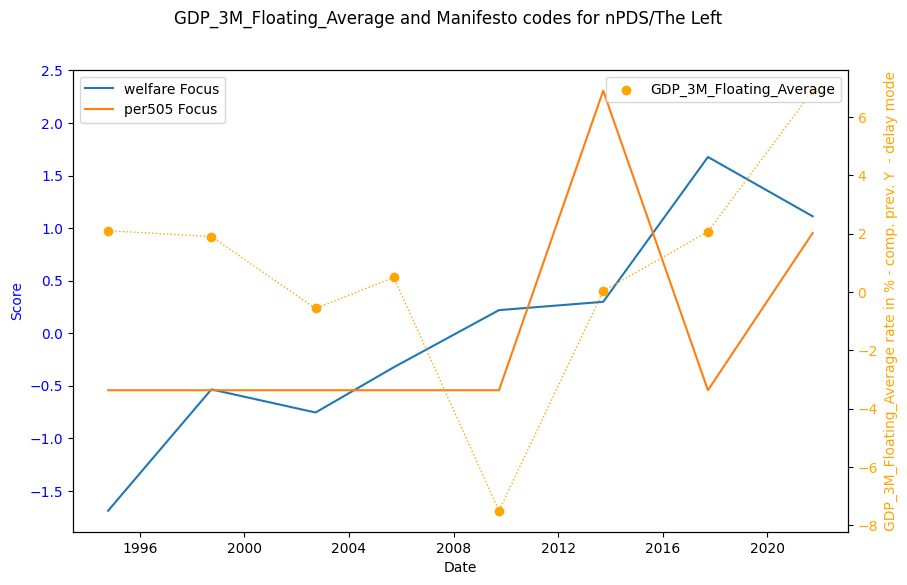

StandardScaler()
Results for Alternative for Germany on delay mode
##############################################################################
Alternative for Germany: Coefficient for welfare on GDP_3M_Floating_Average: -0.1669813683832188 (with intercept 0.5009441051496561) 

 y = 0.5009441051496561 + -0.1669813683832188*x 

For an increase of 1 of GDP_3M_Floating_Average, welfare in the manifesto of Alternative for Germany decreases by -0.1669813683832188

Mean Squared Error (MSE) for welfare: 0.7687381789602079
R² Score for welfare: 0.2312618210397922
##############################################################################
##############################################################################
Alternative for Germany: Coefficient for per505 on GDP_3M_Floating_Average: 0.3324923821512166 (with intercept -0.9974771464536498) 

 y = -0.9974771464536498 + 0.3324923821512166*x 

For an increase of 1 of GDP_3M_Floating_Average, per505 in the manifesto of Alternative for Ge

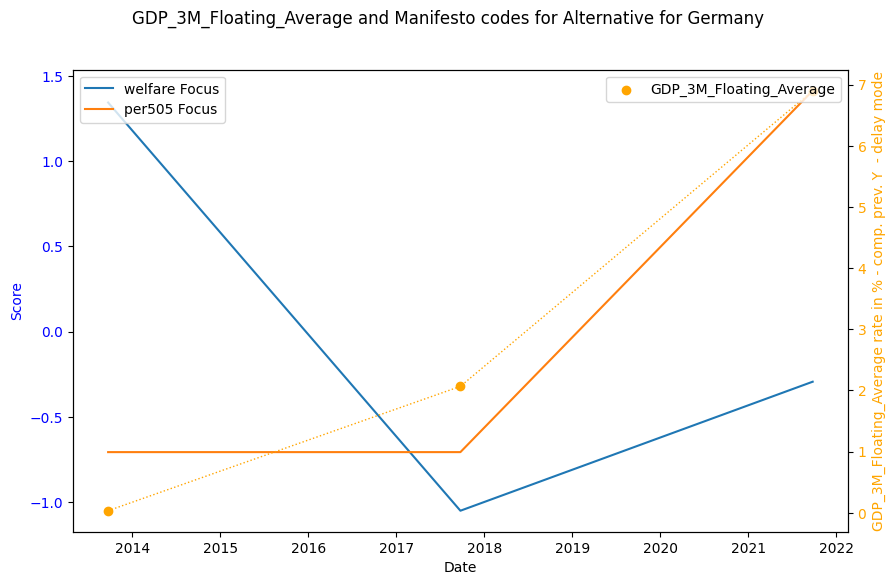

In [31]:
  
# Parameters to set
economic_value = 'GDP_3M_Floating_Average'
parameters = ['welfare', 'per505'] # welfare = 503 + 504 505 = Welfare State Limitation
y_label=f'{economic_value} rate in % - comp. prev. Y '
df_manifesto_mode='delay'



df_merged_for_analysis = pd.DataFrame()
df_merged_for_analysis = df_merging(df_new_manifesto_germany, cleaned_df_gdp_quarterly_monthly_change, df_manifesto_mode=df_manifesto_mode)

    
# Example: Analyze the relationship between economic indicators and manifesto focus for each party
for party in df_merged_for_analysis['partyname'].unique():
    party_df = analyze_party(df_merged_for_analysis, party, economic_value, parameters, df_manifesto_mode=df_manifesto_mode)
    
    if not party_df.empty:
        plot_party_analysis(party_df, party, economic_value, parameters, y_label=y_label, df_manifesto_mode=df_manifesto_mode)


## loop to find best codes for high R2

In [32]:
def analyze_best_code(df, party_name, economic_value, manifesto_codes, df_manifesto_mode='no_delay', global_best=None):
    party_df = pd.DataFrame()
    # Filter the data for the specific party
    party_df = df[df['partyname'] == party_name].copy()

    # Drop rows with NaN values in 'GDP_3M_Floating_Average' and the selected parameters
    party_df = party_df.dropna(subset=[economic_value] + manifesto_codes)

    if party_df.empty:
        print(f"No valid data for {party_name}. Skipping analysis.")
        return None, global_best

    # Normalize within party standards
    party_df = normalize_party_codes(party_df, manifesto_codes)

    X = party_df[economic_value].values.reshape(-1, 1)  # Reshape to 2D for single feature

    print(f"Results for {party_name} on {df_manifesto_mode} mode")

    # Track the best scores for this party
    party_mse_r2 = {}

    best_mse_param = None
    best_mse_score = float('inf')
    best_r2_param = None
    best_r2_score = float('-inf')

    # Loop through each manifesto code individually
    for param in manifesto_codes:
        y = party_df[param].values  # Dependent variable (manifesto focus)

        model = LinearRegression()
        model.fit(X, y)

        # Make predictions
        y_pred = model.predict(X)

        # Coefficients
        intercept = model.intercept_
        coef = model.coef_[0]

        # Calculate Mean Squared Error (MSE) and R² Score for the individual manifesto code
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)

        # Store the scores for the current param
        party_mse_r2[param] = {'MSE': mse, 'R2': r2}

        # Update party's best MSE and R²
        if mse < best_mse_score:
            best_mse_score = mse
            best_mse_param = param

        if r2 > best_r2_score:
            best_r2_score = r2
            best_r2_param = param

        print(f"{party_name}: Coefficient for {param} on {economic_value}: {coef} (with intercept {intercept})")
        print(f"MSE for {param}: {mse}")
        print(f"R² for {param}: {r2}")
        print('')

    print(f"Best MSE for {party_name}: {best_mse_param} = {best_mse_score}")
    print(f"Best R² for {party_name}: {best_r2_param} = {best_r2_score}")
    #party_mse_r2[f"best_mse_param_{best_mse_param}"] = {'MSE': best_mse_score}
    #party_mse_r2[f"best_r2_param_{best_r2_param}"] = {'R2': best_r2_score}
    
    partyabbrev = party_df["partyabbrev"].values[1]
    partyabbrev = partyabbrev[:3]
    save_path = os.path.join(f"{data_folder}best_codes", f'{partyabbrev}_{df_manifesto_mode}_mse_r2.json')
    
    with open(save_path, 'w') as f:
        json.dump(party_mse_r2, f, indent=4)
    
    
    # Update global best MSE and R² if necessary
    if global_best is None:
        global_best = {'best_mse_score': best_mse_score, 'best_mse_param': best_mse_param,
                       'best_r2_score': best_r2_score, 'best_r2_param': best_r2_param, 'party': party_name}
    else:
        if best_mse_score < global_best['best_mse_score']:
            global_best.update({'best_mse_score': best_mse_score, 'best_mse_param': best_mse_param, 'party': party_name})

        if best_r2_score > global_best['best_r2_score']:
            global_best.update({'best_r2_score': best_r2_score, 'best_r2_param': best_r2_param, 'party': party_name})

    return party_df, global_best


In [33]:
# Parameters to set CONFIG
economic_value = 'GDP_3M_Floating_Average'

parameters = list(all_codes_dict.keys())
y_label=f'{economic_value} rate in % - comp. prev. Y '
df_manifesto_mode='delay'



df_merged_for_analysis = pd.DataFrame()
df_merged_for_analysis = df_merging(df_new_manifesto_germany, cleaned_df_gdp_quarterly_monthly_change, df_manifesto_mode=df_manifesto_mode)

    
global_best = None  # Initialize global best tracker

for party in df_merged_for_analysis['partyname'].unique():
    # Analyze the party and get the filtered DataFrame
    party_df, global_best = analyze_best_code(df_merged_for_analysis, party, economic_value, parameters, df_manifesto_mode=df_manifesto_mode, global_best=global_best)
    print(f"global_best after {party} is {global_best}")
    

# Print the overall best scores across all parties
print(f"Best overall MSE: {global_best['best_mse_param']} from {global_best['party']} = {global_best['best_mse_score']}")
print(f"Best overall R²: {global_best['best_r2_param']} from {global_best['party']} = {global_best['best_r2_score']}")


StandardScaler()
Results for Social Democratic Party of Germany on delay mode
Social Democratic Party of Germany: Coefficient for per101 on GDP_3M_Floating_Average: -0.08813077538867596 (with intercept 0.059855484951475774)
MSE for per101: 0.8902584230195995
R² for per101: 0.10974157698040043

Social Democratic Party of Germany: Coefficient for per102 on GDP_3M_Floating_Average: -0.2187983403647493 (with intercept 0.14860053949772553)
MSE for per102: 0.32359927981543557
R² for per102: 0.6764007201845645

Social Democratic Party of Germany: Coefficient for per103 on GDP_3M_Floating_Average: 0.14455313138462167 (with intercept -0.09817566839872217)
MSE for per103: 0.7047628376609647
R² for per103: 0.2952371623390354

Social Democratic Party of Germany: Coefficient for per104 on GDP_3M_Floating_Average: 0.04039445155946884 (with intercept -0.027434565017472545)
MSE for per104: 0.9769453015298456
R² for per104: 0.023054698470154067

Social Democratic Party of Germany: Coefficient for per10

In [34]:
from collections import defaultdict
import os
import json

def analyze_json_for_codes(df_manifesto_mode):

    folder_path = f"{data_folder}/best_codes"

    # MSE and R² thresholds
    mse_threshold = 0.7
    r2_threshold = 0.3

    # Create an empty dictionary to store filtered results and code counts
    filtered_results = {}
    code_counts = defaultdict(lambda: {'count': 0, 'parties': []})
    top_categories_per_party = {}

    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        party_name = filename.split('_')[0]
        
        #if filename.endswith(f"{party_name}{df_manifesto_mode}_mse_r2.json"):
        if filename == f"{party_name}_{df_manifesto_mode}_mse_r2.json":
            
            file_path = os.path.join(folder_path, filename)

            # Open and load the JSON file
            with open(file_path, 'r') as file:
                data = json.load(file)

            # Get the party name from the filename (e.g., "SPD" from "SPD_mse_r2.json")
            filtered_results[party_name] = {}
            top_categories_per_party[party_name] = []  # Initialize for top 10

            # List to hold category, MSE, R² for this party
            party_scores = []

            # Loop through the categories in the JSON file
            for category, values in data.items():
                mse = values['MSE']
                r2 = values['R2']

                # Apply the filtering conditions
                if mse <= mse_threshold and mse > 0 and r2 >= r2_threshold and r2 < 1:
                    # Store the category if it meets the condition
                    filtered_results[party_name][category] = {
                        'MSE': mse,
                        'R2': r2
                    }

                    # Track the count of codes across parties
                    code_counts[category]['count'] += 1
                    code_counts[category]['parties'].append(party_name)

                    # Append category data to list for sorting later
                    party_scores.append((category, mse, r2))

            # Sort the categories for this party by MSE (ascending) and R² (descending)
            party_scores.sort(key=lambda x: (x[1], -x[2]))  # Sort by MSE first, then R²

            # Store the top 10 categories for the party
            top_categories_per_party[party_name] = party_scores[:10]

    # Print or save the filtered results
    print(json.dumps(filtered_results, indent=4))

    # Save the filtered results to a JSON file
    filtered_output_path = os.path.join(folder_path, f"filtered_results_{df_manifesto_mode}.json")
    with open(filtered_output_path, 'w') as output_file:
        json.dump(filtered_results, output_file, indent=4)

    print(f"Filtered results saved to {filtered_output_path}")

    # Print the code counts results
    for code, info in code_counts.items():
        print(f"Code: {code}, Count: {info['count']}, Parties: {', '.join(info['parties'])}")

    # Save the code counts to a JSON file
    code_counts_output_path = os.path.join(folder_path, f"code_counts_{df_manifesto_mode}.json")
    with open(code_counts_output_path, 'w') as output_file:
        json.dump(code_counts, output_file, indent=4)

    print(f"Code counts saved to {code_counts_output_path}")

    # Save the top 10 categories per party to a JSON file
    top_categories_output_path = os.path.join(folder_path, f"top_categories_per_party_{df_manifesto_mode}.json")
    with open(top_categories_output_path, 'w') as output_file:
        json.dump(top_categories_per_party, output_file, indent=4)

    print(f"Top 5 categories per party saved to {top_categories_output_path}")

analyze_json_for_codes(df_manifesto_mode=df_manifesto_mode)

{
    "SPD": {
        "per102": {
            "MSE": 0.32359927981543557,
            "R2": 0.6764007201845645
        },
        "per109": {
            "MSE": 0.5775089400502755,
            "R2": 0.42249105994972447
        },
        "per203": {
            "MSE": 0.6038426117324093,
            "R2": 0.39615738826759084
        },
        "per403": {
            "MSE": 0.5254803920616928,
            "R2": 0.47451960793830716
        },
        "per416": {
            "MSE": 0.520793605821148,
            "R2": 0.47920639417885214
        },
        "per504": {
            "MSE": 0.4887907220735526,
            "R2": 0.5112092779264474
        },
        "per705": {
            "MSE": 0.3356976791839392,
            "R2": 0.6643023208160608
        },
        "planeco": {
            "MSE": 0.6787481717166857,
            "R2": 0.3212518282833142
        }
    },
    "n90": {
        "per103": {
            "MSE": 0.3165231047787871,
            "R2": 0.6834768952212129
        }

## loop to find best codes for voteshare

In [35]:
"""
now independent variable is the codes
and dependent varbiable is the votes
since i am trying to see how manifesto focus leads to voting success
and not how  manifesto codes change based on voting results
"""

def analyze_best_code_for_vote(df, party_name, pervote_column, manifesto_codes, df_manifesto_mode='no_delay', global_best=None):
    """
    Analyzes how each manifesto code influences voting success (pervote).
    Independent variables are the manifesto codes.
    Dependent variable is the vote share (pervote).
    """
    
    # Filter the data for the specific party
    party_df = df[df['partyname'] == party_name].copy()

    # Drop rows with NaN values in 'pervote' and the selected manifesto codes
    party_df = party_df.dropna(subset=[pervote_column] + manifesto_codes)

    if party_df.empty:
        print(f"No valid data for {party_name}. Skipping analysis.")
        return None, global_best

    # Normalize the manifesto codes within party standards (assuming normalization function exists)
    party_df = normalize_party_codes(party_df, manifesto_codes)

    # Initialize the scaler for standardization
    scaler = StandardScaler()

    # Standardize the dependent variable (voting success)
    y = scaler.fit_transform(party_df[[pervote_column]])[:, 0]  # Dependent variable (voting success)

    print(f"Results for {party_name} on {df_manifesto_mode} mode")

    # Track the best scores for this party
    party_mse_r2 = {}

    best_mse_param = None
    best_mse_score = float('inf')
    best_r2_param = None
    best_r2_score = float('-inf')

    # Loop through each manifesto code to use as the independent variable (X)
    for param in manifesto_codes:
        X = party_df[[param]]  # Independent variable (manifesto code)

        # Standardize the independent variable
        X_scaled = scaler.fit_transform(X)

        model = LinearRegression()
        model.fit(X_scaled, y)

        # Make predictions
        y_pred = model.predict(X_scaled)

        # Coefficients
        intercept = model.intercept_
        coef = model.coef_[0]

        # Calculate Mean Squared Error (MSE) and R² Score for the individual manifesto code
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)

        # Store the scores for the current param
        party_mse_r2[param] = {'MSE': mse, 'R2': r2}

        # Update party's best MSE and R²
        if mse < best_mse_score:
            best_mse_score = mse
            best_mse_param = param

        if r2 > best_r2_score:
            best_r2_score = r2
            best_r2_param = param

        print(f"{party_name}: Coefficient for {param} on {pervote_column}: {coef} (with intercept {intercept})")
        print(f"MSE for {param}: {mse}")
        print(f"R² for {param}: {r2}")
        print('')

    print(f"Best MSE for {party_name}: {best_mse_param} = {best_mse_score}")
    print(f"Best R² for {party_name}: {best_r2_param} = {best_r2_score}")

    # Save party's results to a JSON file
    partyabbrev = party_df["partyabbrev"].values[1]
    partyabbrev = partyabbrev[:3]
    save_path = os.path.join(f"{data_folder}/best_codes", f'{partyabbrev}_{df_manifesto_mode}_vote_mse_r2.json')
    
    with open(save_path, 'w') as f:
        json.dump(party_mse_r2, f, indent=4)
    
    # Update global best MSE and R² if necessary
    if global_best is None:
        global_best = {'best_mse_score': best_mse_score, 'best_mse_param': best_mse_param,
                       'best_r2_score': best_r2_score, 'best_r2_param': best_r2_param, 'party': party_name}
    else:
        if best_mse_score < global_best['best_mse_score']:
            global_best.update({'best_mse_score': best_mse_score, 'best_mse_param': best_mse_param, 'party': party_name})

        if best_r2_score > global_best['best_r2_score']:
            global_best.update({'best_r2_score': best_r2_score, 'best_r2_param': best_r2_param, 'party': party_name})

    return party_df, global_best


In [36]:
# Parameters to set CONFIG
pervote_column = 'pervote'

parameters = list(all_codes_dict.keys())
y_label=f'{economic_value} rate in % - comp. prev. Y '
df_manifesto_mode='no_mode_vote' # since no economic data special 'no_mode_vote' to distinguish



df_merged_for_analysis = pd.DataFrame()
#df_merged_for_analysis = df_merging(df_new_manifesto_germany, cleaned_df_gdp_quarterly_monthly_change, df_manifesto_mode=df_manifesto_mode)
df_merged_for_analysis = df_new_manifesto_germany.copy()
#print(df_merged_for_analysis)

    
global_best = None  # Initialize global best tracker

for party in df_merged_for_analysis['partyname'].unique():
    # Analyze the party and get the filtered DataFrame
    party_df, global_best = analyze_best_code_for_vote(df_merged_for_analysis, party, pervote_column, parameters, df_manifesto_mode=df_manifesto_mode, global_best=global_best)
    print(f"global_best after {party} is {global_best}")
    

# Print the overall best scores across all parties
print(f"Best overall MSE: {global_best['best_mse_param']} from {global_best['party']} = {global_best['best_mse_score']}")
print(f"Best overall R²: {global_best['best_r2_param']} from {global_best['party']} = {global_best['best_r2_score']}")



StandardScaler()
Results for Social Democratic Party of Germany on no_mode_vote mode
Social Democratic Party of Germany: Coefficient for per101 on pervote: 0.5020524258999374 (with intercept -6.665895448731835e-17)
MSE for per101: 0.747943361647988
R² for per101: 0.2520566383520122

Social Democratic Party of Germany: Coefficient for per102 on pervote: -0.06016545539431477 (with intercept -5.75150634472326e-17)
MSE for per102: 0.9963801179771951
R² for per102: 0.0036198820228051654

Social Democratic Party of Germany: Coefficient for per103 on pervote: -0.40868851196088823 (with intercept -4.643644331368239e-17)
MSE for per103: 0.832973700191195
R² for per103: 0.16702629980880523

Social Democratic Party of Germany: Coefficient for per104 on pervote: 0.44831223886943006 (with intercept -4.244582877363785e-17)
MSE for per104: 0.799016136479879
R² for per104: 0.2009838635201211

Social Democratic Party of Germany: Coefficient for per105 on pervote: 0.10300399253311435 (with intercept -5.

In [37]:
analyze_json_for_codes(df_manifesto_mode=df_manifesto_mode)

{
    "DP": {
        "per101": {
            "MSE": 0.6797823771938861,
            "R2": 0.32021762280611377
        },
        "per102": {
            "MSE": 0.6089947560319486,
            "R2": 0.39100524396805125
        },
        "per107": {
            "MSE": 0.6089947560319486,
            "R2": 0.39100524396805125
        },
        "per108": {
            "MSE": 0.6089947560319486,
            "R2": 0.39100524396805125
        },
        "per201": {
            "MSE": 0.06707744727982747,
            "R2": 0.9329225527201725
        },
        "per202": {
            "MSE": 0.6089947560319486,
            "R2": 0.39100524396805125
        },
        "per302": {
            "MSE": 0.6089947560319486,
            "R2": 0.39100524396805125
        },
        "per304": {
            "MSE": 0.6089947560319486,
            "R2": 0.39100524396805125
        },
        "per305": {
            "MSE": 0.6797823771938861,
            "R2": 0.32021762280611377
        },
        "per40

## find party strategy

In [38]:
# Paths to the JSON files for delay and no_mode_vote
delay_file_path = f'{data_folder}best_codes/top_categories_per_party_delay.json'  # Replace with your actual file path
no_mode_vote_file_path = f'{data_folder}best_codes/top_categories_per_party_no_mode_vote.json'  # Replace with your actual file path
# Output file for the new JSON
output_file_path = f'{data_folder}best_codes/top_categories_party_strategy.json'

# Load the delay mode data
with open(delay_file_path, 'r') as delay_file:
    delay_data = json.load(delay_file)

# Load the no_mode_vote data
with open(no_mode_vote_file_path, 'r') as no_mode_vote_file:
    no_mode_vote_data = json.load(no_mode_vote_file)

# Create a dictionary to store the results
strategy_data = {}

# Iterate through all the parties in the delay mode data
for party, codes in delay_data.items():
    strategy_data[party] = {}
    
    # For each code in the party, store the MSE and R2 from delay
    for code_data in codes:
        code_name = code_data[0]  # The first item is the code name
        delay_mse = code_data[1]  # The second item is the MSE
        delay_r2 = code_data[2]   # The third item is the R2 score
        
        # Check if the party and code exist in no_mode_vote
        if party in no_mode_vote_data:
            for no_mode_code_data in no_mode_vote_data[party]:
                no_mode_code_name = no_mode_code_data[0]
                
                # If the code matches, store the data
                if code_name == no_mode_code_name:
                    no_mode_mse = no_mode_code_data[1]
                    no_mode_r2 = no_mode_code_data[2]
                    
                    # Store the data in the strategy_data dictionary
                    strategy_data[party][code_name] = {
                        'delay_MSE': delay_mse,
                        'delay_R2': delay_r2,
                        'no_mode_vote_MSE': no_mode_mse,
                        'no_mode_vote_R2': no_mode_r2
                    }
                    break

with open(output_file_path, 'w') as output_file:
    json.dump(strategy_data, output_file, indent=4)

print(f"Data saved to {output_file_path}")

Data saved to ./../DATA/best_codes/top_categories_party_strategy.json


## code + economic data as independent variable

In [39]:
def analyze_best_code_and_economics_for_vote(df, party_name, pervote_column, manifesto_codes, economic_value, df_manifesto_mode='no_delay', global_best=None):
    """
    Analyzes how both the manifesto codes and economic data influence voting success (pervote).
    Independent variables are the manifesto codes and economic_value.
    Dependent variable is the vote share (pervote).
    """
    
    # Filter the data for the specific party
    party_df = df[df['partyname'] == party_name].copy()

    # Drop rows with NaN values in 'pervote', the manifesto codes, and the economic variable
    party_df = party_df.dropna(subset=[pervote_column, economic_value] + manifesto_codes)

    if party_df.empty:
        print(f"No valid data for {party_name}. Skipping analysis.")
        return None, global_best

    # Normalize the manifesto codes and economic variable within party standards
    party_df = normalize_party_codes(party_df, manifesto_codes)

    # Initialize the scaler for standardization
    scaler = StandardScaler()

    # Standardize the dependent variable (voting success)
    y = scaler.fit_transform(party_df[[pervote_column]])[:, 0]  # Dependent variable (voting success)

    print(f"Results for {party_name} on {df_manifesto_mode} mode")

    # Track the best scores for this party
    party_mse_r2 = {}

    best_mse_param = None
    best_mse_score = float('inf')
    best_r2_param = None
    best_r2_score = float('-inf')

    # Loop through each manifesto code to use as an independent variable along with economic_value
    for param in manifesto_codes:
        # Combine the current manifesto code and the economic value as independent variables (X)
        X = party_df[[param, economic_value]]

        # Standardize the independent variables (both manifesto code and economic value)
        X_scaled = scaler.fit_transform(X)

        model = LinearRegression()
        model.fit(X_scaled, y)

        # Make predictions
        y_pred = model.predict(X_scaled)

        # Coefficients
        intercept = model.intercept_
        coef = model.coef_

        # Calculate Mean Squared Error (MSE) and R² Score for the current manifesto code and economic value
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)

        # Store the scores for the current param
        party_mse_r2[param] = {'MSE': mse, 'R2': r2}

        # Update party's best MSE and R²
        if mse < best_mse_score:
            best_mse_score = mse
            best_mse_param = param

        if r2 > best_r2_score:
            best_r2_score = r2
            best_r2_param = param

        print(f"{party_name}: Coefficient for {param} and {economic_value} on {pervote_column}: {coef} (with intercept {intercept})")
        print(f"MSE for {param}: {mse}")
        print(f"R² for {param}: {r2}")
        print('')

    print(f"Best MSE for {party_name}: {best_mse_param} = {best_mse_score}")
    print(f"Best R² for {party_name}: {best_r2_param} = {best_r2_score}")

    # Save party's results to a JSON file
    partyabbrev = party_df["partyabbrev"].values[1]
    partyabbrev = partyabbrev[:3]
    save_path = os.path.join(f"{data_folder}/best_codes", f'{partyabbrev}_{df_manifesto_mode}_vote_economic_mse_r2.json')
    
    with open(save_path, 'w') as f:
        json.dump(party_mse_r2, f, indent=4)
    
    # Update global best MSE and R² if necessary
    if global_best is None:
        global_best = {'best_mse_score': best_mse_score, 'best_mse_param': best_mse_param,
                       'best_r2_score': best_r2_score, 'best_r2_param': best_r2_param, 'party': party_name}
    else:
        if best_mse_score < global_best['best_mse_score']:
            global_best.update({'best_mse_score': best_mse_score, 'best_mse_param': best_mse_param, 'party': party_name})

        if best_r2_score > global_best['best_r2_score']:
            global_best.update({'best_r2_score': best_r2_score, 'best_r2_param': best_r2_param, 'party': party_name})

    return party_df, global_best


In [40]:
df_new_manifesto_germany = pd.read_excel(f"{data_folder}MP_new_Germany_chancellor.xlsx")

# Parameters to set CONFIG
economic_value = 'GDP_3M_Floating_Average'
#economic_value = 'was_chancellor_party'
#economic_value = 'was_government_party'

#parameters = ['per416', 'per504']
parameters = list(all_codes_dict.keys())
y_label = f'{economic_value} rate in % - comp. prev. Y'
# the economic data that influences pervote is the most recent no_delay
df_manifesto_mode = 'no_delay' 


df_merged_for_analysis = pd.DataFrame()
df_merged_for_analysis = df_merging(df_new_manifesto_germany, cleaned_df_gdp_quarterly_monthly_change, df_manifesto_mode=df_manifesto_mode)

# Analyze the relationship between manifesto focus, economic data, and vote success for each party
for party in df_merged_for_analysis['partyname'].unique():
    party_df, global_best = analyze_best_code_and_economics_for_vote(df_merged_for_analysis, party, 'pervote', parameters, economic_value, df_manifesto_mode)
    
    #if party_df is not None and not party_df.empty:
        #plot_party_analysis(party_df, party, economic_value, parameters, y_label=y_label, df_manifesto_mode=df_manifesto_mode)



StandardScaler()
Results for Social Democratic Party of Germany on no_delay mode
Social Democratic Party of Germany: Coefficient for per101 and GDP_3M_Floating_Average on pervote: [0.11054408 0.20759453] (with intercept 2.861986147839792e-16)
MSE for per101: 0.9606417200388875
R² for per101: 0.03935827996111252

Social Democratic Party of Germany: Coefficient for per102 and GDP_3M_Floating_Average on pervote: [-1.21120122 -0.91355995] (with intercept 2.731387697038262e-16)
MSE for per102: 0.6766607322525958
R² for per102: 0.3233392677474042

Social Democratic Party of Germany: Coefficient for per103 and GDP_3M_Floating_Average on pervote: [-0.61458746  0.47835753] (with intercept 2.9747138891533304e-16)
MSE for per103: 0.6892693536717704
R² for per103: 0.31073064632822955

Social Democratic Party of Germany: Coefficient for per104 and GDP_3M_Floating_Average on pervote: [0.52896749 0.08024192] (with intercept 2.6621470004638293e-16)
MSE for per104: 0.6994845619296922
R² for per104: 0.3

In [41]:
#analyze_json_for_codes(df_manifesto_mode=df_manifesto_mode)

In [42]:
# party strategy

# Paths to the JSON files for delay and no_mode_vote
delay_file_path = f'{data_folder}best_codes/top_categories_per_party_delay.json'  
no_mode_vote_file_path = f'{data_folder}best_codes/top_categories_per_party_no_delay_vote_economic.json'
# Output file for the new JSON
output_file_path = f'{data_folder}best_codes/top_categories_party_strategy_vote_economic.json'

# Load the delay mode data
with open(delay_file_path, 'r') as delay_file:
    delay_data = json.load(delay_file)

# Load the no_mode_vote data
with open(no_mode_vote_file_path, 'r') as no_mode_vote_file:
    no_mode_vote_data = json.load(no_mode_vote_file)

# Create a dictionary to store the results
strategy_data = {}

# Iterate through all the parties in the delay mode data
for party, codes in delay_data.items():
    strategy_data[party] = {}
    
    # For each code in the party, store the MSE and R2 from delay
    for code_data in codes:
        code_name = code_data[0]  # The first item is the code name
        delay_mse = code_data[1]  # The second item is the MSE
        delay_r2 = code_data[2]   # The third item is the R2 score
        
        # Check if the party and code exist in no_mode_vote
        if party in no_mode_vote_data:
            for no_mode_code_data in no_mode_vote_data[party]:
                no_mode_code_name = no_mode_code_data[0]
                
                # If the code matches, store the data
                if code_name == no_mode_code_name:
                    no_mode_mse = no_mode_code_data[1]
                    no_mode_r2 = no_mode_code_data[2]
                    
                    # Store the data in the strategy_data dictionary
                    strategy_data[party][code_name] = {
                        'delay_MSE': delay_mse,
                        'delay_R2': delay_r2,
                        'vote_economic_MSE': no_mode_mse,
                        'vote_economic_R2': no_mode_r2
                    }
                    break

with open(output_file_path, 'w') as output_file:
    json.dump(strategy_data, output_file, indent=4)

print(f"Data saved to {output_file_path}")

Data saved to ./../DATA/best_codes/top_categories_party_strategy_vote_economic.json


## for a list of values 

In [43]:
# for a list
def analyze_best_code_and_economics_for_vote(df, party_name, pervote_column, manifesto_codes, economic_values, df_manifesto_mode='no_delay', global_best=None):
    """
    Analyzes how both the manifesto codes and multiple economic data variables influence voting success (pervote).
    Independent variables are the manifesto codes and economic_values.
    Dependent variable is the vote share (pervote).
    """
    
    # Filter the data for the specific party
    party_df = df[df['partyname'] == party_name].copy()

    # Ensure economic_values is a list
    if not isinstance(economic_values, list):
        economic_values = [economic_values]

    # Drop rows with NaN values in 'pervote', the manifesto codes, and the economic variables
    party_df = party_df.dropna(subset=[pervote_column] + economic_values + manifesto_codes)

    if party_df.empty:
        print(f"No valid data for {party_name}. Skipping analysis.")
        return None, global_best

    # Normalize the manifesto codes and economic variable within party standards
    party_df = normalize_party_codes(party_df, manifesto_codes)

    # Initialize the scaler for standardization
    scaler = StandardScaler()

    # Standardize the dependent variable (voting success)
    y = scaler.fit_transform(party_df[[pervote_column]])[:, 0]  # Dependent variable (voting success)

    print(f"Results for {party_name} on {df_manifesto_mode} mode")

    # Track the best scores for this party
    party_mse_r2 = {}

    best_mse_param = None
    best_mse_score = float('inf')
    best_r2_param = None
    best_r2_score = float('-inf')

    # Loop through each manifesto code to use as an independent variable along with economic_values
    for param in manifesto_codes:
        # Combine the current manifesto code and the economic values as independent variables (X)
        X = party_df[[param] + economic_values]

        # Standardize the independent variables (both manifesto code and economic values)
        X_scaled = scaler.fit_transform(X)

        model = LinearRegression()
        model.fit(X_scaled, y)

        # Make predictions
        y_pred = model.predict(X_scaled)

        # Coefficients
        intercept = model.intercept_
        coef = model.coef_

        # Calculate Mean Squared Error (MSE) and R² Score for the current manifesto code and economic values
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)

        # Store the scores for the current param
        party_mse_r2[param] = {'MSE': mse, 'R2': r2}

        # Update party's best MSE and R²
        if mse < best_mse_score:
            best_mse_score = mse
            best_mse_param = param

        if r2 > best_r2_score:
            best_r2_score = r2
            best_r2_param = param

        print(f"{party_name}: Coefficient for {param} and {economic_values} on {pervote_column}: {coef} (with intercept {intercept})")
        print(f"MSE for {param}: {mse}")
        print(f"R² for {param}: {r2}")
        print('')

    print(f"Best MSE for {party_name}: {best_mse_param} = {best_mse_score}")
    print(f"Best R² for {party_name}: {best_r2_param} = {best_r2_score}")

    # Save party's results to a JSON file
    partyabbrev = party_df["partyabbrev"].values[1]
    partyabbrev = partyabbrev[:3]
    save_path = os.path.join(f"{data_folder}/best_codes", f'{partyabbrev}_{df_manifesto_mode}_vote_mse_r2_combined.json')
    
    with open(save_path, 'w') as f:
        json.dump(party_mse_r2, f, indent=4)
    
    # Update global best MSE and R² if necessary
    if global_best is None:
        global_best = {'best_mse_score': best_mse_score, 'best_mse_param': best_mse_param,
                       'best_r2_score': best_r2_score, 'best_r2_param': best_r2_param, 'party': party_name}
    else:
        if best_mse_score < global_best['best_mse_score']:
            global_best.update({'best_mse_score': best_mse_score, 'best_mse_param': best_mse_param, 'party': party_name})

        if best_r2_score > global_best['best_r2_score']:
            global_best.update({'best_r2_score': best_r2_score, 'best_r2_param': best_r2_param, 'party': party_name})

    return party_df, global_best


In [44]:
df_new_manifesto_germany = pd.read_excel(f"{data_folder}MP_new_Germany_chancellor.xlsx")

# Parameters to set CONFIG
economic_value = ['GDP_3M_Floating_Average', 'was_chancellor_party', 'was_government_party']

#parameters = ['per416', 'per504']
parameters = list(all_codes_dict.keys())
y_label = f'{economic_value} rate in % - comp. prev. Y'
# the economic data that influences pervote is the most recent no_delay
df_manifesto_mode = 'no_delay' 


df_merged_for_analysis = pd.DataFrame()
df_merged_for_analysis = df_merging(df_new_manifesto_germany, cleaned_df_gdp_quarterly_monthly_change, df_manifesto_mode=df_manifesto_mode)

# Analyze the relationship between manifesto focus, economic data, and vote success for each party
for party in df_merged_for_analysis['partyname'].unique():
    party_df, global_best = analyze_best_code_and_economics_for_vote(df_merged_for_analysis, party, 'pervote', parameters, economic_value, df_manifesto_mode)
    
    #if party_df is not None and not party_df.empty:
        #plot_party_analysis(party_df, party, economic_value, parameters, y_label=y_label, df_manifesto_mode=df_manifesto_mode)



StandardScaler()
Results for Social Democratic Party of Germany on no_delay mode
Social Democratic Party of Germany: Coefficient for per101 and ['GDP_3M_Floating_Average', 'was_chancellor_party', 'was_government_party'] on pervote: [ 0.11680741  0.11681494  0.80918699 -0.70566857] (with intercept 3.469242938114457e-16)
MSE for per101: 0.32729940494555626
R² for per101: 0.6727005950544438

Social Democratic Party of Germany: Coefficient for per102 and ['GDP_3M_Floating_Average', 'was_chancellor_party', 'was_government_party'] on pervote: [ 0.95845917  0.88596301  1.1567831  -1.05405001] (with intercept 3.813089164568754e-16)
MSE for per102: 0.2833979125060718
R² for per102: 0.7166020874939282

Social Democratic Party of Germany: Coefficient for per103 and ['GDP_3M_Floating_Average', 'was_chancellor_party', 'was_government_party'] on pervote: [-0.25867943  0.21031972  0.67486134 -0.66155401] (with intercept 3.4213621586157077e-16)
MSE for per103: 0.29802855699018166
R² for per103: 0.7019